<a href="https://colab.research.google.com/github/fshnkarimi/Labeling/blob/main/Buy%26Hold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Functions

In [ ]:
# Implement Buy&sell strategy
def buy_and_sell(df, InitialCapital):
    '''
    Update capital and number of shares after each buy or sell based on labels.

    Parameters
    ----------
        df : dataframe
            target dataframe for using buh&hold strategy
        InitialCapital : int
            Amount of initial capital
        
    Returns
    -------
    dataframe
        modified dataframe after implementing buy&hold strategy on input dataframe
    """
    '''
    capital = InitialCapital
    stock = 0
    old_trend = new_trend = df.Label[0]
    final_capitals = []
    last_index = df.loc[df.Label == 0, :].tail(1).index
    for i in range(df.Label.count()):
        new_trend = df.Label[i]
        
        if new_trend == 1 and capital != 0 and df.index[i] <= last_index:
          # Buy
          stock = capital / df.Price[i]
          capital = 0
          df['Trade Signal'][i] = 'Buy'
          df['Number of Shares'][i] = "{0:0.2f}".format(stock)

        elif new_trend != old_trend and new_trend == 0:
            # sell
            if stock != 0:
                capital = stock * df.Price[i]
                stock = 0
                df['Trade Signal'][i] = 'Sell'
                df['Number of Shares'][i] = '0'
        else:
            if i != 0:
                df['Number of Shares'][i] = df['Number of Shares'][i-1] 

        if capital != 0:
            final_capitals.append(capital)
        else:
            final_capitals.append(stock * df.Price[i])

        old_trend = df.Label[i]
    
    df = df.assign(FinalCapital=pd.Series(final_capitals))
    return df

In [ ]:
# Implement Buy&Hold strategy
def buy_and_hold(df, InitialCapital):
    '''
        Buy in first "BUY" label and sell on last "SELL" label
    '''
    capital = InitialCapital
    stock = 0
    old_trend = new_trend = df.Label[0]
    final_capitals = []
    last_index = df.loc[df.Label == 0, :].tail(1).index
    buy_index = df[df.Label == 1].index[0]
    sell_index = df[df.Label == 0].index[-1]
    for i in range(df.Label.count()):
        new_trend = df.Label[i]
        if i == buy_index:
          # Buy
          stock = capital / df.Price[i]
          capital = 0
          df['Trade Signal'][i] = 'Buy'
          df['Number of Shares'][i] = "{0:0.2f}".format(stock)

        elif i == sell_index:
            # sell
            if stock != 0:
                capital = stock * df.Price[i]
                stock = 0
                df['Trade Signal'][i] = 'Sell'
                df['Number of Shares'][i] = '0'
        else:
            if i != 0:
                df['Number of Shares'][i] = df['Number of Shares'][i-1] 

        if capital != 0:
            final_capitals.append(capital)
        else:
            final_capitals.append(stock * df.Price[i])

        old_trend = df.Label[i]
    
    df = df.assign(FinalCapital=pd.Series(final_capitals))
    return df

In [ ]:
# Calculate rate of return
def ROR(df, InitialCapital):
    '''
    Calculate rate of return for each row that we have stock

    Parameters
    ----------
        df : dataframe
            dataframe for calculating ror
        InitialCapital : int
            Amount of initial capital
        
    Returns
    -------
    dataframe
        modified dataframe after updating ROR values
    """
    '''

    df = df.assign(ROR=pd.Series(df.FinalCapital - InitialCapital)/ InitialCapital * 100)

    return df

In [ ]:
# def DD(df):
#     pct = df[["Price"]].pct_change()
#     wealth_index = InitialCapital * (1 + pct["Price"]).cumprod()
#     previous_peaks = wealth_index.cummax()
#     drawdown = (wealth_index - previous_peaks) / previous_peaks
#     drawdown = list(abs(drawdown))
#     drawdown[0] = 0
#     df = df.assign(DD=pd.Series(drawdown))
#     return df

def DD(df):
    max_ror = max(df.ROR)
    DD_list = []
    for ror in df.ROR:
        DD_list.append(max_ror - ror)
    df = df.assign(DD=pd.Series(DD_list))
    return df

In [ ]:
# Sharpe Ratio
# This should be changed
def sharpe_ratio(df):
    R = df.ROR[-1:].values[0]
    if df.ROR.std() == 0:
        return 0
    sr = R / df.ROR.std()
    return sr

In [ ]:
def metrics(df, InitialCapital, hold = False):
    if hold:
        df = buy_and_hold(df, InitialCapital)
    else:
        df = buy_and_sell(df, InitialCapital)
    df = ROR(df, InitialCapital)
    df = DD(df)
    MDD = max(abs(df.DD))
    # Add RRR column
    df['RRR'] = (df['ROR'] / MDD) * 100

    sr = sharpe_ratio(df)
    print(f"Sharpe Ratio = {sr} \n")
    print(f"MDD = {MDD} \n")
    return df

In [ ]:
InitialCapital = 10e6
InitialCapital

10000000.0

In [ ]:
# This function will be uncomment after updating the main code

# def add_metrics(df, file_name):
#     metrics_ = metrics(df, InitialCapital)
#     file_name = file_name + '_metrics.csv'
#     metrics_.to_csv(file_name)
#     print(metrics_.tail())

def add_metrics(df, file_name, dataset_type = 'china', hold = False):
    date_col = 'DATE'
    close_col = 'closingprice'
    if dataset_type == 'crypto':
        date_col = 'Date'
        close_col = 'Price'
    elif dataset_type == 'sp':
        date_col = '<DATE>'
        close_col = '<CLOSE>'
    data = {'Date': df[date_col], 'Price': df[close_col],
        'Label': df['labels'], 'Trade Signal': '', 'Number of Shares': '0'}
    df_new = pd.DataFrame(data)
    
    metrics_ = metrics(df_new, InitialCapital, hold)
    file_name_1 = file_name + '_metrics.csv'
    metrics_.to_csv(file_name_1)
    metrics_ = metrics_[metrics_['Number of Shares'] != '0'] 
    file_name_2 = file_name + '_metrics_filtered.csv'
    metrics_.to_csv(file_name_2)
    return metrics_

In [ ]:
# This function will be added to the main code

# def modify_df(df, dataset_type):
#     date_col = 'DATE'
#     close_col = 'closingprice'
#     if dataset_type == 'crypto':
#         date_col = 'Date'
#         close_col = 'Price'
#     data = {'Date': df[date_col], 'Price': df[close_col],
#         'Label': df['labels'], 'Trade Signal': '', 'Number of Shares': '0'}
#     df_new = pd.DataFrame(data)
#     return df_new

# BTC

## LSTM

In [ ]:
# Cross 
df = pd.read_csv('btc_lstm.csv', index_col=None, header=0)
add_metrics(df, 'btc_lstm', dataset_type='crypto')

Sharpe Ratio = 1.2083079648278074 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ...  10.163207  0.060956  1906.962315
286  Oct 13, 2020  11423.8      0  ...  10.163207  0.069920  1906.962315
287  Oct 14, 2020  11420.4      0  ...  10.163207  0.070197  1906.962315
288  Oct 15, 2020  11503.0      0  ...  10.163207  0.063472  1906.962315
289  Oct 16, 2020  11322.0      1  ...  10.163207  0.078208  1906.962315

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,Buy,1435.34,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,,1435.34,1.053983e+07,5.398306,0.000000,1012.905375
3,"Jan 04, 2020",7376.8,1,,1435.34,1.058820e+07,5.882015,0.000000,1103.665575
4,"Jan 05, 2020",7372.5,1,,1435.34,1.058203e+07,5.820296,0.000583,1092.084897
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.101632e+07,10.163207,0.060956,1906.962315
286,"Oct 13, 2020",11423.8,0,,0,1.101632e+07,10.163207,0.069920,1906.962315
287,"Oct 14, 2020",11420.4,0,,0,1.101632e+07,10.163207,0.070197,1906.962315
288,"Oct 15, 2020",11503.0,0,,0,1.101632e+07,10.163207,0.063472,1906.962315


In [ ]:
# Purge
df = pd.read_csv('btc_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_lstm_p', dataset_type='crypto')

Sharpe Ratio = 0.3025624073108589 

MDD = 0.5329526758927707 

             Date    Price  Label  ...      ROR        DD         RRR
285  Oct 12, 2020  11533.9      0  ...  2.65455  0.060956  498.083554
286  Oct 13, 2020  11423.8      0  ...  2.65455  0.069920  498.083554
287  Oct 14, 2020  11420.4      0  ...  2.65455  0.070197  498.083554
288  Oct 15, 2020  11503.0      0  ...  2.65455  0.063472  498.083554
289  Oct 16, 2020  11322.0      1  ...  2.65455  0.078208  498.083554

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,,1388.93,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,,1388.93,1.019903e+07,1.990333,0.000000,373.453996
3,"Jan 04, 2020",7376.8,1,,1388.93,1.024584e+07,2.458402,0.000000,461.279534
4,"Jan 05, 2020",7372.5,1,,1388.93,1.023987e+07,2.398678,0.000583,450.073308
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.026545e+07,2.654550,0.060956,498.083554
286,"Oct 13, 2020",11423.8,0,,0,1.026545e+07,2.654550,0.069920,498.083554
287,"Oct 14, 2020",11420.4,0,,0,1.026545e+07,2.654550,0.070197,498.083554
288,"Oct 15, 2020",11503.0,0,,0,1.026545e+07,2.654550,0.063472,498.083554


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('btc_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_lstm_beta', dataset_type='crypto')

Sharpe Ratio = 1.8991965111347162 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ...  23.986295  0.060956  4500.642535
286  Oct 13, 2020  11423.8      0  ...  23.986295  0.069920  4500.642535
287  Oct 14, 2020  11420.4      1  ...  23.986295  0.070197  4500.642535
288  Oct 15, 2020  11503.0      0  ...  24.883047  0.063472  4668.903652
289  Oct 16, 2020  11322.0      1  ...  24.883047  0.078208  4668.903652

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.239863e+07,23.986295,0.060956,4500.642535
286,"Oct 13, 2020",11423.8,0,,0,1.239863e+07,23.986295,0.069920,4500.642535
287,"Oct 14, 2020",11420.4,1,Buy,1085.66,1.239863e+07,23.986295,0.070197,4500.642535
288,"Oct 15, 2020",11503.0,0,Sell,0,1.248830e+07,24.883047,0.063472,4668.903652


In [ ]:
# Purge
df = pd.read_csv('btc_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_lstm_beta_p', dataset_type='crypto')

Sharpe Ratio = -2.6920681131595754 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -23.797416  0.060956 -4465.202545
286  Oct 13, 2020  11423.8      0  ... -23.797416  0.069920 -4465.202545
287  Oct 14, 2020  11420.4      0  ... -23.797416  0.070197 -4465.202545
288  Oct 15, 2020  11503.0      0  ... -23.797416  0.063472 -4465.202545
289  Oct 16, 2020  11322.0      1  ... -23.797416  0.078208 -4465.202545

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,0,Sell,0,9.994171e+06,-0.058291,0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.620258e+06,-23.797416,0.060956,-4465.202545
286,"Oct 13, 2020",11423.8,0,,0,7.620258e+06,-23.797416,0.069920,-4465.202545
287,"Oct 14, 2020",11420.4,0,,0,7.620258e+06,-23.797416,0.070197,-4465.202545
288,"Oct 15, 2020",11503.0,0,,0,7.620258e+06,-23.797416,0.063472,-4465.202545


## GRU

In [ ]:
# Cross
df = pd.read_csv('btc_gru.csv', index_col=None, header=0)
add_metrics(df, 'btc_gru', dataset_type='crypto')

Sharpe Ratio = 1.2393004569352466 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ...  12.164535  0.060956  2282.479321
286  Oct 13, 2020  11423.8      0  ...  12.164535  0.069920  2282.479321
287  Oct 14, 2020  11420.4      0  ...  12.164535  0.070197  2282.479321
288  Oct 15, 2020  11503.0      1  ...  12.164535  0.063472  2282.479321
289  Oct 16, 2020  11322.0      1  ...  12.164535  0.078208  2282.479321

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,Buy,1435.34,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,,1435.34,1.053983e+07,5.398306,0.000000,1012.905375
3,"Jan 04, 2020",7376.8,1,,1435.34,1.058820e+07,5.882015,0.000000,1103.665575
4,"Jan 05, 2020",7372.5,1,,1435.34,1.058203e+07,5.820296,0.000583,1092.084897
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.121645e+07,12.164535,0.060956,2282.479321
286,"Oct 13, 2020",11423.8,0,,0,1.121645e+07,12.164535,0.069920,2282.479321
287,"Oct 14, 2020",11420.4,0,,0,1.121645e+07,12.164535,0.070197,2282.479321
288,"Oct 15, 2020",11503.0,1,,0,1.121645e+07,12.164535,0.063472,2282.479321


In [ ]:
# Purge
df = pd.read_csv('btc_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_gru_p', dataset_type='crypto')

Sharpe Ratio = -1.663998456368676 

MDD = 0.5329526758927707 

             Date    Price  Label  ...       ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -45.70201  0.060956 -8575.247256
286  Oct 13, 2020  11423.8      0  ... -45.70201  0.069920 -8575.247256
287  Oct 14, 2020  11420.4      0  ... -45.70201  0.070197 -8575.247256
288  Oct 15, 2020  11503.0      1  ... -45.70201  0.063472 -8575.247256
289  Oct 16, 2020  11322.0      1  ... -45.70201  0.078208 -8575.247256

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,,1388.93,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,,1388.93,1.019903e+07,1.990333,0.000000,373.453996
3,"Jan 04, 2020",7376.8,1,,1388.93,1.024584e+07,2.458402,0.000000,461.279534
4,"Jan 05, 2020",7372.5,1,,1388.93,1.023987e+07,2.398678,0.000583,450.073308
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,5.429799e+06,-45.702010,0.060956,-8575.247256
286,"Oct 13, 2020",11423.8,0,,0,5.429799e+06,-45.702010,0.069920,-8575.247256
287,"Oct 14, 2020",11420.4,0,,0,5.429799e+06,-45.702010,0.070197,-8575.247256
288,"Oct 15, 2020",11503.0,1,,0,5.429799e+06,-45.702010,0.063472,-8575.247256


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('btc_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_gru_beta', dataset_type='crypto')

Sharpe Ratio = 1.1479002748718312 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ...  12.145533  0.060956  2278.913945
286  Oct 13, 2020  11423.8      0  ...  12.145533  0.069920  2278.913945
287  Oct 14, 2020  11420.4      0  ...  12.145533  0.070197  2278.913945
288  Oct 15, 2020  11503.0      1  ...  12.145533  0.063472  2278.913945
289  Oct 16, 2020  11322.0      1  ...  12.145533  0.078208  2278.913945

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,Buy,1435.34,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,,1435.34,1.053983e+07,5.398306,0.000000,1012.905375
3,"Jan 04, 2020",7376.8,1,,1435.34,1.058820e+07,5.882015,0.000000,1103.665575
4,"Jan 05, 2020",7372.5,1,,1435.34,1.058203e+07,5.820296,0.000583,1092.084897
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.121455e+07,12.145533,0.060956,2278.913945
286,"Oct 13, 2020",11423.8,0,,0,1.121455e+07,12.145533,0.069920,2278.913945
287,"Oct 14, 2020",11420.4,0,,0,1.121455e+07,12.145533,0.070197,2278.913945
288,"Oct 15, 2020",11503.0,1,,0,1.121455e+07,12.145533,0.063472,2278.913945


In [ ]:
# Purge
df = pd.read_csv('btc_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_gru_beta_p', dataset_type='crypto')

Sharpe Ratio = -1.7336241468858022 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -43.896829  0.060956 -8236.534069
286  Oct 13, 2020  11423.8      0  ... -43.896829  0.069920 -8236.534069
287  Oct 14, 2020  11420.4      0  ... -43.896829  0.070197 -8236.534069
288  Oct 15, 2020  11503.0      1  ... -43.896829  0.063472 -8236.534069
289  Oct 16, 2020  11322.0      1  ... -43.896829  0.078208 -8236.534069

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,,1388.93,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,,1388.93,1.019903e+07,1.990333,0.000000,373.453996
3,"Jan 04, 2020",7376.8,1,,1388.93,1.024584e+07,2.458402,0.000000,461.279534
4,"Jan 05, 2020",7372.5,1,,1388.93,1.023987e+07,2.398678,0.000583,450.073308
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,5.610317e+06,-43.896829,0.060956,-8236.534069
286,"Oct 13, 2020",11423.8,0,,0,5.610317e+06,-43.896829,0.069920,-8236.534069
287,"Oct 14, 2020",11420.4,0,,0,5.610317e+06,-43.896829,0.070197,-8236.534069
288,"Oct 15, 2020",11503.0,1,,0,5.610317e+06,-43.896829,0.063472,-8236.534069


## SVM

In [ ]:
# Cross
df = pd.read_csv('btc_svm.csv', index_col=None, header=0)
add_metrics(df, 'btc_svm', dataset_type='crypto')

Sharpe Ratio = -1.2241256434727004 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -12.626185  0.060956 -2369.100526
286  Oct 13, 2020  11423.8      0  ... -12.626185  0.069920 -2369.100526
287  Oct 14, 2020  11420.4      0  ... -12.626185  0.070197 -2369.100526
288  Oct 15, 2020  11503.0      1  ... -12.626185  0.063472 -2369.100526
289  Oct 16, 2020  11322.0      1  ... -12.626185  0.078208 -2369.100526

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.737382e+06,-12.626185,0.060956,-2369.100526
286,"Oct 13, 2020",11423.8,0,,0,8.737382e+06,-12.626185,0.069920,-2369.100526
287,"Oct 14, 2020",11420.4,0,,0,8.737382e+06,-12.626185,0.070197,-2369.100526
288,"Oct 15, 2020",11503.0,1,,0,8.737382e+06,-12.626185,0.063472,-2369.100526


In [ ]:
# Purge
df = pd.read_csv('btc_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_svm_p', dataset_type='crypto')

Sharpe Ratio = -1.2241256434727004 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -12.626185  0.060956 -2369.100526
286  Oct 13, 2020  11423.8      0  ... -12.626185  0.069920 -2369.100526
287  Oct 14, 2020  11420.4      0  ... -12.626185  0.070197 -2369.100526
288  Oct 15, 2020  11503.0      1  ... -12.626185  0.063472 -2369.100526
289  Oct 16, 2020  11322.0      1  ... -12.626185  0.078208 -2369.100526

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.737382e+06,-12.626185,0.060956,-2369.100526
286,"Oct 13, 2020",11423.8,0,,0,8.737382e+06,-12.626185,0.069920,-2369.100526
287,"Oct 14, 2020",11420.4,0,,0,8.737382e+06,-12.626185,0.070197,-2369.100526
288,"Oct 15, 2020",11503.0,1,,0,8.737382e+06,-12.626185,0.063472,-2369.100526


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('btc_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_svm_beta', dataset_type='crypto')

Sharpe Ratio = -1.2241256434727004 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -12.626185  0.060956 -2369.100526
286  Oct 13, 2020  11423.8      0  ... -12.626185  0.069920 -2369.100526
287  Oct 14, 2020  11420.4      0  ... -12.626185  0.070197 -2369.100526
288  Oct 15, 2020  11503.0      1  ... -12.626185  0.063472 -2369.100526
289  Oct 16, 2020  11322.0      1  ... -12.626185  0.078208 -2369.100526

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.737382e+06,-12.626185,0.060956,-2369.100526
286,"Oct 13, 2020",11423.8,0,,0,8.737382e+06,-12.626185,0.069920,-2369.100526
287,"Oct 14, 2020",11420.4,0,,0,8.737382e+06,-12.626185,0.070197,-2369.100526
288,"Oct 15, 2020",11503.0,1,,0,8.737382e+06,-12.626185,0.063472,-2369.100526


In [ ]:
# Purge
df = pd.read_csv('btc_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_svm_beta_p', dataset_type='crypto')

Sharpe Ratio = -1.2241256434727004 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -12.626185  0.060956 -2369.100526
286  Oct 13, 2020  11423.8      0  ... -12.626185  0.069920 -2369.100526
287  Oct 14, 2020  11420.4      0  ... -12.626185  0.070197 -2369.100526
288  Oct 15, 2020  11503.0      1  ... -12.626185  0.063472 -2369.100526
289  Oct 16, 2020  11322.0      1  ... -12.626185  0.078208 -2369.100526

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.737382e+06,-12.626185,0.060956,-2369.100526
286,"Oct 13, 2020",11423.8,0,,0,8.737382e+06,-12.626185,0.069920,-2369.100526
287,"Oct 14, 2020",11420.4,0,,0,8.737382e+06,-12.626185,0.070197,-2369.100526
288,"Oct 15, 2020",11503.0,1,,0,8.737382e+06,-12.626185,0.063472,-2369.100526


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('btc_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'btc_xgboost', dataset_type=
'crypto')

Sharpe Ratio = -1.0948531416375744 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -13.247139  0.060956 -2485.612581
286  Oct 13, 2020  11423.8      0  ... -13.247139  0.069920 -2485.612581
287  Oct 14, 2020  11420.4      1  ... -13.247139  0.070197 -2485.612581
288  Oct 15, 2020  11503.0      1  ... -13.247139  0.063472 -2485.612581
289  Oct 16, 2020  11322.0      1  ... -13.247139  0.078208 -2485.612581

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,Sell,0,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,Buy,1317.79,9.676658e+06,-3.233423,0.000000,-606.699862
3,"Jan 04, 2020",7376.8,1,,1317.79,9.721067e+06,-2.789328,0.000000,-523.372585
4,"Jan 05, 2020",7372.5,1,,1317.79,9.715401e+06,-2.845993,0.000583,-534.004849
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.675286e+06,-13.247139,0.060956,-2485.612581
286,"Oct 13, 2020",11423.8,0,,0,8.675286e+06,-13.247139,0.069920,-2485.612581
287,"Oct 14, 2020",11420.4,1,,0,8.675286e+06,-13.247139,0.070197,-2485.612581
288,"Oct 15, 2020",11503.0,1,,0,8.675286e+06,-13.247139,0.063472,-2485.612581


In [ ]:
# Purge
df = pd.read_csv('btc_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_xgboost_p', dataset_type=
'crypto')

Sharpe Ratio = -1.0948531416375744 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -13.247139  0.060956 -2485.612581
286  Oct 13, 2020  11423.8      0  ... -13.247139  0.069920 -2485.612581
287  Oct 14, 2020  11420.4      1  ... -13.247139  0.070197 -2485.612581
288  Oct 15, 2020  11503.0      1  ... -13.247139  0.063472 -2485.612581
289  Oct 16, 2020  11322.0      1  ... -13.247139  0.078208 -2485.612581

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,Sell,0,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,Buy,1317.79,9.676658e+06,-3.233423,0.000000,-606.699862
3,"Jan 04, 2020",7376.8,1,,1317.79,9.721067e+06,-2.789328,0.000000,-523.372585
4,"Jan 05, 2020",7372.5,1,,1317.79,9.715401e+06,-2.845993,0.000583,-534.004849
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.675286e+06,-13.247139,0.060956,-2485.612581
286,"Oct 13, 2020",11423.8,0,,0,8.675286e+06,-13.247139,0.069920,-2485.612581
287,"Oct 14, 2020",11420.4,1,,0,8.675286e+06,-13.247139,0.070197,-2485.612581
288,"Oct 15, 2020",11503.0,1,,0,8.675286e+06,-13.247139,0.063472,-2485.612581


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('btc_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_xgboost_beta', dataset_type='crypto')

Sharpe Ratio = -1.0948531416375744 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -13.247139  0.060956 -2485.612581
286  Oct 13, 2020  11423.8      0  ... -13.247139  0.069920 -2485.612581
287  Oct 14, 2020  11420.4      1  ... -13.247139  0.070197 -2485.612581
288  Oct 15, 2020  11503.0      1  ... -13.247139  0.063472 -2485.612581
289  Oct 16, 2020  11322.0      1  ... -13.247139  0.078208 -2485.612581

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,Sell,0,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,Buy,1317.79,9.676658e+06,-3.233423,0.000000,-606.699862
3,"Jan 04, 2020",7376.8,1,,1317.79,9.721067e+06,-2.789328,0.000000,-523.372585
4,"Jan 05, 2020",7372.5,1,,1317.79,9.715401e+06,-2.845993,0.000583,-534.004849
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.675286e+06,-13.247139,0.060956,-2485.612581
286,"Oct 13, 2020",11423.8,0,,0,8.675286e+06,-13.247139,0.069920,-2485.612581
287,"Oct 14, 2020",11420.4,1,,0,8.675286e+06,-13.247139,0.070197,-2485.612581
288,"Oct 15, 2020",11503.0,1,,0,8.675286e+06,-13.247139,0.063472,-2485.612581


In [ ]:
# Purge
df = pd.read_csv('btc_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_xgboost_beta_p', dataset_type='crypto')

Sharpe Ratio = -1.0948531416375744 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -13.247139  0.060956 -2485.612581
286  Oct 13, 2020  11423.8      0  ... -13.247139  0.069920 -2485.612581
287  Oct 14, 2020  11420.4      1  ... -13.247139  0.070197 -2485.612581
288  Oct 15, 2020  11503.0      1  ... -13.247139  0.063472 -2485.612581
289  Oct 16, 2020  11322.0      1  ... -13.247139  0.078208 -2485.612581

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,Sell,0,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,Buy,1317.79,9.676658e+06,-3.233423,0.000000,-606.699862
3,"Jan 04, 2020",7376.8,1,,1317.79,9.721067e+06,-2.789328,0.000000,-523.372585
4,"Jan 05, 2020",7372.5,1,,1317.79,9.715401e+06,-2.845993,0.000583,-534.004849
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.675286e+06,-13.247139,0.060956,-2485.612581
286,"Oct 13, 2020",11423.8,0,,0,8.675286e+06,-13.247139,0.069920,-2485.612581
287,"Oct 14, 2020",11420.4,1,,0,8.675286e+06,-13.247139,0.070197,-2485.612581
288,"Oct 15, 2020",11503.0,1,,0,8.675286e+06,-13.247139,0.063472,-2485.612581


## LR

In [ ]:
# Cross
df = pd.read_csv('btc_logreg.csv', index_col=None, header=0)
add_metrics(df, 'btc_logreg', dataset_type='crypto')

Sharpe Ratio = -2.355203487870069 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -25.748248  0.060956 -4831.244769
286  Oct 13, 2020  11423.8      0  ... -25.748248  0.069920 -4831.244769
287  Oct 14, 2020  11420.4      0  ... -25.748248  0.070197 -4831.244769
288  Oct 15, 2020  11503.0      1  ... -25.748248  0.063472 -4831.244769
289  Oct 16, 2020  11322.0      1  ... -25.748248  0.078208 -4831.244769

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,1,,1355.60,9.994171e+06,-0.058291,0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.425175e+06,-25.748248,0.060956,-4831.244769
286,"Oct 13, 2020",11423.8,0,,0,7.425175e+06,-25.748248,0.069920,-4831.244769
287,"Oct 14, 2020",11420.4,0,,0,7.425175e+06,-25.748248,0.070197,-4831.244769
288,"Oct 15, 2020",11503.0,1,,0,7.425175e+06,-25.748248,0.063472,-4831.244769


In [ ]:
# Purge
df = pd.read_csv('btc_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_logreg_p', dataset_type='crypto')

Sharpe Ratio = -2.355203487870069 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -25.748248  0.060956 -4831.244769
286  Oct 13, 2020  11423.8      0  ... -25.748248  0.069920 -4831.244769
287  Oct 14, 2020  11420.4      0  ... -25.748248  0.070197 -4831.244769
288  Oct 15, 2020  11503.0      1  ... -25.748248  0.063472 -4831.244769
289  Oct 16, 2020  11322.0      1  ... -25.748248  0.078208 -4831.244769

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,1,,1355.60,9.994171e+06,-0.058291,0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.425175e+06,-25.748248,0.060956,-4831.244769
286,"Oct 13, 2020",11423.8,0,,0,7.425175e+06,-25.748248,0.069920,-4831.244769
287,"Oct 14, 2020",11420.4,0,,0,7.425175e+06,-25.748248,0.070197,-4831.244769
288,"Oct 15, 2020",11503.0,1,,0,7.425175e+06,-25.748248,0.063472,-4831.244769


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('btc_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_logreg_beta', dataset_type='crypto')

Sharpe Ratio = -2.355203487870069 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -25.748248  0.060956 -4831.244769
286  Oct 13, 2020  11423.8      0  ... -25.748248  0.069920 -4831.244769
287  Oct 14, 2020  11420.4      0  ... -25.748248  0.070197 -4831.244769
288  Oct 15, 2020  11503.0      1  ... -25.748248  0.063472 -4831.244769
289  Oct 16, 2020  11322.0      1  ... -25.748248  0.078208 -4831.244769

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,1,,1355.60,9.994171e+06,-0.058291,0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.425175e+06,-25.748248,0.060956,-4831.244769
286,"Oct 13, 2020",11423.8,0,,0,7.425175e+06,-25.748248,0.069920,-4831.244769
287,"Oct 14, 2020",11420.4,0,,0,7.425175e+06,-25.748248,0.070197,-4831.244769
288,"Oct 15, 2020",11503.0,1,,0,7.425175e+06,-25.748248,0.063472,-4831.244769


In [ ]:
# Purge
df = pd.read_csv('btc_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_logreg_beta_p', dataset_type='crypto')

Sharpe Ratio = -2.355203487870069 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -25.748248  0.060956 -4831.244769
286  Oct 13, 2020  11423.8      0  ... -25.748248  0.069920 -4831.244769
287  Oct 14, 2020  11420.4      0  ... -25.748248  0.070197 -4831.244769
288  Oct 15, 2020  11503.0      1  ... -25.748248  0.063472 -4831.244769
289  Oct 16, 2020  11322.0      1  ... -25.748248  0.078208 -4831.244769

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,1,,1355.60,9.994171e+06,-0.058291,0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.425175e+06,-25.748248,0.060956,-4831.244769
286,"Oct 13, 2020",11423.8,0,,0,7.425175e+06,-25.748248,0.069920,-4831.244769
287,"Oct 14, 2020",11420.4,0,,0,7.425175e+06,-25.748248,0.070197,-4831.244769
288,"Oct 15, 2020",11503.0,1,,0,7.425175e+06,-25.748248,0.063472,-4831.244769


# ETH

## LSTM

In [ ]:
# Cross
df = pd.read_csv('eth_lstm.csv', index_col=None, header=0)
add_metrics(df, 'eth_lstm', dataset_type='crypto')

Sharpe Ratio = 2.665214345466587 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD          RRR
285  Oct 12, 2020  386.68      1  ...  136.115906  0.187306  21892.90227
286  Oct 13, 2020  381.23      1  ...  136.115906  0.198760  21892.90227
287  Oct 14, 2020  379.15      1  ...  136.115906  0.203132  21892.90227
288  Oct 15, 2020  377.45      1  ...  136.115906  0.206704  21892.90227
289  Oct 16, 2020  365.17      1  ...  136.115906  0.232514  21892.90227

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,1,,76481.84,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,,76481.84,1.026922e+07,2.692161e+00,0.000000,4.330075e+02
3,"Jan 04, 2020",134.33,1,,76481.84,1.027380e+07,2.738050e+00,0.000000,4.403883e+02
4,"Jan 05, 2020",135.59,1,,76481.84,1.037017e+07,3.701721e+00,0.000000,5.953853e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,0,2.361159e+07,1.361159e+02,0.187306,2.189290e+04
286,"Oct 13, 2020",381.23,1,,0,2.361159e+07,1.361159e+02,0.198760,2.189290e+04
287,"Oct 14, 2020",379.15,1,,0,2.361159e+07,1.361159e+02,0.203132,2.189290e+04
288,"Oct 15, 2020",377.45,1,,0,2.361159e+07,1.361159e+02,0.206704,2.189290e+04


In [ ]:

# Purge
df = pd.read_csv('eth_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_lstm_p', dataset_type='crypto')

Sharpe Ratio = 2.4542620568782074 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  66.175541  0.187306  10643.683763
286  Oct 13, 2020  381.23      1  ...  66.175541  0.198760  10643.683763
287  Oct 14, 2020  379.15      1  ...  66.175541  0.203132  10643.683763
288  Oct 15, 2020  377.45      1  ...  66.175541  0.206704  10643.683763
289  Oct 16, 2020  365.17      1  ...  66.175541  0.232514  10643.683763

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,1,,76481.84,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,,76481.84,1.026922e+07,2.692161e+00,0.000000,4.330075e+02
3,"Jan 04, 2020",134.33,1,,76481.84,1.027380e+07,2.738050e+00,0.000000,4.403883e+02
4,"Jan 05, 2020",135.59,1,,76481.84,1.037017e+07,3.701721e+00,0.000000,5.953853e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,0,1.661755e+07,6.617554e+01,0.187306,1.064368e+04
286,"Oct 13, 2020",381.23,1,,0,1.661755e+07,6.617554e+01,0.198760,1.064368e+04
287,"Oct 14, 2020",379.15,1,,0,1.661755e+07,6.617554e+01,0.203132,1.064368e+04
288,"Oct 15, 2020",377.45,1,,0,1.661755e+07,6.617554e+01,0.206704,1.064368e+04


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('eth_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_lstm_beta', dataset_type='crypto')

Sharpe Ratio = 2.535360075090719 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  97.732095  0.187306  15719.244419
253  Oct 13, 2020  381.23      0  ...  94.945191  0.198760  15270.998422
254  Oct 14, 2020  379.15      1  ...  94.945191  0.203132  15270.998422
255  Oct 15, 2020  377.45      1  ...  94.071112  0.206704  15130.411525
256  Oct 16, 2020  365.17      0  ...  87.757181  0.232514  14114.877935

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,51135.85,1.977321e+07,97.732095,0.187306,15719.244419
253,"Oct 13, 2020",381.23,0,Sell,0,1.949452e+07,94.945191,0.198760,15270.998422
254,"Oct 14, 2020",379.15,1,Buy,51416.38,1.949452e+07,94.945191,0.203132,15270.998422
255,"Oct 15, 2020",377.45,1,,51416.38,1.940711e+07,94.071112,0.206704,15130.411525


In [ ]:
# Purge
df = pd.read_csv('eth_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_lstm_beta_p', dataset_type='crypto')

Sharpe Ratio = 2.216179244391205 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  70.400684  0.187306  11323.256387
253  Oct 13, 2020  381.23      1  ...  67.998999  0.198760  10936.968947
254  Oct 14, 2020  379.15      1  ...  67.082392  0.203132  10789.541814
255  Oct 15, 2020  377.45      1  ...  66.333243  0.206704  10669.048485
256  Oct 16, 2020  365.17      0  ...  60.921739  0.232514   9798.661373

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,44067.62,1.704007e+07,70.400684,0.187306,11323.256387
253,"Oct 13, 2020",381.23,1,,44067.62,1.679990e+07,67.998999,0.198760,10936.968947
254,"Oct 14, 2020",379.15,1,,44067.62,1.670824e+07,67.082392,0.203132,10789.541814
255,"Oct 15, 2020",377.45,1,,44067.62,1.663332e+07,66.333243,0.206704,10669.048485


## GRU

In [ ]:
# Cross
df = pd.read_csv('eth_gru.csv', index_col=None, header=0)
add_metrics(df, 'eth_gru', dataset_type='crypto')

Sharpe Ratio = 2.7514090534698123 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  121.166456  0.187306  19488.430523
286  Oct 13, 2020  381.23      1  ...  118.049260  0.198760  18987.060330
287  Oct 14, 2020  379.15      1  ...  116.859578  0.203132  18795.711706
288  Oct 15, 2020  377.45      1  ...  115.887242  0.206704  18639.321003
289  Oct 16, 2020  365.17      0  ...  108.863543  0.232514  17509.628165

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,57196.25,2.211665e+07,1.211665e+02,0.187306,1.948843e+04
286,"Oct 13, 2020",381.23,1,,57196.25,2.180493e+07,1.180493e+02,0.198760,1.898706e+04
287,"Oct 14, 2020",379.15,1,,57196.25,2.168596e+07,1.168596e+02,0.203132,1.879571e+04
288,"Oct 15, 2020",377.45,1,,57196.25,2.158872e+07,1.158872e+02,0.206704,1.863932e+04


In [ ]:
# Purge
df = pd.read_csv('eth_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_gru_p', dataset_type='crypto')

Sharpe Ratio = 1.8651628819086385 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  76.091481  0.187306  12238.565038
286  Oct 13, 2020  381.23      1  ...  73.609588  0.198760  11839.376926
287  Oct 14, 2020  379.15      1  ...  72.662370  0.203132  11687.026233
288  Oct 15, 2020  377.45      1  ...  71.888201  0.206704  11562.508840
289  Oct 16, 2020  365.17      0  ...  66.295972  0.232514  10663.053790

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",127.19,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",134.27,1,Buy,74476.80,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",134.33,1,,74476.80,1.000447e+07,0.044686,0.000000,7.187316
4,"Jan 05, 2020",135.59,1,,74476.80,1.009831e+07,0.983094,0.000000,158.120945
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,45539.33,1.760915e+07,76.091481,0.187306,12238.565038
286,"Oct 13, 2020",381.23,1,,45539.33,1.736096e+07,73.609588,0.198760,11839.376926
287,"Oct 14, 2020",379.15,1,,45539.33,1.726624e+07,72.662370,0.203132,11687.026233
288,"Oct 15, 2020",377.45,1,,45539.33,1.718882e+07,71.888201,0.206704,11562.508840


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('eth_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_gru_beta', dataset_type='crypto')

Sharpe Ratio = 1.5322951330349035 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD          RRR
252  Oct 12, 2020  386.68      1  ...  56.056304  0.187306  9016.104091
253  Oct 13, 2020  381.23      1  ...  53.856793  0.198760  8662.334444
254  Oct 14, 2020  379.15      1  ...  53.017346  0.203132  8527.317771
255  Oct 15, 2020  377.45      1  ...  52.331260  0.206704  8416.967606
256  Oct 16, 2020  365.17      0  ...  47.375298  0.232514  7619.849942

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,40358.00,1.560563e+07,56.056304,0.187306,9016.104091
253,"Oct 13, 2020",381.23,1,,40358.00,1.538568e+07,53.856793,0.198760,8662.334444
254,"Oct 14, 2020",379.15,1,,40358.00,1.530173e+07,53.017346,0.203132,8527.317771
255,"Oct 15, 2020",377.45,1,,40358.00,1.523313e+07,52.331260,0.206704,8416.967606


In [ ]:
# Purge
df = pd.read_csv('eth_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_gru_beta_p', dataset_type='crypto')

Sharpe Ratio = 1.218953511445074 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD          RRR
252  Oct 12, 2020  386.68      1  ...  39.002508  0.187306  6273.169065
253  Oct 13, 2020  381.23      1  ...  37.043359  0.198760  5958.059281
254  Oct 14, 2020  379.15      1  ...  36.295647  0.203132  5837.797199
255  Oct 15, 2020  377.45      1  ...  35.684536  0.206704  5739.506073
256  Oct 16, 2020  365.17      0  ...  31.270161  0.232514  5029.497239

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,Buy,35947.68,1.390025e+07,39.002508,0.187306,6273.169065
253,"Oct 13, 2020",381.23,1,,35947.68,1.370434e+07,37.043359,0.198760,5958.059281
254,"Oct 14, 2020",379.15,1,,35947.68,1.362956e+07,36.295647,0.203132,5837.797199
255,"Oct 15, 2020",377.45,1,,35947.68,1.356845e+07,35.684536,0.206704,5739.506073


## SVM

In [ ]:
# Cross
df = pd.read_csv('eth_svm.csv', index_col=None, header=0)
add_metrics(df, 'eth_svm', dataset_type='crypto')

Sharpe Ratio = 2.5074704537383217 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  156.690213  0.187306  25202.076808
286  Oct 13, 2020  381.23      1  ...  153.072333  0.198760  24620.176533
287  Oct 14, 2020  379.15      1  ...  151.691565  0.203132  24398.093492
288  Oct 15, 2020  377.45      1  ...  150.563052  0.206704  24216.583314
289  Oct 16, 2020  365.17      0  ...  142.411206  0.232514  22905.439207

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,66383.11,2.566902e+07,1.566902e+02,0.187306,2.520208e+04
286,"Oct 13, 2020",381.23,1,,66383.11,2.530723e+07,1.530723e+02,0.198760,2.462018e+04
287,"Oct 14, 2020",379.15,1,,66383.11,2.516916e+07,1.516916e+02,0.203132,2.439809e+04
288,"Oct 15, 2020",377.45,1,,66383.11,2.505631e+07,1.505631e+02,0.206704,2.421658e+04


In [ ]:
# Purge
df = pd.read_csv('eth_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_svm_p', dataset_type='crypto')

Sharpe Ratio = 2.5074704537383217 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  156.690213  0.187306  25202.076808
286  Oct 13, 2020  381.23      1  ...  153.072333  0.198760  24620.176533
287  Oct 14, 2020  379.15      1  ...  151.691565  0.203132  24398.093492
288  Oct 15, 2020  377.45      1  ...  150.563052  0.206704  24216.583314
289  Oct 16, 2020  365.17      0  ...  142.411206  0.232514  22905.439207

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,66383.11,2.566902e+07,1.566902e+02,0.187306,2.520208e+04
286,"Oct 13, 2020",381.23,1,,66383.11,2.530723e+07,1.530723e+02,0.198760,2.462018e+04
287,"Oct 14, 2020",379.15,1,,66383.11,2.516916e+07,1.516916e+02,0.203132,2.439809e+04
288,"Oct 15, 2020",377.45,1,,66383.11,2.505631e+07,1.505631e+02,0.206704,2.421658e+04


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('eth_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_svm_beta', dataset_type='crypto')

Sharpe Ratio = 1.9911860905390184 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  93.655814  0.187306  15063.614810
253  Oct 13, 2020  381.23      1  ...  90.926363  0.198760  14624.609481
254  Oct 14, 2020  379.15      1  ...  89.884664  0.203132  14457.062493
255  Oct 15, 2020  377.45      1  ...  89.033275  0.206704  14320.125051
256  Oct 16, 2020  365.17      0  ...  82.883246  0.232514  13330.953410

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,50081.67,1.936558e+07,93.655814,0.187306,15063.614810
253,"Oct 13, 2020",381.23,1,,50081.67,1.909264e+07,90.926363,0.198760,14624.609481
254,"Oct 14, 2020",379.15,1,,50081.67,1.898847e+07,89.884664,0.203132,14457.062493
255,"Oct 15, 2020",377.45,1,,50081.67,1.890333e+07,89.033275,0.206704,14320.125051


In [ ]:
# Purge
df = pd.read_csv('eth_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_svm_beta_p', dataset_type='crypto')

Sharpe Ratio = 1.9911860905390184 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  93.655814  0.187306  15063.614810
253  Oct 13, 2020  381.23      1  ...  90.926363  0.198760  14624.609481
254  Oct 14, 2020  379.15      1  ...  89.884664  0.203132  14457.062493
255  Oct 15, 2020  377.45      1  ...  89.033275  0.206704  14320.125051
256  Oct 16, 2020  365.17      0  ...  82.883246  0.232514  13330.953410

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,50081.67,1.936558e+07,93.655814,0.187306,15063.614810
253,"Oct 13, 2020",381.23,1,,50081.67,1.909264e+07,90.926363,0.198760,14624.609481
254,"Oct 14, 2020",379.15,1,,50081.67,1.898847e+07,89.884664,0.203132,14457.062493
255,"Oct 15, 2020",377.45,1,,50081.67,1.890333e+07,89.033275,0.206704,14320.125051


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('eth_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'eth_xgboost', dataset_type=
'crypto')

Sharpe Ratio = 1.9542841130696296 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  79.035933  0.187306  12712.151047
286  Oct 13, 2020  381.23      1  ...  76.512539  0.198760  12306.288052
287  Oct 14, 2020  379.15      0  ...  75.549483  0.203132  12151.389881
288  Oct 15, 2020  377.45      1  ...  75.549483  0.206704  12151.389881
289  Oct 16, 2020  365.17      1  ...  75.549483  0.232514  12151.389881

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,46300.80,1.790359e+07,7.903593e+01,0.187306,1.271215e+04
286,"Oct 13, 2020",381.23,1,,46300.80,1.765125e+07,7.651254e+01,0.198760,1.230629e+04
287,"Oct 14, 2020",379.15,0,Sell,0,1.755495e+07,7.554948e+01,0.203132,1.215139e+04
288,"Oct 15, 2020",377.45,1,,0,1.755495e+07,7.554948e+01,0.206704,1.215139e+04


In [ ]:
# Purge
df = pd.read_csv('eth_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_xgboost_p', dataset_type=
'crypto')

Sharpe Ratio = 1.9542841130696296 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  79.035933  0.187306  12712.151047
286  Oct 13, 2020  381.23      1  ...  76.512539  0.198760  12306.288052
287  Oct 14, 2020  379.15      0  ...  75.549483  0.203132  12151.389881
288  Oct 15, 2020  377.45      1  ...  75.549483  0.206704  12151.389881
289  Oct 16, 2020  365.17      1  ...  75.549483  0.232514  12151.389881

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,46300.80,1.790359e+07,7.903593e+01,0.187306,1.271215e+04
286,"Oct 13, 2020",381.23,1,,46300.80,1.765125e+07,7.651254e+01,0.198760,1.230629e+04
287,"Oct 14, 2020",379.15,0,Sell,0,1.755495e+07,7.554948e+01,0.203132,1.215139e+04
288,"Oct 15, 2020",377.45,1,,0,1.755495e+07,7.554948e+01,0.206704,1.215139e+04


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('eth_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_xgboost_beta', dataset_type='crypto')

Sharpe Ratio = 1.787111015085667 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  95.101746  0.187306  15296.178822
253  Oct 13, 2020  381.23      1  ...  95.101746  0.198760  15296.178822
254  Oct 14, 2020  379.15      1  ...  95.101746  0.203132  15296.178822
255  Oct 15, 2020  377.45      1  ...  95.101746  0.206704  15296.178822
256  Oct 16, 2020  365.17      1  ...  95.101746  0.232514  15296.178822

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,0,1.951017e+07,95.101746,0.187306,15296.178822
253,"Oct 13, 2020",381.23,1,,0,1.951017e+07,95.101746,0.198760,15296.178822
254,"Oct 14, 2020",379.15,1,,0,1.951017e+07,95.101746,0.203132,15296.178822
255,"Oct 15, 2020",377.45,1,,0,1.951017e+07,95.101746,0.206704,15296.178822


In [ ]:
# Purge
df = pd.read_csv('eth_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_xgboost_beta_p', dataset_type='crypto')

Sharpe Ratio = 1.787111015085667 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  95.101746  0.187306  15296.178822
253  Oct 13, 2020  381.23      1  ...  95.101746  0.198760  15296.178822
254  Oct 14, 2020  379.15      1  ...  95.101746  0.203132  15296.178822
255  Oct 15, 2020  377.45      1  ...  95.101746  0.206704  15296.178822
256  Oct 16, 2020  365.17      1  ...  95.101746  0.232514  15296.178822

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,0,1.951017e+07,95.101746,0.187306,15296.178822
253,"Oct 13, 2020",381.23,1,,0,1.951017e+07,95.101746,0.198760,15296.178822
254,"Oct 14, 2020",379.15,1,,0,1.951017e+07,95.101746,0.203132,15296.178822
255,"Oct 15, 2020",377.45,1,,0,1.951017e+07,95.101746,0.206704,15296.178822


## LR

In [ ]:
# Cross
df = pd.read_csv('eth_logreg.csv', index_col=None, header=0)
add_metrics(df, 'eth_logreg', dataset_type='crypto')

Sharpe Ratio = 2.901426968347233 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  156.838134  0.187306  25225.868391
286  Oct 13, 2020  381.23      1  ...  153.218169  0.198760  24643.632789
287  Oct 14, 2020  379.15      1  ...  151.836605  0.203132  24421.421770
288  Oct 15, 2020  377.45      1  ...  150.707442  0.206704  24239.806995
289  Oct 16, 2020  365.17      0  ...  142.550898  0.232514  22927.907327

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,66421.36,2.568381e+07,1.568381e+02,0.187306,2.522587e+04
286,"Oct 13, 2020",381.23,1,,66421.36,2.532182e+07,1.532182e+02,0.198760,2.464363e+04
287,"Oct 14, 2020",379.15,1,,66421.36,2.518366e+07,1.518366e+02,0.203132,2.442142e+04
288,"Oct 15, 2020",377.45,1,,66421.36,2.507074e+07,1.507074e+02,0.206704,2.423981e+04


In [ ]:
# Purge
df = pd.read_csv('eth_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_logreg_p', dataset_type='crypto')

Sharpe Ratio = 2.901426968347233 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  156.838134  0.187306  25225.868391
286  Oct 13, 2020  381.23      1  ...  153.218169  0.198760  24643.632789
287  Oct 14, 2020  379.15      1  ...  151.836605  0.203132  24421.421770
288  Oct 15, 2020  377.45      1  ...  150.707442  0.206704  24239.806995
289  Oct 16, 2020  365.17      0  ...  142.550898  0.232514  22927.907327

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,66421.36,2.568381e+07,1.568381e+02,0.187306,2.522587e+04
286,"Oct 13, 2020",381.23,1,,66421.36,2.532182e+07,1.532182e+02,0.198760,2.464363e+04
287,"Oct 14, 2020",379.15,1,,66421.36,2.518366e+07,1.518366e+02,0.203132,2.442142e+04
288,"Oct 15, 2020",377.45,1,,66421.36,2.507074e+07,1.507074e+02,0.206704,2.423981e+04


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('eth_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_logreg_beta', dataset_type='crypto')

Sharpe Ratio = 1.945113128724436 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  65.877982  0.187306  10595.824258
253  Oct 13, 2020  381.23      1  ...  63.540041  0.198760  10219.789495
254  Oct 14, 2020  379.15      1  ...  62.647763  0.203132  10076.275310
255  Oct 15, 2020  377.45      1  ...  61.918497  0.206704   9958.980063
256  Oct 16, 2020  365.17      0  ...  56.650622  0.232514   9111.694396

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,42898.00,1.658780e+07,65.877982,0.187306,10595.824258
253,"Oct 13, 2020",381.23,1,,42898.00,1.635400e+07,63.540041,0.198760,10219.789495
254,"Oct 14, 2020",379.15,1,,42898.00,1.626478e+07,62.647763,0.203132,10076.275310
255,"Oct 15, 2020",377.45,1,,42898.00,1.619185e+07,61.918497,0.206704,9958.980063


In [ ]:
# Purge
df = pd.read_csv('eth_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_logreg_beta_p', dataset_type='crypto')

Sharpe Ratio = 1.945113128724436 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  65.877982  0.187306  10595.824258
253  Oct 13, 2020  381.23      1  ...  63.540041  0.198760  10219.789495
254  Oct 14, 2020  379.15      1  ...  62.647763  0.203132  10076.275310
255  Oct 15, 2020  377.45      1  ...  61.918497  0.206704   9958.980063
256  Oct 16, 2020  365.17      0  ...  56.650622  0.232514   9111.694396

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,42898.00,1.658780e+07,65.877982,0.187306,10595.824258
253,"Oct 13, 2020",381.23,1,,42898.00,1.635400e+07,63.540041,0.198760,10219.789495
254,"Oct 14, 2020",379.15,1,,42898.00,1.626478e+07,62.647763,0.203132,10076.275310
255,"Oct 15, 2020",377.45,1,,42898.00,1.619185e+07,61.918497,0.206704,9958.980063


# ADA

## LSTM

In [ ]:
# Cross 
df = pd.read_csv('ada_lstm.csv', index_col=None, header=0)
add_metrics(df, 'ada_lstm', dataset_type='crypto')

Sharpe Ratio = 0.12365179997256229 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD         RRR
99   Aug 01, 2021  1.316261      1  ...  0.845666  0.427782  156.152103
100  Aug 02, 2021  1.308646      1  ...  0.845666  0.431092  156.152103
101  Aug 03, 2021  1.364798      1  ...  0.845666  0.406681  156.152103
102  Aug 04, 2021  1.375899      1  ...  0.845666  0.401855  156.152103
103  Aug 05, 2021  1.390020      1  ...  0.845666  0.395717  156.152103

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,1.008457e+07,0.845666,0.427782,156.152103
100,"Aug 02, 2021",1.308646,1,,0,1.008457e+07,0.845666,0.431092,156.152103
101,"Aug 03, 2021",1.364798,1,,0,1.008457e+07,0.845666,0.406681,156.152103
102,"Aug 04, 2021",1.375899,1,,0,1.008457e+07,0.845666,0.401855,156.152103


In [ ]:
# Purge
df = pd.read_csv('ada_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_lstm_p', dataset_type='crypto')

Sharpe Ratio = -0.4900123954521229 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -7.908571  0.427782 -1460.315677
100  Aug 02, 2021  1.308646      1  ... -7.908571  0.431092 -1460.315677
101  Aug 03, 2021  1.364798      1  ... -7.908571  0.406681 -1460.315677
102  Aug 04, 2021  1.375899      1  ... -7.908571  0.401855 -1460.315677
103  Aug 05, 2021  1.390020      1  ... -7.908571  0.395717 -1460.315677

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,9.209143e+06,-7.908571,0.427782,-1460.315677
100,"Aug 02, 2021",1.308646,1,,0,9.209143e+06,-7.908571,0.431092,-1460.315677
101,"Aug 03, 2021",1.364798,1,,0,9.209143e+06,-7.908571,0.406681,-1460.315677
102,"Aug 04, 2021",1.375899,1,,0,9.209143e+06,-7.908571,0.401855,-1460.315677


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('ada_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_lstm_beta', dataset_type='crypto')

Sharpe Ratio = 0.17606784141829002 

MDD = 0.4282983444643892 

            Date     Price  Label  ...       ROR        DD         RRR
66  Aug 01, 2021  1.316261      1  ...  0.608781  0.286401  142.139415
67  Aug 02, 2021  1.308646      1  ...  0.608781  0.290530  142.139415
68  Aug 03, 2021  1.364798      1  ...  0.608781  0.260087  142.139415
69  Aug 04, 2021  1.375899      1  ...  0.608781  0.254069  142.139415
70  Aug 05, 2021  1.390020      1  ...  0.608781  0.246413  142.139415

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,1.006088e+07,0.608781,0.286401,142.139415
67,"Aug 02, 2021",1.308646,1,,0,1.006088e+07,0.608781,0.290530,142.139415
68,"Aug 03, 2021",1.364798,1,,0,1.006088e+07,0.608781,0.260087,142.139415
69,"Aug 04, 2021",1.375899,1,,0,1.006088e+07,0.608781,0.254069,142.139415


In [ ]:
# Purge
df = pd.read_csv('ada_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_lstm_beta_p', dataset_type='crypto')

Sharpe Ratio = -5.635335405380017 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      0  ... -12.164758  0.286401 -2840.253424
67  Aug 02, 2021  1.308646      0  ... -12.164758  0.290530 -2840.253424
68  Aug 03, 2021  1.364798      0  ... -12.164758  0.260087 -2840.253424
69  Aug 04, 2021  1.375899      0  ... -12.164758  0.254069 -2840.253424
70  Aug 05, 2021  1.390020      0  ... -12.164758  0.246413 -2840.253424

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,0,,0,8.783524e+06,-12.164758,0.286401,-2840.253424
67,"Aug 02, 2021",1.308646,0,,0,8.783524e+06,-12.164758,0.290530,-2840.253424
68,"Aug 03, 2021",1.364798,0,,0,8.783524e+06,-12.164758,0.260087,-2840.253424
69,"Aug 04, 2021",1.375899,0,,0,8.783524e+06,-12.164758,0.254069,-2840.253424


## GRU

In [ ]:
# Cross
df = pd.read_csv('ada_gru.csv', index_col=None, header=0)
add_metrics(df, 'ada_gru', dataset_type='crypto')

Sharpe Ratio = -1.816135984140421 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -21.863438  0.427782 -4037.078378
100  Aug 02, 2021  1.308646      1  ... -21.863438  0.431092 -4037.078378
101  Aug 03, 2021  1.364798      1  ... -21.863438  0.406681 -4037.078378
102  Aug 04, 2021  1.375899      1  ... -21.863438  0.401855 -4037.078378
103  Aug 05, 2021  1.390020      1  ... -21.863438  0.395717 -4037.078378

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,7.813656e+06,-21.863438,0.427782,-4037.078378
100,"Aug 02, 2021",1.308646,1,,0,7.813656e+06,-21.863438,0.431092,-4037.078378
101,"Aug 03, 2021",1.364798,1,,0,7.813656e+06,-21.863438,0.406681,-4037.078378
102,"Aug 04, 2021",1.375899,1,,0,7.813656e+06,-21.863438,0.401855,-4037.078378


In [ ]:
# Purge
df = pd.read_csv('ada_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_gru_p', dataset_type='crypto')

Sharpe Ratio = -0.34467531569332965 

MDD = 0.5415658455195415 

             Date     Price  Label  ...      ROR        DD         RRR
99   Aug 01, 2021  1.316261      1  ... -6.85447  0.427782 -1265.67615
100  Aug 02, 2021  1.308646      1  ... -6.85447  0.431092 -1265.67615
101  Aug 03, 2021  1.364798      1  ... -6.85447  0.406681 -1265.67615
102  Aug 04, 2021  1.375899      1  ... -6.85447  0.401855 -1265.67615
103  Aug 05, 2021  1.390020      1  ... -6.85447  0.395717 -1265.67615

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,9.314553e+06,-6.854470,0.427782,-1265.676150
100,"Aug 02, 2021",1.308646,1,,0,9.314553e+06,-6.854470,0.431092,-1265.676150
101,"Aug 03, 2021",1.364798,1,,0,9.314553e+06,-6.854470,0.406681,-1265.676150
102,"Aug 04, 2021",1.375899,1,,0,9.314553e+06,-6.854470,0.401855,-1265.676150


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('ada_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_gru_beta', dataset_type='crypto')

Sharpe Ratio = -2.7685854292149723 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -24.553662  0.286401 -5732.840838
67  Aug 02, 2021  1.308646      1  ... -24.553662  0.290530 -5732.840838
68  Aug 03, 2021  1.364798      1  ... -24.553662  0.260087 -5732.840838
69  Aug 04, 2021  1.375899      1  ... -24.553662  0.254069 -5732.840838
70  Aug 05, 2021  1.390020      1  ... -24.553662  0.246413 -5732.840838

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"May 29, 2021",1.401423,0,,0,1.000000e+07,0.000000,0.073282,0.000000
3,"May 30, 2021",1.575797,0,,0,1.000000e+07,0.000000,0.000000,0.000000
4,"May 31, 2021",1.739981,0,,0,1.000000e+07,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,7.544634e+06,-24.553662,0.286401,-5732.840838
67,"Aug 02, 2021",1.308646,1,,0,7.544634e+06,-24.553662,0.290530,-5732.840838
68,"Aug 03, 2021",1.364798,1,,0,7.544634e+06,-24.553662,0.260087,-5732.840838
69,"Aug 04, 2021",1.375899,1,,0,7.544634e+06,-24.553662,0.254069,-5732.840838


In [ ]:
# Purge
df = pd.read_csv('ada_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_gru_beta_p', dataset_type='crypto')

Sharpe Ratio = -5.101610184862433 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      0  ... -14.409975  0.286401 -3364.471353
67  Aug 02, 2021  1.308646      0  ... -14.409975  0.290530 -3364.471353
68  Aug 03, 2021  1.364798      1  ... -14.409975  0.260087 -3364.471353
69  Aug 04, 2021  1.375899      0  ... -13.713803  0.254069 -3201.927525
70  Aug 05, 2021  1.390020      1  ... -13.713803  0.246413 -3201.927525

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,0,,0,8.559002e+06,-14.409975,0.286401,-3364.471353
67,"Aug 02, 2021",1.308646,0,,0,8.559002e+06,-14.409975,0.290530,-3364.471353
68,"Aug 03, 2021",1.364798,1,Buy,6271259.55,8.559002e+06,-14.409975,0.260087,-3364.471353
69,"Aug 04, 2021",1.375899,0,Sell,0,8.628620e+06,-13.713803,0.254069,-3201.927525


## SVM

In [ ]:
# Cross
df = pd.read_csv('ada_svm.csv', index_col=None, header=0)
add_metrics(df, 'ada_svm', dataset_type='crypto')

Sharpe Ratio = -0.5315594777962926 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD         RRR
99   Aug 01, 2021  1.316261      1  ... -4.345599  0.427782 -802.413743
100  Aug 02, 2021  1.308646      1  ... -4.345599  0.431092 -802.413743
101  Aug 03, 2021  1.364798      1  ... -4.345599  0.406681 -802.413743
102  Aug 04, 2021  1.375899      1  ... -4.345599  0.401855 -802.413743
103  Aug 05, 2021  1.390020      1  ... -4.345599  0.395717 -802.413743

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,9.565440e+06,-4.345599,0.427782,-802.413743
100,"Aug 02, 2021",1.308646,1,,0,9.565440e+06,-4.345599,0.431092,-802.413743
101,"Aug 03, 2021",1.364798,1,,0,9.565440e+06,-4.345599,0.406681,-802.413743
102,"Aug 04, 2021",1.375899,1,,0,9.565440e+06,-4.345599,0.401855,-802.413743


In [ ]:
# Purge
df = pd.read_csv('ada_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_svm_p', dataset_type='crypto')

Sharpe Ratio = -0.5315594777962926 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD         RRR
99   Aug 01, 2021  1.316261      1  ... -4.345599  0.427782 -802.413743
100  Aug 02, 2021  1.308646      1  ... -4.345599  0.431092 -802.413743
101  Aug 03, 2021  1.364798      1  ... -4.345599  0.406681 -802.413743
102  Aug 04, 2021  1.375899      1  ... -4.345599  0.401855 -802.413743
103  Aug 05, 2021  1.390020      1  ... -4.345599  0.395717 -802.413743

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,9.565440e+06,-4.345599,0.427782,-802.413743
100,"Aug 02, 2021",1.308646,1,,0,9.565440e+06,-4.345599,0.431092,-802.413743
101,"Aug 03, 2021",1.364798,1,,0,9.565440e+06,-4.345599,0.406681,-802.413743
102,"Aug 04, 2021",1.375899,1,,0,9.565440e+06,-4.345599,0.401855,-802.413743


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('ada_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_svm_beta', dataset_type='crypto')

Sharpe Ratio = -6.564154402798051 

MDD = 0.4282983444643892 

            Date     Price  Label  ...       ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -9.714979  0.286401 -2268.273745
67  Aug 02, 2021  1.308646      1  ... -9.714979  0.290530 -2268.273745
68  Aug 03, 2021  1.364798      1  ... -9.714979  0.260087 -2268.273745
69  Aug 04, 2021  1.375899      1  ... -9.714979  0.254069 -2268.273745
70  Aug 05, 2021  1.390020      1  ... -9.714979  0.246413 -2268.273745

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,9.028502e+06,-9.714979,0.286401,-2268.273745
67,"Aug 02, 2021",1.308646,1,,0,9.028502e+06,-9.714979,0.290530,-2268.273745
68,"Aug 03, 2021",1.364798,1,,0,9.028502e+06,-9.714979,0.260087,-2268.273745
69,"Aug 04, 2021",1.375899,1,,0,9.028502e+06,-9.714979,0.254069,-2268.273745


In [ ]:
# Purge
df = pd.read_csv('ada_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_svm_beta_p', dataset_type='crypto')

Sharpe Ratio = -6.564154402798051 

MDD = 0.4282983444643892 

            Date     Price  Label  ...       ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -9.714979  0.286401 -2268.273745
67  Aug 02, 2021  1.308646      1  ... -9.714979  0.290530 -2268.273745
68  Aug 03, 2021  1.364798      1  ... -9.714979  0.260087 -2268.273745
69  Aug 04, 2021  1.375899      1  ... -9.714979  0.254069 -2268.273745
70  Aug 05, 2021  1.390020      1  ... -9.714979  0.246413 -2268.273745

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,9.028502e+06,-9.714979,0.286401,-2268.273745
67,"Aug 02, 2021",1.308646,1,,0,9.028502e+06,-9.714979,0.290530,-2268.273745
68,"Aug 03, 2021",1.364798,1,,0,9.028502e+06,-9.714979,0.260087,-2268.273745
69,"Aug 04, 2021",1.375899,1,,0,9.028502e+06,-9.714979,0.254069,-2268.273745


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('ada_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'ada_xgboost', dataset_type=
'crypto')

Sharpe Ratio = -0.6661971498738007 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -10.311873  0.427782 -1904.084843
100  Aug 02, 2021  1.308646      1  ... -10.311873  0.431092 -1904.084843
101  Aug 03, 2021  1.364798      1  ... -10.311873  0.406681 -1904.084843
102  Aug 04, 2021  1.375899      1  ... -10.311873  0.401855 -1904.084843
103  Aug 05, 2021  1.390020      1  ... -10.311873  0.395717 -1904.084843

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,8.968813e+06,-10.311873,0.427782,-1904.084843
100,"Aug 02, 2021",1.308646,1,,0,8.968813e+06,-10.311873,0.431092,-1904.084843
101,"Aug 03, 2021",1.364798,1,,0,8.968813e+06,-10.311873,0.406681,-1904.084843
102,"Aug 04, 2021",1.375899,1,,0,8.968813e+06,-10.311873,0.401855,-1904.084843


In [ ]:
# Purge
df = pd.read_csv('ada_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_xgboost_p', dataset_type=
'crypto')

Sharpe Ratio = -0.6661971498738007 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -10.311873  0.427782 -1904.084843
100  Aug 02, 2021  1.308646      1  ... -10.311873  0.431092 -1904.084843
101  Aug 03, 2021  1.364798      1  ... -10.311873  0.406681 -1904.084843
102  Aug 04, 2021  1.375899      1  ... -10.311873  0.401855 -1904.084843
103  Aug 05, 2021  1.390020      1  ... -10.311873  0.395717 -1904.084843

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,8.968813e+06,-10.311873,0.427782,-1904.084843
100,"Aug 02, 2021",1.308646,1,,0,8.968813e+06,-10.311873,0.431092,-1904.084843
101,"Aug 03, 2021",1.364798,1,,0,8.968813e+06,-10.311873,0.406681,-1904.084843
102,"Aug 04, 2021",1.375899,1,,0,8.968813e+06,-10.311873,0.401855,-1904.084843


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('ada_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_xgboost_beta', dataset_type='crypto')

Sharpe Ratio = -4.745671237950785 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -32.165642  0.286401 -7510.101952
67  Aug 02, 2021  1.308646      1  ... -32.165642  0.290530 -7510.101952
68  Aug 03, 2021  1.364798      1  ... -32.165642  0.260087 -7510.101952
69  Aug 04, 2021  1.375899      1  ... -32.165642  0.254069 -7510.101952
70  Aug 05, 2021  1.390020      1  ... -32.165642  0.246413 -7510.101952

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,1,,6078473.09,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,Sell,0,8.518512e+06,-14.814880,0.073282,-3459.009425
3,"May 30, 2021",1.575797,0,,0,8.518512e+06,-14.814880,0.000000,-3459.009425
4,"May 31, 2021",1.739981,1,Buy,4895750.01,8.518512e+06,-14.814880,0.000000,-3459.009425
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,6.783436e+06,-32.165642,0.286401,-7510.101952
67,"Aug 02, 2021",1.308646,1,,0,6.783436e+06,-32.165642,0.290530,-7510.101952
68,"Aug 03, 2021",1.364798,1,,0,6.783436e+06,-32.165642,0.260087,-7510.101952
69,"Aug 04, 2021",1.375899,1,,0,6.783436e+06,-32.165642,0.254069,-7510.101952


In [ ]:
# Purge
df = pd.read_csv('ada_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_xgboost_beta_p', dataset_type='crypto')

Sharpe Ratio = -4.745671237950785 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -32.165642  0.286401 -7510.101952
67  Aug 02, 2021  1.308646      1  ... -32.165642  0.290530 -7510.101952
68  Aug 03, 2021  1.364798      1  ... -32.165642  0.260087 -7510.101952
69  Aug 04, 2021  1.375899      1  ... -32.165642  0.254069 -7510.101952
70  Aug 05, 2021  1.390020      1  ... -32.165642  0.246413 -7510.101952

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,1,,6078473.09,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,Sell,0,8.518512e+06,-14.814880,0.073282,-3459.009425
3,"May 30, 2021",1.575797,0,,0,8.518512e+06,-14.814880,0.000000,-3459.009425
4,"May 31, 2021",1.739981,1,Buy,4895750.01,8.518512e+06,-14.814880,0.000000,-3459.009425
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,6.783436e+06,-32.165642,0.286401,-7510.101952
67,"Aug 02, 2021",1.308646,1,,0,6.783436e+06,-32.165642,0.290530,-7510.101952
68,"Aug 03, 2021",1.364798,1,,0,6.783436e+06,-32.165642,0.260087,-7510.101952
69,"Aug 04, 2021",1.375899,1,,0,6.783436e+06,-32.165642,0.254069,-7510.101952


## LR

In [ ]:
# Cross
df = pd.read_csv('ada_logreg.csv', index_col=None, header=0)
add_metrics(df, 'ada_logreg', dataset_type='crypto')

Sharpe Ratio = -1.2988620811000477 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -18.878803  0.427782 -3485.966301
100  Aug 02, 2021  1.308646      1  ... -18.878803  0.431092 -3485.966301
101  Aug 03, 2021  1.364798      1  ... -18.878803  0.406681 -3485.966301
102  Aug 04, 2021  1.375899      1  ... -18.878803  0.401855 -3485.966301
103  Aug 05, 2021  1.390020      1  ... -18.878803  0.395717 -3485.966301

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,8.112120e+06,-18.878803,0.427782,-3485.966301
100,"Aug 02, 2021",1.308646,1,,0,8.112120e+06,-18.878803,0.431092,-3485.966301
101,"Aug 03, 2021",1.364798,1,,0,8.112120e+06,-18.878803,0.406681,-3485.966301
102,"Aug 04, 2021",1.375899,1,,0,8.112120e+06,-18.878803,0.401855,-3485.966301


In [ ]:
# Purge
df = pd.read_csv('ada_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_logreg_p', dataset_type='crypto')

Sharpe Ratio = -1.2988620811000477 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -18.878803  0.427782 -3485.966301
100  Aug 02, 2021  1.308646      1  ... -18.878803  0.431092 -3485.966301
101  Aug 03, 2021  1.364798      1  ... -18.878803  0.406681 -3485.966301
102  Aug 04, 2021  1.375899      1  ... -18.878803  0.401855 -3485.966301
103  Aug 05, 2021  1.390020      1  ... -18.878803  0.395717 -3485.966301

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,8.112120e+06,-18.878803,0.427782,-3485.966301
100,"Aug 02, 2021",1.308646,1,,0,8.112120e+06,-18.878803,0.431092,-3485.966301
101,"Aug 03, 2021",1.364798,1,,0,8.112120e+06,-18.878803,0.406681,-3485.966301
102,"Aug 04, 2021",1.375899,1,,0,8.112120e+06,-18.878803,0.401855,-3485.966301


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('ada_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_logreg_beta', dataset_type='crypto')

Sharpe Ratio = -4.734923917476583 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -11.165363  0.286401 -2606.912549
67  Aug 02, 2021  1.308646      1  ... -11.165363  0.290530 -2606.912549
68  Aug 03, 2021  1.364798      1  ... -11.165363  0.260087 -2606.912549
69  Aug 04, 2021  1.375899      1  ... -11.165363  0.254069 -2606.912549
70  Aug 05, 2021  1.390020      1  ... -11.165363  0.246413 -2606.912549

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,8.883464e+06,-11.165363,0.286401,-2606.912549
67,"Aug 02, 2021",1.308646,1,,0,8.883464e+06,-11.165363,0.290530,-2606.912549
68,"Aug 03, 2021",1.364798,1,,0,8.883464e+06,-11.165363,0.260087,-2606.912549
69,"Aug 04, 2021",1.375899,1,,0,8.883464e+06,-11.165363,0.254069,-2606.912549


In [ ]:
# Purge
df = pd.read_csv('ada_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_logreg_beta_p', dataset_type='crypto')

Sharpe Ratio = -4.734923917476583 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -11.165363  0.286401 -2606.912549
67  Aug 02, 2021  1.308646      1  ... -11.165363  0.290530 -2606.912549
68  Aug 03, 2021  1.364798      1  ... -11.165363  0.260087 -2606.912549
69  Aug 04, 2021  1.375899      1  ... -11.165363  0.254069 -2606.912549
70  Aug 05, 2021  1.390020      1  ... -11.165363  0.246413 -2606.912549

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,8.883464e+06,-11.165363,0.286401,-2606.912549
67,"Aug 02, 2021",1.308646,1,,0,8.883464e+06,-11.165363,0.290530,-2606.912549
68,"Aug 03, 2021",1.364798,1,,0,8.883464e+06,-11.165363,0.260087,-2606.912549
69,"Aug 04, 2021",1.375899,1,,0,8.883464e+06,-11.165363,0.254069,-2606.912549


# AAPL

## LSTM

In [ ]:
# Cross 
df = pd.read_csv('AAPL_lstm.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_lstm', dataset_type='sp')

Sharpe Ratio = 2.3390312730382496 

MDD = 42.395459284142255 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,172.660,1,Buy,57917.29,1.000000e+07,0.000000,32.259933,0.000000
1,20171212,171.730,1,,57917.29,9.946137e+06,-0.538631,32.798564,-1.270492
2,20171213,172.310,1,,57917.29,9.979729e+06,-0.202711,32.462643,-0.478142
3,20171214,172.220,1,,57917.29,9.974516e+06,-0.254836,32.514769,-0.601093
4,20171215,173.880,1,,57917.29,1.007066e+07,0.706591,31.553342,1.666667
...,...,...,...,...,...,...,...,...,...
192,20180917,217.890,1,,57917.29,1.261960e+07,26.195992,6.063941,61.789617
193,20180918,218.240,1,,57917.29,1.263987e+07,26.398703,5.861230,62.267760
194,20180919,218.340,1,,57917.29,1.264566e+07,26.456620,5.803313,62.404372
195,20180920,220.040,1,,57917.29,1.274412e+07,27.441214,4.818719,64.726776


In [ ]:
# Purge
df = pd.read_csv('AAPL_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_lstm_p', dataset_type='sp')

Sharpe Ratio = 0 

MDD = 0.0 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('AAPL_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_lstm_beta', dataset_type='sp')

Sharpe Ratio = 2.753881456930198 

MDD = 46.082894106372784 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,166.96,1,Buy,59894.59,1.000000e+07,0.000000,39.015333,0.000000
1,20180131,167.47,1,,59894.59,1.003055e+07,0.305462,38.709871,0.662854
2,20180201,167.70,1,,59894.59,1.004432e+07,0.443220,38.572113,0.961788
3,20180202,160.41,1,,59894.59,9.607690e+06,-3.923095,42.938428,-8.513127
4,20180205,156.49,1,,59894.59,9.372904e+06,-6.270963,45.286296,-13.608006
...,...,...,...,...,...,...,...,...,...
167,20180927,225.09,1,,59894.59,1.348167e+07,34.816723,4.198610,75.552378
168,20180928,225.76,1,,59894.59,1.352180e+07,35.218016,3.797317,76.423187
169,20181001,227.27,1,,59894.59,1.361224e+07,36.122425,2.892908,78.385755
170,20181002,229.29,1,,59894.59,1.373323e+07,37.332295,1.683038,81.011178


In [ ]:
# Purge
df = pd.read_csv('AAPL_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_lstm_beta_p', dataset_type='sp')

Sharpe Ratio = 2.4674199315432968 

MDD = 39.92760773221496 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,166.96,1,Buy,59894.59,1.000000e+07,0.000000,32.824964,0.000000
1,20180131,167.47,1,,59894.59,1.003055e+07,0.305462,32.519502,0.765041
2,20180201,167.70,1,,59894.59,1.004432e+07,0.443220,32.381744,1.110059
3,20180202,160.41,1,,59894.59,9.607690e+06,-3.923095,36.748060,-9.825521
4,20180205,156.49,1,,59894.59,9.372904e+06,-6.270963,39.095927,-15.705832
...,...,...,...,...,...,...,...,...,...
168,20180928,225.76,1,,57227.47,1.291967e+07,29.196742,3.628222,73.124197
169,20181001,227.27,1,,57227.47,1.300609e+07,30.060877,2.764087,75.288451
170,20181002,229.29,1,,57227.47,1.312169e+07,31.216872,1.608092,78.183678
171,20181003,232.10,1,,57227.47,1.328250e+07,32.824964,0.000000,82.211197


## GRU

In [ ]:
# Cross
df = pd.read_csv('AAPL_gru.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_gru', dataset_type='sp')

Sharpe Ratio = 2.2553869900825516 

MDD = 40.46685693731608 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,172.66,1,Buy,57917.29,1.000000e+07,0.000000,30.331330,0.000000
1,20171212,171.73,1,,57917.29,9.946137e+06,-0.538631,30.869961,-1.331042
2,20171213,172.31,1,,57917.29,9.979729e+06,-0.202711,30.534041,-0.500930
3,20171214,172.22,1,,57917.29,9.974516e+06,-0.254836,30.586167,-0.629740
4,20171215,173.88,1,,57917.29,1.007066e+07,0.706591,29.624739,1.746098
...,...,...,...,...,...,...,...,...,...
189,20180912,221.06,1,,57072.75,1.261650e+07,26.165020,4.166311,64.657900
190,20180913,226.40,1,,57072.75,1.292127e+07,29.212705,1.118626,72.189211
191,20180914,223.64,1,,57072.75,1.276375e+07,27.637497,2.693834,68.296623
192,20180917,217.89,1,,57072.75,1.243558e+07,24.355814,5.975517,60.187065


In [ ]:
# Purge
df = pd.read_csv('AAPL_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_gru_p', dataset_type='sp')

Sharpe Ratio = 2.331475085640293 

MDD = 42.395459284142255 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,172.66,1,Buy,57917.29,1.000000e+07,0.000000,32.259933,0.000000
1,20171212,171.73,1,,57917.29,9.946137e+06,-0.538631,32.798564,-1.270492
2,20171213,172.31,1,,57917.29,9.979729e+06,-0.202711,32.462643,-0.478142
3,20171214,172.22,1,,57917.29,9.974516e+06,-0.254836,32.514769,-0.601093
4,20171215,173.88,1,,57917.29,1.007066e+07,0.706591,31.553342,1.666667
...,...,...,...,...,...,...,...,...,...
191,20180914,223.64,1,,57917.29,1.295262e+07,29.526237,2.733696,69.644809
192,20180917,217.89,1,,57917.29,1.261960e+07,26.195992,6.063941,61.789617
193,20180918,218.24,1,,57917.29,1.263987e+07,26.398703,5.861230,62.267760
194,20180919,218.34,1,,57917.29,1.264566e+07,26.456620,5.803313,62.404372


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('AAPL_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_gru_beta', dataset_type='sp')

Sharpe Ratio = 2.7470427778016946 

MDD = 44.399856252994724 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,166.96,1,Buy,59894.59,1.000000e+07,0.000000,37.332295,0.000000
1,20180131,167.47,1,,59894.59,1.003055e+07,0.305462,37.026833,0.687981
2,20180201,167.70,1,,59894.59,1.004432e+07,0.443220,36.889075,0.998246
3,20180202,160.41,1,,59894.59,9.607690e+06,-3.923095,41.255391,-8.835829
4,20180205,156.49,1,,59894.59,9.372904e+06,-6.270963,43.603258,-14.123837
...,...,...,...,...,...,...,...,...,...
165,20180925,222.19,1,,59894.59,1.330798e+07,33.079780,4.252516,74.504249
166,20180926,220.51,1,,59894.59,1.320736e+07,32.073551,5.258745,72.237960
167,20180927,225.09,1,,59894.59,1.348167e+07,34.816723,2.515573,78.416296
168,20180928,225.76,1,,59894.59,1.352180e+07,35.218016,2.114279,79.320113


In [ ]:
# Purge
df = pd.read_csv('AAPL_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_gru_beta_p', dataset_type='sp')

Sharpe Ratio = 2.768230537089269 

MDD = 43.84283660757069 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,166.960,1,Buy,59894.59,1.000000e+07,0.000000,36.775276,0.000000
1,20180131,167.470,1,,59894.59,1.003055e+07,0.305462,36.469813,0.696721
2,20180201,167.700,1,,59894.59,1.004432e+07,0.443220,36.332056,1.010929
3,20180202,160.410,1,,59894.59,9.607690e+06,-3.923095,40.698371,-8.948087
4,20180205,156.490,1,,59894.59,9.372904e+06,-6.270963,43.046239,-14.303279
...,...,...,...,...,...,...,...,...,...
163,20180921,217.655,1,,59894.59,1.303636e+07,30.363560,6.411715,69.255464
164,20180924,220.790,1,,59894.59,1.322413e+07,32.241255,4.534020,73.538251
165,20180925,222.190,1,,59894.59,1.330798e+07,33.079780,3.695496,75.450820
166,20180926,220.510,1,,59894.59,1.320736e+07,32.073551,4.701725,73.155738


## SVM

In [ ]:
# Cross
df = pd.read_csv('AAPL_svm.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_svm', dataset_type='sp')

Sharpe Ratio = 2.3334038189647153 

MDD = 42.27286158267334 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,172.66,1,Buy,57917.29,1.000000e+07,0.000000,32.137335,0.000000
1,20171212,171.73,1,,57917.29,9.946137e+06,-0.538631,32.675966,-1.274176
2,20171213,172.31,1,,57917.29,9.979729e+06,-0.202711,32.340046,-0.479529
3,20171214,172.22,1,,57917.29,9.974516e+06,-0.254836,32.392171,-0.602836
4,20171215,173.88,1,,57917.29,1.007066e+07,0.706591,31.430744,1.671500
...,...,...,...,...,...,...,...,...,...
190,20180913,226.40,1,,57863.61,1.310032e+07,31.003208,1.134127,73.340690
191,20180914,223.64,1,,57863.61,1.294062e+07,29.406173,2.731162,69.562768
192,20180917,217.89,1,,57863.61,1.260790e+07,26.079015,6.058320,61.692098
193,20180918,218.24,1,,57863.61,1.262815e+07,26.281538,5.855797,62.171183


In [ ]:
# Purge
df = pd.read_csv('AAPL_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_svm_p', dataset_type='sp')

Sharpe Ratio = 2.3334038189647153 

MDD = 42.27286158267334 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,172.66,1,Buy,57917.29,1.000000e+07,0.000000,32.137335,0.000000
1,20171212,171.73,1,,57917.29,9.946137e+06,-0.538631,32.675966,-1.274176
2,20171213,172.31,1,,57917.29,9.979729e+06,-0.202711,32.340046,-0.479529
3,20171214,172.22,1,,57917.29,9.974516e+06,-0.254836,32.392171,-0.602836
4,20171215,173.88,1,,57917.29,1.007066e+07,0.706591,31.430744,1.671500
...,...,...,...,...,...,...,...,...,...
190,20180913,226.40,1,,57863.61,1.310032e+07,31.003208,1.134127,73.340690
191,20180914,223.64,1,,57863.61,1.294062e+07,29.406173,2.731162,69.562768
192,20180917,217.89,1,,57863.61,1.260790e+07,26.079015,6.058320,61.692098
193,20180918,218.24,1,,57863.61,1.262815e+07,26.281538,5.855797,62.171183


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('AAPL_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_svm_beta', dataset_type='sp')

FileNotFoundError: ignored

In [ ]:
# Purge
df = pd.read_csv('AAPL_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_svm_beta_p', dataset_type='sp')

Sharpe Ratio = 2.772263935468281 

MDD = 46.082894106372784 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,166.96,1,Buy,59894.59,1.000000e+07,0.000000,39.015333,0.000000
1,20180131,167.47,1,,59894.59,1.003055e+07,0.305462,38.709871,0.662854
2,20180201,167.70,1,,59894.59,1.004432e+07,0.443220,38.572113,0.961788
3,20180202,160.41,1,,59894.59,9.607690e+06,-3.923095,42.938428,-8.513127
4,20180205,156.49,1,,59894.59,9.372904e+06,-6.270963,45.286296,-13.608006
...,...,...,...,...,...,...,...,...,...
168,20180928,225.76,1,,59894.59,1.352180e+07,35.218016,3.797317,76.423187
169,20181001,227.27,1,,59894.59,1.361224e+07,36.122425,2.892908,78.385755
170,20181002,229.29,1,,59894.59,1.373323e+07,37.332295,1.683038,81.011178
171,20181003,232.10,1,,59894.59,1.390153e+07,39.015333,0.000000,84.663374


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('AAPL_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_xgboost', dataset_type='sp')

FileNotFoundError: ignored

In [ ]:
# Purge
df = pd.read_csv('AAPL_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_xgboost_p', dataset_type='sp')

Sharpe Ratio = 1.689454109752491 

MDD = 34.654030497956406 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,172.6600,1,Buy,57917.29,1.000000e+07,0.000000,19.848469,0.000000
1,20171212,171.7300,1,,57917.29,9.946137e+06,-0.538631,20.387100,-1.554309
2,20171213,172.3100,1,,57917.29,9.979729e+06,-0.202711,20.051179,-0.584955
3,20171214,172.2200,1,,57917.29,9.974516e+06,-0.254836,20.103305,-0.735372
4,20171215,173.8800,1,,57917.29,1.007066e+07,0.706591,19.141878,2.038986
...,...,...,...,...,...,...,...,...,...
186,20180907,221.4200,1,,52482.25,1.162062e+07,16.206201,3.642268,46.765702
187,20180910,218.3402,1,,52482.25,1.145899e+07,14.589852,5.258617,42.101459
188,20180911,223.8600,1,,52482.25,1.174868e+07,17.486768,2.361701,50.460992
189,20180912,221.0600,1,,52482.25,1.160173e+07,16.017265,3.831204,46.220495


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('AAPL_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_xgboost_beta', dataset_type='sp')

FileNotFoundError: ignored

In [ ]:
# Purge
df = pd.read_csv('AAPL_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_xgboost_beta_p', dataset_type='sp')

Sharpe Ratio = 2.635751462121568 

MDD = 38.45329831997359 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,166.9600,1,Buy,59894.59,1.000000e+07,0.000000,32.987963,0.000000
1,20180131,167.4700,1,,59894.59,1.003055e+07,0.305462,32.682501,0.794372
4,20180205,156.4900,1,Buy,64185.07,1.004432e+07,0.443220,32.544743,1.152619
5,20180206,163.0600,1,,64185.07,1.046602e+07,4.660179,28.327784,12.119062
6,20180207,159.5200,1,,64185.07,1.023880e+07,2.388028,30.599935,6.210202
...,...,...,...,...,...,...,...,...,...
154,20180910,218.3402,1,,58236.10,1.271528e+07,27.152822,5.835141,70.612466
155,20180911,223.8600,1,,58236.10,1.303673e+07,30.367339,2.620625,78.971999
156,20180912,221.0600,1,,58236.10,1.287367e+07,28.736728,4.251235,74.731503
157,20180913,226.4000,1,,58236.10,1.318465e+07,31.846536,1.141428,82.818736


## LR

In [ ]:
# Cross
df = pd.read_csv('AAPL_logreg.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_logreg', dataset_type='sp')

Sharpe Ratio = 2.2959691414969012 

MDD = 44.56156608363257 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,172.66,1,Buy,57917.29,1.000000e+07,0.000000,34.426040,0.000000
1,20171212,171.73,1,,57917.29,9.946137e+06,-0.538631,34.964670,-1.208734
2,20171213,172.31,1,,57917.29,9.979729e+06,-0.202711,34.628750,-0.454900
3,20171214,172.22,1,,57917.29,9.974516e+06,-0.254836,34.680876,-0.571874
4,20171215,173.88,1,,57917.29,1.007066e+07,0.706591,33.719449,1.585651
...,...,...,...,...,...,...,...,...,...
210,20181011,214.45,1,,57917.29,1.242036e+07,24.203637,10.222402,54.315051
211,20181012,222.11,1,,57917.29,1.286401e+07,28.640102,5.785938,64.270860
212,20181015,217.28,1,,57917.29,1.258427e+07,25.842697,8.583343,57.993241
213,20181016,222.13,1,,57917.29,1.286517e+07,28.651685,5.774354,64.296855


In [ ]:
# Purge
df = pd.read_csv('AAPL_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_logreg_p', dataset_type='sp')

Sharpe Ratio = 2.2959691414969012 

MDD = 44.56156608363257 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,172.66,1,Buy,57917.29,1.000000e+07,0.000000,34.426040,0.000000
1,20171212,171.73,1,,57917.29,9.946137e+06,-0.538631,34.964670,-1.208734
2,20171213,172.31,1,,57917.29,9.979729e+06,-0.202711,34.628750,-0.454900
3,20171214,172.22,1,,57917.29,9.974516e+06,-0.254836,34.680876,-0.571874
4,20171215,173.88,1,,57917.29,1.007066e+07,0.706591,33.719449,1.585651
...,...,...,...,...,...,...,...,...,...
210,20181011,214.45,1,,57917.29,1.242036e+07,24.203637,10.222402,54.315051
211,20181012,222.11,1,,57917.29,1.286401e+07,28.640102,5.785938,64.270860
212,20181015,217.28,1,,57917.29,1.258427e+07,25.842697,8.583343,57.993241
213,20181016,222.13,1,,57917.29,1.286517e+07,28.651685,5.774354,64.296855


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('AAPL_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_logreg_beta', dataset_type='sp')

Sharpe Ratio = 2.7836021335866805 

MDD = 46.082894106372784 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,166.96,1,Buy,59894.59,1.000000e+07,0.000000,39.015333,0.000000
1,20180131,167.47,1,,59894.59,1.003055e+07,0.305462,38.709871,0.662854
2,20180201,167.70,1,,59894.59,1.004432e+07,0.443220,38.572113,0.961788
3,20180202,160.41,1,,59894.59,9.607690e+06,-3.923095,42.938428,-8.513127
4,20180205,156.49,1,,59894.59,9.372904e+06,-6.270963,45.286296,-13.608006
...,...,...,...,...,...,...,...,...,...
174,20181008,223.76,1,,59894.59,1.340201e+07,34.020125,4.995208,73.823759
175,20181009,226.87,1,,59894.59,1.358828e+07,35.882846,3.132487,77.865870
176,20181010,216.39,1,,59894.59,1.296059e+07,29.605894,9.409439,64.244866
177,20181011,214.45,1,,59894.59,1.284439e+07,28.443939,10.571394,61.723421


In [ ]:
# Purge
df = pd.read_csv('AAPL_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_logreg_beta_p', dataset_type='sp')

Sharpe Ratio = 2.7836021335866805 

MDD = 46.082894106372784 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,166.96,1,Buy,59894.59,1.000000e+07,0.000000,39.015333,0.000000
1,20180131,167.47,1,,59894.59,1.003055e+07,0.305462,38.709871,0.662854
2,20180201,167.70,1,,59894.59,1.004432e+07,0.443220,38.572113,0.961788
3,20180202,160.41,1,,59894.59,9.607690e+06,-3.923095,42.938428,-8.513127
4,20180205,156.49,1,,59894.59,9.372904e+06,-6.270963,45.286296,-13.608006
...,...,...,...,...,...,...,...,...,...
174,20181008,223.76,1,,59894.59,1.340201e+07,34.020125,4.995208,73.823759
175,20181009,226.87,1,,59894.59,1.358828e+07,35.882846,3.132487,77.865870
176,20181010,216.39,1,,59894.59,1.296059e+07,29.605894,9.409439,64.244866
177,20181011,214.45,1,,59894.59,1.284439e+07,28.443939,10.571394,61.723421


# AMD

## LSTM

In [ ]:
# Cross 
df = pd.read_csv('AMD_lstm.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm', dataset_type='sp')

Sharpe Ratio = 2.4390350154375673 

MDD = 108.20181639616553 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
51,20180226,11.275734,1,Buy,886860.23,1.000000e+07,0.000000,108.201816,0.000000
52,20180227,11.292834,1,,886860.23,1.001517e+07,0.151653,108.050163,0.140158
53,20180228,11.311284,1,,886860.23,1.003153e+07,0.315279,107.886538,0.291380
54,20180301,11.331484,1,,886860.23,1.004944e+07,0.494425,107.707392,0.456947
55,20180302,11.347984,1,,886860.23,1.006408e+07,0.640757,107.561060,0.592186
...,...,...,...,...,...,...,...,...,...
208,20181009,23.468583,1,,886860.23,2.081335e+07,108.133528,0.068288,99.936888
209,20181010,23.453833,1,,886860.23,2.080027e+07,108.002716,0.199100,99.815992
210,20181011,23.439533,1,,886860.23,2.078759e+07,107.875895,0.325921,99.698784
211,20181012,23.421633,1,,886860.23,2.077171e+07,107.717147,0.484669,99.552069


In [ ]:
# Purge
df = pd.read_csv('AMD_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm_p', dataset_type='sp')

Sharpe Ratio = 2.4390350154375673 

MDD = 108.20181639616553 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
51,20180226,11.275734,1,Buy,886860.23,1.000000e+07,0.000000,108.201816,0.000000
52,20180227,11.292834,1,,886860.23,1.001517e+07,0.151653,108.050163,0.140158
53,20180228,11.311284,1,,886860.23,1.003153e+07,0.315279,107.886538,0.291380
54,20180301,11.331484,1,,886860.23,1.004944e+07,0.494425,107.707392,0.456947
55,20180302,11.347984,1,,886860.23,1.006408e+07,0.640757,107.561060,0.592186
...,...,...,...,...,...,...,...,...,...
208,20181009,23.468583,1,,886860.23,2.081335e+07,108.133528,0.068288,99.936888
209,20181010,23.453833,1,,886860.23,2.080027e+07,108.002716,0.199100,99.815992
210,20181011,23.439533,1,,886860.23,2.078759e+07,107.875895,0.325921,99.698784
211,20181012,23.421633,1,,886860.23,2.077171e+07,107.717147,0.484669,99.552069


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('AMD_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm_beta', dataset_type='sp')

Sharpe Ratio = 2.6575017874583127 

MDD = 108.20181639616553 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
18,20180226,11.275734,1,Buy,886860.23,1.000000e+07,0.000000,108.201816,0.000000
19,20180227,11.292834,1,,886860.23,1.001517e+07,0.151653,108.050163,0.140158
20,20180228,11.311284,1,,886860.23,1.003153e+07,0.315279,107.886538,0.291380
21,20180301,11.331484,1,,886860.23,1.004944e+07,0.494425,107.707392,0.456947
22,20180302,11.347984,1,,886860.23,1.006408e+07,0.640757,107.561060,0.592186
...,...,...,...,...,...,...,...,...,...
200,20181113,23.084359,1,,886860.23,2.047260e+07,104.725998,3.475818,96.787653
201,20181114,22.996102,1,,886860.23,2.039433e+07,103.943282,4.258534,96.064267
202,20181115,22.942202,1,,886860.23,2.034653e+07,103.465264,4.736552,95.622484
203,20181116,22.908302,1,,886860.23,2.031646e+07,103.164619,5.037198,95.344628


In [ ]:
# Purge
df = pd.read_csv('AMD_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm_beta_p', dataset_type='sp')

Sharpe Ratio = 2.6530759059121642 

MDD = 107.54746322345025 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
20,20180228,11.311284,1,Buy,884072.93,1.000000e+07,0.000000,107.547463,0.000000
21,20180301,11.331484,1,,884072.93,1.001786e+07,0.178583,107.368880,0.166050
22,20180302,11.347984,1,,884072.93,1.003245e+07,0.324455,107.223008,0.301685
23,20180305,11.360350,1,,884072.93,1.004338e+07,0.433779,107.113684,0.403337
24,20180306,11.375350,1,,884072.93,1.005664e+07,0.566390,106.981073,0.526642
...,...,...,...,...,...,...,...,...,...
199,20181112,23.134112,1,,884072.93,2.045224e+07,104.522422,3.025041,97.187250
200,20181113,23.084359,1,,884072.93,2.040826e+07,104.082569,3.464894,96.778265
201,20181114,22.996102,1,,884072.93,2.033023e+07,103.302313,4.245150,96.052766
202,20181115,22.942202,1,,884072.93,2.028258e+07,102.825798,4.721666,95.609691


## GRU

In [ ]:
# Cross
df = pd.read_csv('AMD_gru.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru', dataset_type='sp')

Sharpe Ratio = 2.440463408715821 

MDD = 109.06397533438177 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
47,20180220,11.229234,1,Buy,890532.69,1.000000e+07,0.000000,109.063975,0.000000
48,20180221,11.238984,1,,890532.69,1.000868e+07,0.086827,108.977148,0.079611
49,20180222,11.247784,1,,890532.69,1.001652e+07,0.165194,108.898782,0.151465
50,20180223,11.261384,1,,890532.69,1.002863e+07,0.286306,108.777669,0.262512
51,20180226,11.275734,1,,890532.69,1.004141e+07,0.414098,108.649878,0.379683
...,...,...,...,...,...,...,...,...,...
225,20181101,23.378964,1,,890532.69,2.081973e+07,108.197318,0.866658,99.205368
226,20181102,23.367164,1,,890532.69,2.080922e+07,108.092235,0.971740,99.109018
227,20181105,23.346713,1,,890532.69,2.079101e+07,107.910112,1.153863,98.942031
228,20181106,23.314513,1,,890532.69,2.076234e+07,107.623361,1.440615,98.679110


In [ ]:
# Purge
df = pd.read_csv('AMD_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru_p', dataset_type='sp')

Sharpe Ratio = 2.439520595984543 

MDD = 108.8826089618066 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
48,20180221,11.238984,1,Buy,889760.14,1.000000e+07,0.000000,108.882609,0.000000
49,20180222,11.247784,1,,889760.14,1.000783e+07,0.078299,108.804310,0.071911
50,20180223,11.261384,1,,889760.14,1.001993e+07,0.199306,108.683303,0.183047
51,20180226,11.275734,1,,889760.14,1.003270e+07,0.326987,108.555622,0.300311
52,20180227,11.292834,1,,889760.14,1.004791e+07,0.479136,108.403473,0.440048
...,...,...,...,...,...,...,...,...,...
225,20181101,23.378964,1,,890485.62,2.081863e+07,108.186312,0.696297,99.360507
226,20181102,23.367164,1,,890485.62,2.080812e+07,108.081235,0.801374,99.264002
227,20181105,23.346713,1,,890485.62,2.078991e+07,107.899122,0.983487,99.096745
228,20181106,23.314513,1,,890485.62,2.076124e+07,107.612385,1.270223,98.833401


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('AMD_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru_beta', dataset_type='sp')

Sharpe Ratio = 2.673230441024118 

MDD = 109.2904269951086 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
13,20180216,11.217084,1,Buy,891497.29,1.000000e+07,0.000000,109.290427,0.000000
14,20180220,11.229234,1,,891497.29,1.001083e+07,0.108317,109.182110,0.099109
15,20180221,11.238984,1,,891497.29,1.001952e+07,0.195238,109.095189,0.178641
16,20180222,11.247784,1,,891497.29,1.002737e+07,0.273690,109.016737,0.250424
17,20180223,11.261384,1,,891497.29,1.003949e+07,0.394933,108.895494,0.361361
...,...,...,...,...,...,...,...,...,...
196,20181107,23.259613,1,,891497.29,2.073588e+07,107.358820,1.931607,98.232593
197,20181108,23.207013,1,,891497.29,2.068899e+07,106.889892,2.400535,97.803527
198,20181109,23.163612,1,,891497.29,2.065030e+07,106.502974,2.787453,97.449499
199,20181112,23.134112,1,,891497.29,2.062400e+07,106.239982,3.050445,97.208863


In [ ]:
# Purge
df = pd.read_csv('AMD_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru_beta_p', dataset_type='sp')

Sharpe Ratio = 2.6638056703426964 

MDD = 107.88655000153213 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
19,20180227,11.292834,1,Buy,885517.31,1.000000e+07,0.000000,107.886550,0.000000
20,20180228,11.311284,1,,885517.31,1.001634e+07,0.163378,107.723172,0.151435
21,20180301,11.331484,1,,885517.31,1.003423e+07,0.342252,107.544298,0.317234
22,20180302,11.347984,1,,885517.31,1.004884e+07,0.488363,107.398187,0.452663
23,20180305,11.360350,1,,885517.31,1.005979e+07,0.597866,107.288684,0.554162
...,...,...,...,...,...,...,...,...,...
192,20181101,23.378964,1,,884295.80,2.067392e+07,106.739197,1.147353,98.936519
193,20181102,23.367164,1,,884295.80,2.066348e+07,106.634850,1.251700,98.839799
194,20181105,23.346713,1,,884295.80,2.064540e+07,106.454002,1.432548,98.672172
195,20181106,23.314513,1,,884295.80,2.061693e+07,106.169259,1.717291,98.408244


## SVM

In [ ]:
# Cross
df = pd.read_csv('AMD_svm.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm', dataset_type='sp')

Sharpe Ratio = 2.44196444513548 

MDD = 109.06397533438177 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
47,20180220,11.229234,1,Buy,890532.69,1.000000e+07,0.000000,109.063975,0.000000
48,20180221,11.238984,1,,890532.69,1.000868e+07,0.086827,108.977148,0.079611
49,20180222,11.247784,1,,890532.69,1.001652e+07,0.165194,108.898782,0.151465
50,20180223,11.261384,1,,890532.69,1.002863e+07,0.286306,108.777669,0.262512
51,20180226,11.275734,1,,890532.69,1.004141e+07,0.414098,108.649878,0.379683
...,...,...,...,...,...,...,...,...,...
224,20181031,23.379164,1,,891441.91,2.084117e+07,108.411667,0.652308,99.401903
225,20181101,23.378964,1,,891441.91,2.084099e+07,108.409884,0.654091,99.400269
226,20181102,23.367164,1,,891441.91,2.083047e+07,108.304694,0.759281,99.303820
227,20181105,23.346713,1,,891441.91,2.081224e+07,108.122385,0.941590,99.136663


In [ ]:
# Purge
df = pd.read_csv('AMD_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm_p', dataset_type='sp')

Sharpe Ratio = 2.44196444513548 

MDD = 109.06397533438177 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
47,20180220,11.229234,1,Buy,890532.69,1.000000e+07,0.000000,109.063975,0.000000
48,20180221,11.238984,1,,890532.69,1.000868e+07,0.086827,108.977148,0.079611
49,20180222,11.247784,1,,890532.69,1.001652e+07,0.165194,108.898782,0.151465
50,20180223,11.261384,1,,890532.69,1.002863e+07,0.286306,108.777669,0.262512
51,20180226,11.275734,1,,890532.69,1.004141e+07,0.414098,108.649878,0.379683
...,...,...,...,...,...,...,...,...,...
224,20181031,23.379164,1,,891441.91,2.084117e+07,108.411667,0.652308,99.401903
225,20181101,23.378964,1,,891441.91,2.084099e+07,108.409884,0.654091,99.400269
226,20181102,23.367164,1,,891441.91,2.083047e+07,108.304694,0.759281,99.303820
227,20181105,23.346713,1,,891441.91,2.081224e+07,108.122385,0.941590,99.136663


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('AMD_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm_beta', dataset_type='sp')

Sharpe Ratio = 2.665690165562187 

MDD = 108.20181639616553 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
18,20180226,11.275734,1,Buy,886860.23,1.000000e+07,0.000000,108.201816,0.000000
19,20180227,11.292834,1,,886860.23,1.001517e+07,0.151653,108.050163,0.140158
20,20180228,11.311284,1,,886860.23,1.003153e+07,0.315279,107.886538,0.291380
21,20180301,11.331484,1,,886860.23,1.004944e+07,0.494425,107.707392,0.456947
22,20180302,11.347984,1,,886860.23,1.006408e+07,0.640757,107.561060,0.592186
...,...,...,...,...,...,...,...,...,...
194,20181105,23.346713,1,,886860.23,2.070527e+07,107.052712,1.149105,98.937999
195,20181106,23.314513,1,,886860.23,2.067671e+07,106.767143,1.434674,98.674076
196,20181107,23.259613,1,,886860.23,2.062803e+07,106.280256,1.921560,98.224096
197,20181108,23.207013,1,,886860.23,2.058138e+07,105.813768,2.388049,97.792968


In [ ]:
# Purge
df = pd.read_csv('AMD_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm_beta_p', dataset_type='sp')

Sharpe Ratio = 2.665690165562187 

MDD = 108.20181639616553 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
18,20180226,11.275734,1,Buy,886860.23,1.000000e+07,0.000000,108.201816,0.000000
19,20180227,11.292834,1,,886860.23,1.001517e+07,0.151653,108.050163,0.140158
20,20180228,11.311284,1,,886860.23,1.003153e+07,0.315279,107.886538,0.291380
21,20180301,11.331484,1,,886860.23,1.004944e+07,0.494425,107.707392,0.456947
22,20180302,11.347984,1,,886860.23,1.006408e+07,0.640757,107.561060,0.592186
...,...,...,...,...,...,...,...,...,...
194,20181105,23.346713,1,,886860.23,2.070527e+07,107.052712,1.149105,98.937999
195,20181106,23.314513,1,,886860.23,2.067671e+07,106.767143,1.434674,98.674076
196,20181107,23.259613,1,,886860.23,2.062803e+07,106.280256,1.921560,98.224096
197,20181108,23.207013,1,,886860.23,2.058138e+07,105.813768,2.388049,97.792968


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('AMD_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost', dataset_type='sp')

Sharpe Ratio = 2.443258367711337 

MDD = 109.06397533438177 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
47,20180220,11.229234,1,Buy,890532.69,1.000000e+07,0.000000,109.063975,0.000000
48,20180221,11.238984,1,,890532.69,1.000868e+07,0.086827,108.977148,0.079611
49,20180222,11.247784,1,,890532.69,1.001652e+07,0.165194,108.898782,0.151465
50,20180223,11.261384,1,,890532.69,1.002863e+07,0.286306,108.777669,0.262512
51,20180226,11.275734,1,,890532.69,1.004141e+07,0.414098,108.649878,0.379683
...,...,...,...,...,...,...,...,...,...
220,20181025,23.362714,1,,890896.01,2.081375e+07,108.137486,0.926489,99.150509
221,20181026,23.367514,1,,890896.01,2.081802e+07,108.180249,0.883726,99.189718
224,20181031,23.379164,1,Buy,890608.30,2.082168e+07,108.216776,0.847199,99.223209
225,20181101,23.378964,1,,890608.30,2.082150e+07,108.214995,0.848980,99.221576


In [ ]:
# Purge
df = pd.read_csv('AMD_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost_p', dataset_type='sp')

Sharpe Ratio = 2.443258367711337 

MDD = 109.06397533438177 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
47,20180220,11.229234,1,Buy,890532.69,1.000000e+07,0.000000,109.063975,0.000000
48,20180221,11.238984,1,,890532.69,1.000868e+07,0.086827,108.977148,0.079611
49,20180222,11.247784,1,,890532.69,1.001652e+07,0.165194,108.898782,0.151465
50,20180223,11.261384,1,,890532.69,1.002863e+07,0.286306,108.777669,0.262512
51,20180226,11.275734,1,,890532.69,1.004141e+07,0.414098,108.649878,0.379683
...,...,...,...,...,...,...,...,...,...
220,20181025,23.362714,1,,890896.01,2.081375e+07,108.137486,0.926489,99.150509
221,20181026,23.367514,1,,890896.01,2.081802e+07,108.180249,0.883726,99.189718
224,20181031,23.379164,1,Buy,890608.30,2.082168e+07,108.216776,0.847199,99.223209
225,20181101,23.378964,1,,890608.30,2.082150e+07,108.214995,0.848980,99.221576


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('AMD_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost_beta', dataset_type='sp')

Sharpe Ratio = 2.6662542165016774 

MDD = 108.7191841521851 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
16,20180222,11.247784,1,Buy,889064.01,1.000000e+07,0.000000,108.719184,0.000000
17,20180223,11.261384,1,,889064.01,1.001209e+07,0.120913,108.598271,0.111216
18,20180226,11.275734,1,,889064.01,1.002485e+07,0.248493,108.470691,0.228564
19,20180227,11.292834,1,,889064.01,1.004005e+07,0.400523,108.318661,0.368402
20,20180228,11.311284,1,,889064.01,1.005646e+07,0.564556,108.154629,0.519279
...,...,...,...,...,...,...,...,...,...
197,20181108,23.207013,1,,890467.24,2.066508e+07,106.650848,2.068336,98.097543
198,20181109,23.163612,1,,890467.24,2.062644e+07,106.264376,2.454808,97.742066
199,20181112,23.134112,1,,890467.24,2.060017e+07,106.001689,2.717496,97.500445
200,20181113,23.084359,1,,890467.24,2.055587e+07,105.558654,3.160530,97.092942


In [ ]:
# Purge
df = pd.read_csv('AMD_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost_beta_p', dataset_type='sp')

Sharpe Ratio = 2.6662542165016774 

MDD = 108.7191841521851 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
16,20180222,11.247784,1,Buy,889064.01,1.000000e+07,0.000000,108.719184,0.000000
17,20180223,11.261384,1,,889064.01,1.001209e+07,0.120913,108.598271,0.111216
18,20180226,11.275734,1,,889064.01,1.002485e+07,0.248493,108.470691,0.228564
19,20180227,11.292834,1,,889064.01,1.004005e+07,0.400523,108.318661,0.368402
20,20180228,11.311284,1,,889064.01,1.005646e+07,0.564556,108.154629,0.519279
...,...,...,...,...,...,...,...,...,...
197,20181108,23.207013,1,,890467.24,2.066508e+07,106.650848,2.068336,98.097543
198,20181109,23.163612,1,,890467.24,2.062644e+07,106.264376,2.454808,97.742066
199,20181112,23.134112,1,,890467.24,2.060017e+07,106.001689,2.717496,97.500445
200,20181113,23.084359,1,,890467.24,2.055587e+07,105.558654,3.160530,97.092942


## LR

In [ ]:
# Cross
df = pd.read_csv('AMD_logreg.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg', dataset_type='sp')

Sharpe Ratio = 2.4395188377524644 

MDD = 108.7191841521851 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
49,20180222,11.247784,1,Buy,889064.01,1.000000e+07,0.000000,108.719184,0.000000
50,20180223,11.261384,1,,889064.01,1.001209e+07,0.120913,108.598271,0.111216
51,20180226,11.275734,1,,889064.01,1.002485e+07,0.248493,108.470691,0.228564
52,20180227,11.292834,1,,889064.01,1.004005e+07,0.400523,108.318661,0.368402
53,20180228,11.311284,1,,889064.01,1.005646e+07,0.564556,108.154629,0.519279
...,...,...,...,...,...,...,...,...,...
224,20181031,23.379164,1,,889210.58,2.078900e+07,107.890001,0.829183,99.237316
225,20181101,23.378964,1,,889210.58,2.078882e+07,107.888222,0.830962,99.235681
226,20181102,23.367164,1,,889210.58,2.077833e+07,107.783296,0.935889,99.139169
227,20181105,23.346713,1,,889210.58,2.076014e+07,107.601443,1.117741,98.971901


In [ ]:
# Purge
df = pd.read_csv('AMD_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg_p', dataset_type='sp')

Sharpe Ratio = 2.4395188377524644 

MDD = 108.7191841521851 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
49,20180222,11.247784,1,Buy,889064.01,1.000000e+07,0.000000,108.719184,0.000000
50,20180223,11.261384,1,,889064.01,1.001209e+07,0.120913,108.598271,0.111216
51,20180226,11.275734,1,,889064.01,1.002485e+07,0.248493,108.470691,0.228564
52,20180227,11.292834,1,,889064.01,1.004005e+07,0.400523,108.318661,0.368402
53,20180228,11.311284,1,,889064.01,1.005646e+07,0.564556,108.154629,0.519279
...,...,...,...,...,...,...,...,...,...
224,20181031,23.379164,1,,889210.58,2.078900e+07,107.890001,0.829183,99.237316
225,20181101,23.378964,1,,889210.58,2.078882e+07,107.888222,0.830962,99.235681
226,20181102,23.367164,1,,889210.58,2.077833e+07,107.783296,0.935889,99.139169
227,20181105,23.346713,1,,889210.58,2.076014e+07,107.601443,1.117741,98.971901


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('AMD_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg_beta', dataset_type='sp')

Sharpe Ratio = 2.650133533540996 

MDD = 106.87624339265898 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
22,20180302,11.347984,1,Buy,881213.79,1.000000e+07,0.000000,106.876243,0.000000
23,20180305,11.360350,1,,881213.79,1.001090e+07,0.108971,106.767272,0.101960
24,20180306,11.375350,1,,881213.79,1.002412e+07,0.241153,106.635090,0.225638
25,20180307,11.393750,1,,881213.79,1.004033e+07,0.403296,106.472947,0.377349
26,20180308,11.413050,1,,881213.79,1.005734e+07,0.573371,106.302873,0.536481
...,...,...,...,...,...,...,...,...,...
196,20181107,23.259613,1,,881213.79,2.049669e+07,104.966917,1.909326,98.213517
197,20181108,23.207013,1,,881213.79,2.045034e+07,104.503399,2.372844,97.779821
198,20181109,23.163612,1,,881213.79,2.041209e+07,104.120943,2.755300,97.421972
199,20181112,23.134112,1,,881213.79,2.038610e+07,103.860985,3.015258,97.178739


In [ ]:
# Purge
df = pd.read_csv('AMD_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg_beta_p', dataset_type='sp')

Sharpe Ratio = 2.650133533540996 

MDD = 106.87624339265898 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
22,20180302,11.347984,1,Buy,881213.79,1.000000e+07,0.000000,106.876243,0.000000
23,20180305,11.360350,1,,881213.79,1.001090e+07,0.108971,106.767272,0.101960
24,20180306,11.375350,1,,881213.79,1.002412e+07,0.241153,106.635090,0.225638
25,20180307,11.393750,1,,881213.79,1.004033e+07,0.403296,106.472947,0.377349
26,20180308,11.413050,1,,881213.79,1.005734e+07,0.573371,106.302873,0.536481
...,...,...,...,...,...,...,...,...,...
196,20181107,23.259613,1,,881213.79,2.049669e+07,104.966917,1.909326,98.213517
197,20181108,23.207013,1,,881213.79,2.045034e+07,104.503399,2.372844,97.779821
198,20181109,23.163612,1,,881213.79,2.041209e+07,104.120943,2.755300,97.421972
199,20181112,23.134112,1,,881213.79,2.038610e+07,103.860985,3.015258,97.178739


# AMD_new

## LSTM

In [ ]:
# Cross 
df = pd.read_csv('AMD_lstm.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm', dataset_type='sp')

Sharpe Ratio = 2.5658691890610847 

MDD = 226.29663330300275 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
14,20180102,10.9900,1,Buy,909918.11,1.000000e+07,0.000000,212.920837,0.000000
15,20180103,11.5500,1,,909918.11,1.050955e+07,5.095541,207.825296,2.251709
16,20180104,12.1150,1,,909918.11,1.102366e+07,10.236579,202.684258,4.523522
17,20180105,11.8700,1,,909918.11,1.080073e+07,8.007279,204.913558,3.538400
18,20180108,12.2800,1,,909918.11,1.117379e+07,11.737944,201.182894,5.186972
...,...,...,...,...,...,...,...,...,...
436,20190906,30.5699,0,,909918.11,2.781611e+07,178.161056,34.759782,78.728991
437,20190909,30.5100,0,,909918.11,2.776160e+07,177.616015,35.304823,78.488138
438,20190910,30.2500,0,,909918.11,2.752502e+07,175.250227,37.670610,77.442702
439,20190911,29.7742,0,,909918.11,2.709208e+07,170.920837,42.000000,75.529554


In [ ]:
# Purge
df = pd.read_csv('AMD_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm_p', dataset_type='sp')

Sharpe Ratio = 2.528128253706608 

MDD = 215.3246753246753 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
15,20180103,11.5500,1,Buy,865800.87,1.000000e+07,0.000000,197.748918,0.000000
16,20180104,12.1150,1,,865800.87,1.048918e+07,4.891775,192.857143,2.271813
17,20180105,11.8700,1,,865800.87,1.027706e+07,2.770563,194.978355,1.286691
18,20180108,12.2800,1,,865800.87,1.063203e+07,6.320346,191.428571,2.935263
19,20180109,11.8100,1,,865800.87,1.022511e+07,2.251082,195.497835,1.045436
...,...,...,...,...,...,...,...,...,...
438,20190910,30.2500,0,,865800.87,2.619048e+07,161.904762,35.844156,75.190993
439,20190911,29.7742,0,,865800.87,2.577853e+07,157.785281,39.963636,73.277845
440,20190912,30.2200,0,,865800.87,2.616450e+07,161.645022,36.103896,75.070366
441,20190913,30.7100,0,,865800.87,2.658874e+07,165.887446,31.861472,77.040611


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('AMD_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm_beta', dataset_type='sp')

Sharpe Ratio = 2.4178586803120052 

MDD = 193.3151962689468 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.8650,1,Buy,777302.76,1.000000e+07,0.000000,167.314419,0.000000
1,20180131,13.7400,1,,777302.76,1.068014e+07,6.801399,160.513020,3.518295
2,20180201,13.2500,1,,777302.76,1.029926e+07,2.992616,164.321803,1.548050
3,20180202,12.4500,1,,777302.76,9.677419e+06,-3.225806,170.540225,-1.668677
4,20180205,11.5700,1,,777302.76,8.993393e+06,-10.066071,177.380490,-5.207077
...,...,...,...,...,...,...,...,...,...
404,20190909,30.5100,0,,777302.76,2.371551e+07,137.155072,30.159347,70.948934
405,20190910,30.2500,0,,777302.76,2.351341e+07,135.134085,32.180334,69.903498
406,20190911,29.7742,0,,777302.76,2.314357e+07,131.435678,35.878741,67.990350
407,20190912,30.2200,0,,777302.76,2.349009e+07,134.900894,32.413525,69.782871


In [ ]:
# Purge
df = pd.read_csv('AMD_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm_beta_p', dataset_type='sp')

Sharpe Ratio = 2.406093984647747 

MDD = 193.3151962689468 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.8650,1,Buy,777302.76,1.000000e+07,0.000000,167.314419,0.000000
1,20180131,13.7400,1,,777302.76,1.068014e+07,6.801399,160.513020,3.518295
2,20180201,13.2500,1,,777302.76,1.029926e+07,2.992616,164.321803,1.548050
3,20180202,12.4500,1,,777302.76,9.677419e+06,-3.225806,170.540225,-1.668677
4,20180205,11.5700,1,,777302.76,8.993393e+06,-10.066071,177.380490,-5.207077
...,...,...,...,...,...,...,...,...,...
403,20190906,30.5699,0,,777302.76,2.376207e+07,137.620676,29.693743,71.189787
404,20190909,30.5100,0,,777302.76,2.371551e+07,137.155072,30.159347,70.948934
405,20190910,30.2500,0,,777302.76,2.351341e+07,135.134085,32.180334,69.903498
406,20190911,29.7742,0,,777302.76,2.314357e+07,131.435678,35.878741,67.990350


## GRU

In [ ]:
# Cross
df = pd.read_csv('AMD_gru.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru', dataset_type='sp')

Sharpe Ratio = 2.7232886166719474 

MDD = 237.3091603053435 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
10,20171226,10.480,1,Buy,954198.47,1.000000e+07,0.000000,228.148855,0.000000
11,20171227,10.525,1,,954198.47,1.004294e+07,0.429389,227.719466,0.180941
12,20171228,10.550,1,,954198.47,1.006679e+07,0.667939,227.480916,0.281464
13,20171229,10.290,1,,954198.47,9.818702e+06,-1.812977,229.961832,-0.763973
14,20180102,10.990,1,,954198.47,1.048664e+07,4.866412,223.282443,2.050663
...,...,...,...,...,...,...,...,...,...
414,20190806,28.850,1,,954198.47,2.752863e+07,175.286260,52.862595,73.864093
415,20190807,29.190,0,,954198.47,2.785305e+07,178.530534,49.618321,75.231202
416,20190808,33.950,0,,954198.47,3.239504e+07,223.950382,4.198473,94.370728
417,20190809,34.180,0,,954198.47,3.261450e+07,226.145038,2.003817,95.295537


In [ ]:
# Purge
df = pd.read_csv('AMD_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru_p', dataset_type='sp')

Sharpe Ratio = 2.656477166668343 

MDD = 236.29453681710217 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
11,20171227,10.525,1,Buy,950118.76,1.000000e+07,0.000000,226.745843,0.000000
12,20171228,10.550,1,,950118.76,1.002375e+07,0.237530,226.508314,0.100523
13,20171229,10.290,1,,950118.76,9.776722e+06,-2.232779,228.978622,-0.944914
14,20180102,10.990,1,,950118.76,1.044181e+07,4.418052,222.327791,1.869723
15,20180103,11.550,1,,950118.76,1.097387e+07,9.738717,217.007126,4.121431
...,...,...,...,...,...,...,...,...,...
417,20190809,34.180,0,,950118.76,3.247506e+07,224.750594,1.995249,95.114596
418,20190812,32.440,0,,950118.76,3.082185e+07,208.218527,18.527316,88.118215
419,20190813,32.110,0,,950118.76,3.050831e+07,205.083135,21.662708,86.791315
420,20190814,30.250,0,,950118.76,2.874109e+07,187.410926,39.334917,79.312425


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('AMD_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru_beta', dataset_type='sp')

Sharpe Ratio = 1.1411827048434733 

MDD = 180.33424018655268 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.865,1,Buy,777302.76,1.000000e+07,0.000000,154.333463,0.000000
1,20180131,13.740,1,,777302.76,1.068014e+07,6.801399,147.532064,3.771552
2,20180201,13.250,1,,777302.76,1.029926e+07,2.992616,151.340847,1.659483
3,20180202,12.450,1,,777302.76,9.677419e+06,-3.225806,157.559269,-1.788793
4,20180205,11.570,1,,777302.76,8.993393e+06,-10.066071,164.399534,-5.581897
...,...,...,...,...,...,...,...,...,...
220,20181213,19.860,0,,777302.76,1.543723e+07,54.372328,99.961135,30.150862
221,20181214,19.890,0,,777302.76,1.546055e+07,54.605519,99.727944,30.280172
222,20181217,18.830,0,,777302.76,1.463661e+07,46.366110,107.967353,25.711207
223,20181218,19.510,0,,777302.76,1.516518e+07,51.651768,102.681695,28.642241


In [ ]:
# Purge
df = pd.read_csv('AMD_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru_beta_p', dataset_type='sp')

Sharpe Ratio = 2.628882737323567 

MDD = 351.91320914216885 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.865,1,Buy,777302.76,1.000000e+07,0.000000,339.049626,0.000000
1,20180131,13.740,1,,777302.76,1.068014e+07,6.801399,332.248227,1.932692
2,20180201,13.250,1,,777302.76,1.029926e+07,2.992616,336.057010,0.850385
3,20180202,12.450,1,,777302.76,9.677419e+06,-3.225806,342.275432,-0.916648
4,20180205,11.570,1,,777302.76,8.993393e+06,-10.066071,349.115697,-2.860384
...,...,...,...,...,...,...,...,...,...
382,20190807,29.190,1,,1276678.18,3.726624e+07,272.662360,66.387265,77.480002
383,20190808,33.950,1,,1276678.18,4.334322e+07,333.432242,5.617384,94.748430
384,20190809,34.180,1,,1276678.18,4.363686e+07,336.368602,2.681024,95.582829
385,20190812,32.440,1,,1276678.18,4.141544e+07,314.154401,24.895224,89.270420


## SVM

In [ ]:
# Cross
df = pd.read_csv('AMD_svm.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm', dataset_type='sp')

Sharpe Ratio = 2.5488145706841943 

MDD = 438.00312496899363 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
11,20171227,10.525,1,Buy,950118.76,1.000000e+07,0.000000,435.770346,0.000000
12,20171228,10.550,1,,950118.76,1.002375e+07,0.237530,435.532816,0.054230
13,20171229,10.290,1,,950118.76,9.776722e+06,-2.232779,438.003125,-0.509763
14,20180102,10.990,1,,950118.76,1.044181e+07,4.418052,431.352294,1.008681
15,20180103,11.550,1,,950118.76,1.097387e+07,9.738717,426.031629,2.223436
...,...,...,...,...,...,...,...,...,...
409,20190730,33.870,1,,1557924.82,5.276691e+07,427.669137,8.101209,97.640659
410,20190731,30.430,1,,1557924.82,4.740765e+07,374.076523,61.693823,85.404990
411,20190801,29.860,1,,1557924.82,4.651964e+07,365.196351,70.573994,83.377568
412,20190802,29.460,1,,1557924.82,4.589647e+07,358.964652,76.805694,81.954815


In [ ]:
# Purge
df = pd.read_csv('AMD_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm_p', dataset_type='sp')

Sharpe Ratio = 2.5488145706841943 

MDD = 438.00312496899363 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
11,20171227,10.525,1,Buy,950118.76,1.000000e+07,0.000000,435.770346,0.000000
12,20171228,10.550,1,,950118.76,1.002375e+07,0.237530,435.532816,0.054230
13,20171229,10.290,1,,950118.76,9.776722e+06,-2.232779,438.003125,-0.509763
14,20180102,10.990,1,,950118.76,1.044181e+07,4.418052,431.352294,1.008681
15,20180103,11.550,1,,950118.76,1.097387e+07,9.738717,426.031629,2.223436
...,...,...,...,...,...,...,...,...,...
409,20190730,33.870,1,,1557924.82,5.276691e+07,427.669137,8.101209,97.640659
410,20190731,30.430,1,,1557924.82,4.740765e+07,374.076523,61.693823,85.404990
411,20190801,29.860,1,,1557924.82,4.651964e+07,365.196351,70.573994,83.377568
412,20190802,29.460,1,,1557924.82,4.589647e+07,358.964652,76.805694,81.954815


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('AMD_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm_beta', dataset_type='sp')

Sharpe Ratio = 2.6686548799392837 

MDD = 349.0524727833745 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.8650,1,Buy,777302.76,1.000000e+07,0.000000,336.188889,0.000000
1,20180131,13.7400,1,,777302.76,1.068014e+07,6.801399,329.387490,1.948532
2,20180201,13.2500,1,,777302.76,1.029926e+07,2.992616,333.196274,0.857354
3,20180202,12.4500,1,,777302.76,9.677419e+06,-3.225806,339.414696,-0.924161
4,20180205,11.5700,1,,777302.76,8.993393e+06,-10.066071,346.254960,-2.883827
...,...,...,...,...,...,...,...,...,...
394,20190823,29.5500,1,,1268359.67,3.748003e+07,274.800282,61.388608,78.727499
395,20190826,30.2900,1,,1268359.67,3.841861e+07,284.186143,52.002746,81.416453
396,20190827,30.2000,1,,1268359.67,3.830446e+07,283.044619,53.144270,81.089418
397,20190828,30.7800,1,,1268359.67,3.904011e+07,290.401105,45.787784,83.196977


In [ ]:
# Purge
df = pd.read_csv('AMD_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm_beta_p', dataset_type='sp')

Sharpe Ratio = 2.6686548799392837 

MDD = 349.0524727833745 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.8650,1,Buy,777302.76,1.000000e+07,0.000000,336.188889,0.000000
1,20180131,13.7400,1,,777302.76,1.068014e+07,6.801399,329.387490,1.948532
2,20180201,13.2500,1,,777302.76,1.029926e+07,2.992616,333.196274,0.857354
3,20180202,12.4500,1,,777302.76,9.677419e+06,-3.225806,339.414696,-0.924161
4,20180205,11.5700,1,,777302.76,8.993393e+06,-10.066071,346.254960,-2.883827
...,...,...,...,...,...,...,...,...,...
394,20190823,29.5500,1,,1268359.67,3.748003e+07,274.800282,61.388608,78.727499
395,20190826,30.2900,1,,1268359.67,3.841861e+07,284.186143,52.002746,81.416453
396,20190827,30.2000,1,,1268359.67,3.830446e+07,283.044619,53.144270,81.089418
397,20190828,30.7800,1,,1268359.67,3.904011e+07,290.401105,45.787784,83.196977


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('AMD_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost', dataset_type='sp')

Sharpe Ratio = 2.419395783054983 

MDD = 522.6996748148327 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
10,20171226,10.4800,1,Buy,954198.47,1.000000e+07,0.000000,520.886698,0.000000
11,20171227,10.5250,1,,954198.47,1.004294e+07,0.429389,520.457308,0.082148
12,20171228,10.5500,1,,954198.47,1.006679e+07,0.667939,520.218759,0.127786
13,20171229,10.2900,1,,954198.47,9.818702e+06,-1.812977,522.699675,-0.346849
14,20180102,10.9900,1,,954198.47,1.048664e+07,4.866412,516.020286,0.931015
...,...,...,...,...,...,...,...,...,...
426,20190822,31.9100,1,,1689218.93,5.390298e+07,439.029760,81.856937,83.992736
430,20190828,30.7800,1,Buy,1621716.03,4.991642e+07,399.164194,121.722504,76.365878
432,20190830,31.4301,1,Buy,1622567.39,5.099746e+07,409.974553,110.912145,78.434055
436,20190906,30.5699,1,Buy,1640088.20,5.013733e+07,401.373323,119.513375,76.788516


In [ ]:
# Purge
df = pd.read_csv('AMD_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost_p', dataset_type='sp')

Sharpe Ratio = 2.419395783054983 

MDD = 522.6996748148327 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
10,20171226,10.4800,1,Buy,954198.47,1.000000e+07,0.000000,520.886698,0.000000
11,20171227,10.5250,1,,954198.47,1.004294e+07,0.429389,520.457308,0.082148
12,20171228,10.5500,1,,954198.47,1.006679e+07,0.667939,520.218759,0.127786
13,20171229,10.2900,1,,954198.47,9.818702e+06,-1.812977,522.699675,-0.346849
14,20180102,10.9900,1,,954198.47,1.048664e+07,4.866412,516.020286,0.931015
...,...,...,...,...,...,...,...,...,...
426,20190822,31.9100,1,,1689218.93,5.390298e+07,439.029760,81.856937,83.992736
430,20190828,30.7800,1,Buy,1621716.03,4.991642e+07,399.164194,121.722504,76.365878
432,20190830,31.4301,1,Buy,1622567.39,5.099746e+07,409.974553,110.912145,78.434055
436,20190906,30.5699,1,Buy,1640088.20,5.013733e+07,401.373323,119.513375,76.788516


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('AMD_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost_beta', dataset_type='sp')

Sharpe Ratio = 1.6234192148715114 

MDD = 225.30272941800288 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.8650,1,Buy,777302.76,1.000000e+07,0.000000,209.796484,0.000000
1,20180131,13.7400,1,,777302.76,1.068014e+07,6.801399,202.995085,3.018782
2,20180201,13.2500,1,,777302.76,1.029926e+07,2.992616,206.803869,1.328264
3,20180202,12.4500,1,,777302.76,9.677419e+06,-3.225806,213.022291,-1.431765
4,20180205,11.5700,1,,777302.76,8.993393e+06,-10.066071,219.862555,-4.467798
...,...,...,...,...,...,...,...,...,...
180,20181016,28.1701,1,,946810.77,2.667175e+07,166.717541,43.078943,73.997124
181,20181017,27.3100,1,,946810.77,2.585740e+07,158.574022,51.222463,70.382646
182,20181018,26.6100,1,,946810.77,2.519463e+07,151.946346,57.850138,67.440970
185,20181023,25.0900,1,Buy,892809.73,2.240060e+07,124.005960,85.790524,55.039706


In [ ]:
# Purge
df = pd.read_csv('AMD_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost_beta_p', dataset_type='sp')

Sharpe Ratio = 1.6234192148715114 

MDD = 225.30272941800288 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.8650,1,Buy,777302.76,1.000000e+07,0.000000,209.796484,0.000000
1,20180131,13.7400,1,,777302.76,1.068014e+07,6.801399,202.995085,3.018782
2,20180201,13.2500,1,,777302.76,1.029926e+07,2.992616,206.803869,1.328264
3,20180202,12.4500,1,,777302.76,9.677419e+06,-3.225806,213.022291,-1.431765
4,20180205,11.5700,1,,777302.76,8.993393e+06,-10.066071,219.862555,-4.467798
...,...,...,...,...,...,...,...,...,...
180,20181016,28.1701,1,,946810.77,2.667175e+07,166.717541,43.078943,73.997124
181,20181017,27.3100,1,,946810.77,2.585740e+07,158.574022,51.222463,70.382646
182,20181018,26.6100,1,,946810.77,2.519463e+07,151.946346,57.850138,67.440970
185,20181023,25.0900,1,Buy,892809.73,2.240060e+07,124.005960,85.790524,55.039706


## LR

In [ ]:
# Cross
df = pd.read_csv('AMD_logreg.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg', dataset_type='sp')

Sharpe Ratio = 2.771800189683144 

MDD = 449.40641029069633 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
12,20171228,10.550,1,Buy,947867.30,1.000000e+07,0.000000,446.941955,0.000000
13,20171229,10.290,1,,947867.30,9.753555e+06,-2.464455,449.406410,-0.548380
14,20180102,10.990,1,,947867.30,1.041706e+07,4.170616,442.771339,0.928028
15,20180103,11.550,1,,947867.30,1.094787e+07,9.478673,437.463282,2.109154
16,20180104,12.115,1,,947867.30,1.148341e+07,14.834123,432.107832,3.300826
...,...,...,...,...,...,...,...,...,...
411,20190801,29.860,1,,1590409.87,4.748964e+07,374.896388,72.045567,83.420347
412,20190802,29.460,1,,1590409.87,4.685347e+07,368.534749,78.407207,82.004782
413,20190805,27.980,1,,1590409.87,4.449967e+07,344.996682,101.945273,76.767192
414,20190806,28.850,1,,1590409.87,4.588332e+07,358.833248,88.108707,79.846046


In [ ]:
# Purge
df = pd.read_csv('AMD_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg_p', dataset_type='sp')

Sharpe Ratio = 2.771800189683144 

MDD = 449.40641029069633 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
12,20171228,10.550,1,Buy,947867.30,1.000000e+07,0.000000,446.941955,0.000000
13,20171229,10.290,1,,947867.30,9.753555e+06,-2.464455,449.406410,-0.548380
14,20180102,10.990,1,,947867.30,1.041706e+07,4.170616,442.771339,0.928028
15,20180103,11.550,1,,947867.30,1.094787e+07,9.478673,437.463282,2.109154
16,20180104,12.115,1,,947867.30,1.148341e+07,14.834123,432.107832,3.300826
...,...,...,...,...,...,...,...,...,...
411,20190801,29.860,1,,1590409.87,4.748964e+07,374.896388,72.045567,83.420347
412,20190802,29.460,1,,1590409.87,4.685347e+07,368.534749,78.407207,82.004782
413,20190805,27.980,1,,1590409.87,4.449967e+07,344.996682,101.945273,76.767192
414,20190806,28.850,1,,1590409.87,4.588332e+07,358.833248,88.108707,79.846046


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('AMD_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg_beta', dataset_type='sp')

Sharpe Ratio = 1.5266855918104474 

MDD = 222.22674179930675 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.865,1,Buy,777302.76,1.000000e+07,0.000000,209.363158,0.000000
1,20180131,13.740,1,,777302.76,1.068014e+07,6.801399,202.561759,3.060567
2,20180201,13.250,1,,777302.76,1.029926e+07,2.992616,206.370543,1.346650
3,20180202,12.450,1,,777302.76,9.677419e+06,-3.225806,212.588965,-1.451583
4,20180205,11.570,1,,777302.76,8.993393e+06,-10.066071,219.429229,-4.529640
...,...,...,...,...,...,...,...,...,...
183,20181019,23.659,1,,945486.43,2.236926e+07,123.692633,85.670525,55.660553
184,20181022,25.035,1,,945486.43,2.367025e+07,136.702527,72.660632,61.514886
185,20181023,25.090,1,,945486.43,2.372225e+07,137.222544,72.140614,61.748889
186,20181024,22.790,1,,945486.43,2.154764e+07,115.476356,93.886802,51.963304


In [ ]:
# Purge
df = pd.read_csv('AMD_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg_beta_p', dataset_type='sp')

Sharpe Ratio = 1.5266855918104474 

MDD = 222.22674179930675 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.865,1,Buy,777302.76,1.000000e+07,0.000000,209.363158,0.000000
1,20180131,13.740,1,,777302.76,1.068014e+07,6.801399,202.561759,3.060567
2,20180201,13.250,1,,777302.76,1.029926e+07,2.992616,206.370543,1.346650
3,20180202,12.450,1,,777302.76,9.677419e+06,-3.225806,212.588965,-1.451583
4,20180205,11.570,1,,777302.76,8.993393e+06,-10.066071,219.429229,-4.529640
...,...,...,...,...,...,...,...,...,...
183,20181019,23.659,1,,945486.43,2.236926e+07,123.692633,85.670525,55.660553
184,20181022,25.035,1,,945486.43,2.367025e+07,136.702527,72.660632,61.514886
185,20181023,25.090,1,,945486.43,2.372225e+07,137.222544,72.140614,61.748889
186,20181024,22.790,1,,945486.43,2.154764e+07,115.476356,93.886802,51.963304


# AMD_Hold

## LSTM

In [ ]:
# Cross 
df = pd.read_csv('AMD_lstm.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm', dataset_type='sp', hold=True)

Sharpe Ratio = 2.538120990958271 

MDD = 423.7115172880106 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
14,20180102,10.990,1,Buy,909918.11,1.000000e+07,0.000000,423.711517,0.000000
15,20180103,11.550,1,,909918.11,1.050955e+07,5.095541,418.615976,1.202597
16,20180104,12.115,1,,909918.11,1.102366e+07,10.236579,413.474939,2.415931
17,20180105,11.870,1,,909918.11,1.080073e+07,8.007279,415.704238,1.889795
18,20180108,12.280,1,,909918.11,1.117379e+07,11.737944,411.973574,2.770268
...,...,...,...,...,...,...,...,...,...
410,20190731,30.430,1,,1522859.89,4.634063e+07,363.406266,60.305252,85.767380
411,20190801,29.860,1,,1522859.89,4.547260e+07,354.725964,68.985553,83.718745
412,20190802,29.460,1,,1522859.89,4.486345e+07,348.634525,75.076993,82.281106
413,20190805,27.980,1,,1522859.89,4.260962e+07,326.096198,97.615319,76.961844


In [ ]:
# Purge
df = pd.read_csv('AMD_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm_p', dataset_type='sp', hold=True)

Sharpe Ratio = 2.528128253706608 

MDD = 215.3246753246753 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
15,20180103,11.5500,1,Buy,865800.87,1.000000e+07,0.000000,197.748918,0.000000
16,20180104,12.1150,1,,865800.87,1.048918e+07,4.891775,192.857143,2.271813
17,20180105,11.8700,1,,865800.87,1.027706e+07,2.770563,194.978355,1.286691
18,20180108,12.2800,1,,865800.87,1.063203e+07,6.320346,191.428571,2.935263
19,20180109,11.8100,1,,865800.87,1.022511e+07,2.251082,195.497835,1.045436
...,...,...,...,...,...,...,...,...,...
438,20190910,30.2500,0,,865800.87,2.619048e+07,161.904762,35.844156,75.190993
439,20190911,29.7742,0,,865800.87,2.577853e+07,157.785281,39.963636,73.277845
440,20190912,30.2200,0,,865800.87,2.616450e+07,161.645022,36.103896,75.070366
441,20190913,30.7100,0,,865800.87,2.658874e+07,165.887446,31.861472,77.040611


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('AMD_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm_beta', dataset_type='sp')

Sharpe Ratio = 2.4178586803120052 

MDD = 193.3151962689468 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.8650,1,Buy,777302.76,1.000000e+07,0.000000,167.314419,0.000000
1,20180131,13.7400,1,,777302.76,1.068014e+07,6.801399,160.513020,3.518295
2,20180201,13.2500,1,,777302.76,1.029926e+07,2.992616,164.321803,1.548050
3,20180202,12.4500,1,,777302.76,9.677419e+06,-3.225806,170.540225,-1.668677
4,20180205,11.5700,1,,777302.76,8.993393e+06,-10.066071,177.380490,-5.207077
...,...,...,...,...,...,...,...,...,...
404,20190909,30.5100,0,,777302.76,2.371551e+07,137.155072,30.159347,70.948934
405,20190910,30.2500,0,,777302.76,2.351341e+07,135.134085,32.180334,69.903498
406,20190911,29.7742,0,,777302.76,2.314357e+07,131.435678,35.878741,67.990350
407,20190912,30.2200,0,,777302.76,2.349009e+07,134.900894,32.413525,69.782871


In [ ]:
# Purge
df = pd.read_csv('AMD_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm_beta_p', dataset_type='sp', hold=True)

Sharpe Ratio = 2.406093984647747 

MDD = 193.3151962689468 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.8650,1,Buy,777302.76,1.000000e+07,0.000000,167.314419,0.000000
1,20180131,13.7400,1,,777302.76,1.068014e+07,6.801399,160.513020,3.518295
2,20180201,13.2500,1,,777302.76,1.029926e+07,2.992616,164.321803,1.548050
3,20180202,12.4500,1,,777302.76,9.677419e+06,-3.225806,170.540225,-1.668677
4,20180205,11.5700,1,,777302.76,8.993393e+06,-10.066071,177.380490,-5.207077
...,...,...,...,...,...,...,...,...,...
403,20190906,30.5699,0,,777302.76,2.376207e+07,137.620676,29.693743,71.189787
404,20190909,30.5100,0,,777302.76,2.371551e+07,137.155072,30.159347,70.948934
405,20190910,30.2500,0,,777302.76,2.351341e+07,135.134085,32.180334,69.903498
406,20190911,29.7742,0,,777302.76,2.314357e+07,131.435678,35.878741,67.990350


## GRU

In [ ]:
# Cross
df = pd.read_csv('AMD_gru.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru', dataset_type='sp', hold=True)

Sharpe Ratio = 2.7232886166719474 

MDD = 237.3091603053435 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
10,20171226,10.480,1,Buy,954198.47,1.000000e+07,0.000000,228.148855,0.000000
11,20171227,10.525,1,,954198.47,1.004294e+07,0.429389,227.719466,0.180941
12,20171228,10.550,1,,954198.47,1.006679e+07,0.667939,227.480916,0.281464
13,20171229,10.290,1,,954198.47,9.818702e+06,-1.812977,229.961832,-0.763973
14,20180102,10.990,1,,954198.47,1.048664e+07,4.866412,223.282443,2.050663
...,...,...,...,...,...,...,...,...,...
414,20190806,28.850,1,,954198.47,2.752863e+07,175.286260,52.862595,73.864093
415,20190807,29.190,0,,954198.47,2.785305e+07,178.530534,49.618321,75.231202
416,20190808,33.950,0,,954198.47,3.239504e+07,223.950382,4.198473,94.370728
417,20190809,34.180,0,,954198.47,3.261450e+07,226.145038,2.003817,95.295537


In [ ]:
# Purge
df = pd.read_csv('AMD_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru_p', dataset_type='sp', hold=True)

Sharpe Ratio = 2.656477166668343 

MDD = 236.29453681710217 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
11,20171227,10.525,1,Buy,950118.76,1.000000e+07,0.000000,226.745843,0.000000
12,20171228,10.550,1,,950118.76,1.002375e+07,0.237530,226.508314,0.100523
13,20171229,10.290,1,,950118.76,9.776722e+06,-2.232779,228.978622,-0.944914
14,20180102,10.990,1,,950118.76,1.044181e+07,4.418052,222.327791,1.869723
15,20180103,11.550,1,,950118.76,1.097387e+07,9.738717,217.007126,4.121431
...,...,...,...,...,...,...,...,...,...
417,20190809,34.180,0,,950118.76,3.247506e+07,224.750594,1.995249,95.114596
418,20190812,32.440,0,,950118.76,3.082185e+07,208.218527,18.527316,88.118215
419,20190813,32.110,0,,950118.76,3.050831e+07,205.083135,21.662708,86.791315
420,20190814,30.250,0,,950118.76,2.874109e+07,187.410926,39.334917,79.312425


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('AMD_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru_beta', dataset_type='sp', hold=True)

Sharpe Ratio = 1.1411827048434733 

MDD = 180.33424018655268 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.865,1,Buy,777302.76,1.000000e+07,0.000000,154.333463,0.000000
1,20180131,13.740,1,,777302.76,1.068014e+07,6.801399,147.532064,3.771552
2,20180201,13.250,1,,777302.76,1.029926e+07,2.992616,151.340847,1.659483
3,20180202,12.450,1,,777302.76,9.677419e+06,-3.225806,157.559269,-1.788793
4,20180205,11.570,1,,777302.76,8.993393e+06,-10.066071,164.399534,-5.581897
...,...,...,...,...,...,...,...,...,...
220,20181213,19.860,0,,777302.76,1.543723e+07,54.372328,99.961135,30.150862
221,20181214,19.890,0,,777302.76,1.546055e+07,54.605519,99.727944,30.280172
222,20181217,18.830,0,,777302.76,1.463661e+07,46.366110,107.967353,25.711207
223,20181218,19.510,0,,777302.76,1.516518e+07,51.651768,102.681695,28.642241


In [ ]:
# Purge
df = pd.read_csv('AMD_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru_beta_p', dataset_type='sp', hold=True)

Sharpe Ratio = 2.298875219698757 

MDD = 193.3151962689468 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.865,1,Buy,777302.76,1.000000e+07,0.000000,167.314419,0.000000
1,20180131,13.740,1,,777302.76,1.068014e+07,6.801399,160.513020,3.518295
2,20180201,13.250,1,,777302.76,1.029926e+07,2.992616,164.321803,1.548050
3,20180202,12.450,1,,777302.76,9.677419e+06,-3.225806,170.540225,-1.668677
4,20180205,11.570,1,,777302.76,8.993393e+06,-10.066071,177.380490,-5.207077
...,...,...,...,...,...,...,...,...,...
389,20190816,31.180,0,,777302.76,2.423630e+07,142.363000,24.951419,73.642943
390,20190819,31.460,0,,777302.76,2.445394e+07,144.539448,22.774971,74.768798
391,20190820,30.710,0,,777302.76,2.387097e+07,138.709677,28.604742,71.753116
392,20190821,31.700,0,,777302.76,2.464050e+07,146.404975,20.909444,75.733816


## SVM

In [ ]:
# Cross
df = pd.read_csv('AMD_svm.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm', dataset_type='sp', hold=True)

Sharpe Ratio = 2.6769136455760583 

MDD = 236.29453681710217 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
11,20171227,10.525,1,Buy,950118.76,1.000000e+07,0.000000,226.745843,0.000000
12,20171228,10.550,1,,950118.76,1.002375e+07,0.237530,226.508314,0.100523
13,20171229,10.290,1,,950118.76,9.776722e+06,-2.232779,228.978622,-0.944914
14,20180102,10.990,1,,950118.76,1.044181e+07,4.418052,222.327791,1.869723
15,20180103,11.550,1,,950118.76,1.097387e+07,9.738717,217.007126,4.121431
...,...,...,...,...,...,...,...,...,...
418,20190812,32.440,0,,950118.76,3.082185e+07,208.218527,18.527316,88.118215
419,20190813,32.110,0,,950118.76,3.050831e+07,205.083135,21.662708,86.791315
420,20190814,30.250,0,,950118.76,2.874109e+07,187.410926,39.334917,79.312425
421,20190815,29.660,0,,950118.76,2.818052e+07,181.805226,44.940618,76.940088


In [ ]:
# Purge
df = pd.read_csv('AMD_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm_p', dataset_type='sp', hold=True)

Sharpe Ratio = 2.6769136455760583 

MDD = 236.29453681710217 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
11,20171227,10.525,1,Buy,950118.76,1.000000e+07,0.000000,226.745843,0.000000
12,20171228,10.550,1,,950118.76,1.002375e+07,0.237530,226.508314,0.100523
13,20171229,10.290,1,,950118.76,9.776722e+06,-2.232779,228.978622,-0.944914
14,20180102,10.990,1,,950118.76,1.044181e+07,4.418052,222.327791,1.869723
15,20180103,11.550,1,,950118.76,1.097387e+07,9.738717,217.007126,4.121431
...,...,...,...,...,...,...,...,...,...
418,20190812,32.440,0,,950118.76,3.082185e+07,208.218527,18.527316,88.118215
419,20190813,32.110,0,,950118.76,3.050831e+07,205.083135,21.662708,86.791315
420,20190814,30.250,0,,950118.76,2.874109e+07,187.410926,39.334917,79.312425
421,20190815,29.660,0,,950118.76,2.818052e+07,181.805226,44.940618,76.940088


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('AMD_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm_beta', dataset_type='sp', hold=True)

Sharpe Ratio = 2.3855092210687134 

MDD = 193.3151962689468 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.8650,1,Buy,777302.76,1.000000e+07,0.000000,167.314419,0.000000
1,20180131,13.7400,1,,777302.76,1.068014e+07,6.801399,160.513020,3.518295
2,20180201,13.2500,1,,777302.76,1.029926e+07,2.992616,164.321803,1.548050
3,20180202,12.4500,1,,777302.76,9.677419e+06,-3.225806,170.540225,-1.668677
4,20180205,11.5700,1,,777302.76,8.993393e+06,-10.066071,177.380490,-5.207077
...,...,...,...,...,...,...,...,...,...
399,20190830,31.4301,0,,777302.76,2.443070e+07,144.307035,23.007384,74.648573
400,20190903,30.9000,0,,777302.76,2.401866e+07,140.186553,27.127866,72.517089
401,20190904,30.9400,0,,777302.76,2.404975e+07,140.497474,26.816945,72.677925
402,20190905,31.5000,0,,777302.76,2.448504e+07,144.850369,22.464050,74.929634


In [ ]:
# Purge
df = pd.read_csv('AMD_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm_beta_p', dataset_type='sp', hold=True)

Sharpe Ratio = 2.3855092210687134 

MDD = 193.3151962689468 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.8650,1,Buy,777302.76,1.000000e+07,0.000000,167.314419,0.000000
1,20180131,13.7400,1,,777302.76,1.068014e+07,6.801399,160.513020,3.518295
2,20180201,13.2500,1,,777302.76,1.029926e+07,2.992616,164.321803,1.548050
3,20180202,12.4500,1,,777302.76,9.677419e+06,-3.225806,170.540225,-1.668677
4,20180205,11.5700,1,,777302.76,8.993393e+06,-10.066071,177.380490,-5.207077
...,...,...,...,...,...,...,...,...,...
399,20190830,31.4301,0,,777302.76,2.443070e+07,144.307035,23.007384,74.648573
400,20190903,30.9000,0,,777302.76,2.401866e+07,140.186553,27.127866,72.517089
401,20190904,30.9400,0,,777302.76,2.404975e+07,140.497474,26.816945,72.677925
402,20190905,31.5000,0,,777302.76,2.448504e+07,144.850369,22.464050,74.929634


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('AMD_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost', dataset_type='sp', hold=True)

Sharpe Ratio = 2.5817725084465986 

MDD = 237.3091603053435 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
10,20171226,10.4800,1,Buy,954198.47,1.000000e+07,0.000000,228.148855,0.000000
11,20171227,10.5250,1,,954198.47,1.004294e+07,0.429389,227.719466,0.180941
12,20171228,10.5500,1,,954198.47,1.006679e+07,0.667939,227.480916,0.281464
13,20171229,10.2900,1,,954198.47,9.818702e+06,-1.812977,229.961832,-0.763973
14,20180102,10.9900,1,,954198.47,1.048664e+07,4.866412,223.282443,2.050663
...,...,...,...,...,...,...,...,...,...
433,20190903,30.9000,0,,954198.47,2.948473e+07,194.847328,33.301527,82.106956
434,20190904,30.9400,0,,954198.47,2.952290e+07,195.229008,32.919847,82.267793
435,20190905,31.5000,0,,954198.47,3.005725e+07,200.572519,27.576336,84.519501
436,20190906,30.5699,1,,954198.47,2.916975e+07,191.697519,36.451336,80.779654


In [ ]:
# Purge
df = pd.read_csv('AMD_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost_p', dataset_type='sp', hold=True)

Sharpe Ratio = 2.5817725084465986 

MDD = 237.3091603053435 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
10,20171226,10.4800,1,Buy,954198.47,1.000000e+07,0.000000,228.148855,0.000000
11,20171227,10.5250,1,,954198.47,1.004294e+07,0.429389,227.719466,0.180941
12,20171228,10.5500,1,,954198.47,1.006679e+07,0.667939,227.480916,0.281464
13,20171229,10.2900,1,,954198.47,9.818702e+06,-1.812977,229.961832,-0.763973
14,20180102,10.9900,1,,954198.47,1.048664e+07,4.866412,223.282443,2.050663
...,...,...,...,...,...,...,...,...,...
433,20190903,30.9000,0,,954198.47,2.948473e+07,194.847328,33.301527,82.106956
434,20190904,30.9400,0,,954198.47,2.952290e+07,195.229008,32.919847,82.267793
435,20190905,31.5000,0,,954198.47,3.005725e+07,200.572519,27.576336,84.519501
436,20190906,30.5699,1,,954198.47,2.916975e+07,191.697519,36.451336,80.779654


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('AMD_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost_beta', dataset_type='sp', hold=True)

Sharpe Ratio = 1.1891087954690722 

MDD = 180.33424018655268 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.865,1,Buy,777302.76,1.000000e+07,0.000000,154.333463,0.000000
1,20180131,13.740,1,,777302.76,1.068014e+07,6.801399,147.532064,3.771552
2,20180201,13.250,1,,777302.76,1.029926e+07,2.992616,151.340847,1.659483
3,20180202,12.450,1,,777302.76,9.677419e+06,-3.225806,157.559269,-1.788793
4,20180205,11.570,1,,777302.76,8.993393e+06,-10.066071,164.399534,-5.581897
...,...,...,...,...,...,...,...,...,...
219,20181212,20.490,0,,777302.76,1.592693e+07,59.269335,95.064127,32.866379
220,20181213,19.860,0,,777302.76,1.543723e+07,54.372328,99.961135,30.150862
221,20181214,19.890,0,,777302.76,1.546055e+07,54.605519,99.727944,30.280172
222,20181217,18.830,0,,777302.76,1.463661e+07,46.366110,107.967353,25.711207


In [ ]:
# Purge
df = pd.read_csv('AMD_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost_beta_p', dataset_type='sp', hold=True)

Sharpe Ratio = 1.1891087954690722 

MDD = 180.33424018655268 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.865,1,Buy,777302.76,1.000000e+07,0.000000,154.333463,0.000000
1,20180131,13.740,1,,777302.76,1.068014e+07,6.801399,147.532064,3.771552
2,20180201,13.250,1,,777302.76,1.029926e+07,2.992616,151.340847,1.659483
3,20180202,12.450,1,,777302.76,9.677419e+06,-3.225806,157.559269,-1.788793
4,20180205,11.570,1,,777302.76,8.993393e+06,-10.066071,164.399534,-5.581897
...,...,...,...,...,...,...,...,...,...
219,20181212,20.490,0,,777302.76,1.592693e+07,59.269335,95.064127,32.866379
220,20181213,19.860,0,,777302.76,1.543723e+07,54.372328,99.961135,30.150862
221,20181214,19.890,0,,777302.76,1.546055e+07,54.605519,99.727944,30.280172
222,20181217,18.830,0,,777302.76,1.463661e+07,46.366110,107.967353,25.711207


## LR

In [ ]:
# Cross
df = pd.read_csv('AMD_logreg.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg', dataset_type='sp', hold=True)

Sharpe Ratio = 2.533794864592329 

MDD = 235.73459715639808 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
12,20171228,10.550,1,Buy,947867.30,1.000000e+07,0.000000,225.971564,0.000000
13,20171229,10.290,1,,947867.30,9.753555e+06,-2.464455,228.436019,-1.045436
14,20180102,10.990,1,,947867.30,1.041706e+07,4.170616,221.800948,1.769200
15,20180103,11.550,1,,947867.30,1.094787e+07,9.478673,216.492891,4.020909
16,20180104,12.115,1,,947867.30,1.148341e+07,14.834123,211.137441,6.292722
...,...,...,...,...,...,...,...,...,...
416,20190808,33.950,0,,947867.30,3.218009e+07,221.800948,4.170616,94.089264
417,20190809,34.180,0,,947867.30,3.239810e+07,223.981043,1.990521,95.014073
418,20190812,32.440,0,,947867.30,3.074882e+07,207.488152,18.483412,88.017692
419,20190813,32.110,0,,947867.30,3.043602e+07,204.360190,21.611374,86.690792


In [ ]:
# Purge
df = pd.read_csv('AMD_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg_p', dataset_type='sp', hold=True)

Sharpe Ratio = 2.533794864592329 

MDD = 235.73459715639808 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
12,20171228,10.550,1,Buy,947867.30,1.000000e+07,0.000000,225.971564,0.000000
13,20171229,10.290,1,,947867.30,9.753555e+06,-2.464455,228.436019,-1.045436
14,20180102,10.990,1,,947867.30,1.041706e+07,4.170616,221.800948,1.769200
15,20180103,11.550,1,,947867.30,1.094787e+07,9.478673,216.492891,4.020909
16,20180104,12.115,1,,947867.30,1.148341e+07,14.834123,211.137441,6.292722
...,...,...,...,...,...,...,...,...,...
416,20190808,33.950,0,,947867.30,3.218009e+07,221.800948,4.170616,94.089264
417,20190809,34.180,0,,947867.30,3.239810e+07,223.981043,1.990521,95.014073
418,20190812,32.440,0,,947867.30,3.074882e+07,207.488152,18.483412,88.017692
419,20190813,32.110,0,,947867.30,3.043602e+07,204.360190,21.611374,86.690792


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('AMD_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg_beta', dataset_type='sp', hold=True)

Sharpe Ratio = 1.114592535944418 

MDD = 180.33424018655268 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.865,1,Buy,777302.76,1.000000e+07,0.000000,154.333463,0.000000
1,20180131,13.740,1,,777302.76,1.068014e+07,6.801399,147.532064,3.771552
2,20180201,13.250,1,,777302.76,1.029926e+07,2.992616,151.340847,1.659483
3,20180202,12.450,1,,777302.76,9.677419e+06,-3.225806,157.559269,-1.788793
4,20180205,11.570,1,,777302.76,8.993393e+06,-10.066071,164.399534,-5.581897
...,...,...,...,...,...,...,...,...,...
225,20181220,17.950,0,,777302.76,1.395258e+07,39.525845,114.807618,21.918103
226,20181221,16.910,0,,777302.76,1.314419e+07,31.441897,122.891566,17.435345
227,20181224,16.680,0,,777302.76,1.296541e+07,29.654100,124.679363,16.443966
228,20181226,17.890,0,,777302.76,1.390595e+07,39.059464,115.273999,21.659483


In [ ]:
# Purge
df = pd.read_csv('AMD_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg_beta_p', dataset_type='sp', hold=True)

Sharpe Ratio = 1.114592535944418 

MDD = 180.33424018655268 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,12.865,1,Buy,777302.76,1.000000e+07,0.000000,154.333463,0.000000
1,20180131,13.740,1,,777302.76,1.068014e+07,6.801399,147.532064,3.771552
2,20180201,13.250,1,,777302.76,1.029926e+07,2.992616,151.340847,1.659483
3,20180202,12.450,1,,777302.76,9.677419e+06,-3.225806,157.559269,-1.788793
4,20180205,11.570,1,,777302.76,8.993393e+06,-10.066071,164.399534,-5.581897
...,...,...,...,...,...,...,...,...,...
225,20181220,17.950,0,,777302.76,1.395258e+07,39.525845,114.807618,21.918103
226,20181221,16.910,0,,777302.76,1.314419e+07,31.441897,122.891566,17.435345
227,20181224,16.680,0,,777302.76,1.296541e+07,29.654100,124.679363,16.443966
228,20181226,17.890,0,,777302.76,1.390595e+07,39.059464,115.273999,21.659483


# DVN

## LSTM

In [ ]:
# Cross 
df = pd.read_csv('DVN_lstm.csv', index_col=None, header=0)
add_metrics(df, 'DVN_lstm', dataset_type='sp')

Sharpe Ratio = 2.6992309219079456 

MDD = 23.079844719851202 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
54,20180301,36.605767,1,Buy,273181.00,1.000000e+07,0.000000,23.079845,0.000000
55,20180302,36.638567,1,,273181.00,1.000896e+07,0.089603,22.990241,0.388232
56,20180305,36.670967,1,,273181.00,1.001781e+07,0.178114,22.901731,0.771730
57,20180306,36.696767,1,,273181.00,1.002486e+07,0.248595,22.831250,1.077107
58,20180307,36.712567,1,,273181.00,1.002918e+07,0.291757,22.788087,1.264122
...,...,...,...,...,...,...,...,...,...
348,20190502,29.631200,1,,415372.46,1.230798e+07,23.079845,0.000000,100.000000
349,20190503,29.604600,1,,415372.46,1.229694e+07,22.969356,0.110489,99.521275
350,20190506,29.574150,1,,415372.46,1.228429e+07,22.842875,0.236970,98.973260
351,20190507,29.536900,1,,415372.46,1.226881e+07,22.688148,0.391696,98.302865


In [ ]:
# Purge
df = pd.read_csv('DVN_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_lstm_p', dataset_type='sp')

Sharpe Ratio = 2.6893057010756984 

MDD = 22.27317887416674 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
56,20180305,36.670967,1,Buy,272695.29,1.000000e+07,0.000000,22.273179,0.000000
57,20180306,36.696767,1,,272695.29,1.000704e+07,0.070355,22.202823,0.315875
58,20180307,36.712567,1,,272695.29,1.001134e+07,0.113441,22.159738,0.509318
59,20180308,36.726967,1,,272695.29,1.001527e+07,0.152709,22.120470,0.685620
60,20180309,36.730867,1,,272695.29,1.001633e+07,0.163344,22.109834,0.733369
...,...,...,...,...,...,...,...,...,...
347,20190501,29.627800,1,,412650.11,1.222591e+07,22.259149,0.014030,99.937009
348,20190502,29.631200,1,,412650.11,1.222732e+07,22.273179,0.000000,100.000000
349,20190503,29.604600,1,,412650.11,1.221634e+07,22.163414,0.109765,99.507188
350,20190506,29.574150,1,,412650.11,1.220378e+07,22.037762,0.235417,98.943048


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('DVN_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'DVN_lstm_beta', dataset_type='sp')

Sharpe Ratio = 2.836501195051682 

MDD = 16.744136917271184 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
35,20180321,36.671867,1,Buy,272688.60,1.000000e+07,0.000000,16.449906,0.000000
36,20180322,36.653267,1,,272688.60,9.994928e+06,-0.050720,16.500626,-0.302912
37,20180323,36.628867,1,,272688.60,9.988274e+06,-0.117256,16.567162,-0.700282
38,20180326,36.600367,1,,272688.60,9.980503e+06,-0.194972,16.644878,-1.164422
39,20180327,36.584767,1,,272688.60,9.976249e+06,-0.237512,16.687418,-1.418477
...,...,...,...,...,...,...,...,...,...
319,20190508,29.466575,1,,392997.60,1.158029e+07,15.802934,0.646972,94.378908
320,20190509,29.431875,1,,392997.60,1.156666e+07,15.666563,0.783342,93.564473
321,20190510,29.398925,1,,392997.60,1.155371e+07,15.537071,0.912835,92.791111
322,20190513,29.362425,1,,392997.60,1.153936e+07,15.393627,1.056279,91.934429


In [ ]:
# Purge
df = pd.read_csv('DVN_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_lstm_beta_p', dataset_type='sp')

Sharpe Ratio = 2.898777129321995 

MDD = 14.544882745071165 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
68,20180508,37.762142,1,Buy,264815.49,1.000000e+07,-1.862645e-14,14.544883,-1.280619e-13
69,20180509,37.887242,1,,264815.49,1.003313e+07,3.312842e-01,14.213599,2.277668e+00
70,20180510,38.009942,1,,264815.49,1.006562e+07,6.562128e-01,13.888670,4.511640e+00
71,20180511,38.145292,1,,264815.49,1.010146e+07,1.014641e+00,13.530242,6.975928e+00
72,20180514,38.285425,1,,264815.49,1.013857e+07,1.385734e+00,13.159148,9.527299e+00
...,...,...,...,...,...,...,...,...,...
306,20190418,29.485080,1,,386992.95,1.141052e+07,1.410518e+01,0.439701,9.697693e+01
307,20190422,29.506280,1,,386992.95,1.141872e+07,1.418722e+01,0.357659,9.754100e+01
308,20190423,29.528680,1,,386992.95,1.142739e+07,1.427391e+01,0.270972,9.813699e+01
309,20190424,29.554300,1,,386992.95,1.143731e+07,1.437306e+01,0.171825,9.881866e+01


## GRU

In [ ]:
# Cross
df = pd.read_csv('DVN_gru.csv', index_col=None, header=0)
add_metrics(df, 'DVN_gru', dataset_type='sp')

Sharpe Ratio = 2.9310602106578867 

MDD = 25.400499277756715 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
57,20180306,36.696767,1,Buy,272503.57,1.000000e+07,0.000000,25.400499,0.000000
58,20180307,36.712567,1,,272503.57,1.000431e+07,0.043056,25.357444,0.169507
59,20180308,36.726967,1,,272503.57,1.000823e+07,0.082296,25.318203,0.323994
60,20180309,36.730867,1,,272503.57,1.000929e+07,0.092924,25.307576,0.365834
61,20180312,36.728267,1,,272503.57,1.000858e+07,0.085839,25.314661,0.337941
...,...,...,...,...,...,...,...,...,...
483,20191112,23.475958,1,,534165.63,1.254005e+07,25.400499,0.000000,100.000000
484,20191113,23.474758,1,,534165.63,1.253941e+07,25.394089,0.006410,99.974764
485,20191114,23.461558,1,,534165.63,1.253236e+07,25.323579,0.076920,99.697172
486,20191115,23.452958,1,,534165.63,1.252776e+07,25.277641,0.122858,99.516316


In [ ]:
# Purge
df = pd.read_csv('DVN_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_gru_p', dataset_type='sp')

Sharpe Ratio = 2.932367804969009 

MDD = 25.120580211275517 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
56,20180305,36.670967,1,Buy,272695.29,1.000000e+07,0.000000,25.120580,0.000000
57,20180306,36.696767,1,,272695.29,1.000704e+07,0.070355,25.050225,0.280071
58,20180307,36.712567,1,,272695.29,1.001134e+07,0.113441,25.007139,0.451587
59,20180308,36.726967,1,,272695.29,1.001527e+07,0.152709,24.967871,0.607905
60,20180309,36.730867,1,,272695.29,1.001633e+07,0.163344,24.957236,0.650242
...,...,...,...,...,...,...,...,...,...
483,20191112,23.475958,1,,532973.27,1.251206e+07,25.120580,0.000000,100.000000
484,20191113,23.474758,1,,532973.27,1.251142e+07,25.114185,0.006396,99.974540
485,20191114,23.461558,1,,532973.27,1.250438e+07,25.043832,0.076748,99.694481
486,20191115,23.452958,1,,532973.27,1.249980e+07,24.997996,0.122584,99.512018


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('DVN_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'DVN_gru_beta', dataset_type='sp')

Sharpe Ratio = 2.864531724133964 

MDD = 19.189927490170394 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
31,20180315,36.735067,1,Buy,272219.46,1.000000e+07,0.000000,18.823248,0.000000
32,20180316,36.718517,1,,272219.46,9.995495e+06,-0.045052,18.868300,-0.234771
33,20180319,36.700217,1,,272219.46,9.990513e+06,-0.094868,18.918116,-0.494366
34,20180320,36.687167,1,,272219.46,9.986961e+06,-0.130393,18.953641,-0.679487
35,20180321,36.671867,1,,272219.46,9.982796e+06,-0.172043,18.995291,-0.896526
...,...,...,...,...,...,...,...,...,...
316,20190503,29.604600,1,,401007.21,1.187166e+07,18.716580,0.106668,97.533354
317,20190506,29.574150,1,,401007.21,1.185945e+07,18.594473,0.228775,96.897048
318,20190507,29.536900,1,,401007.21,1.184451e+07,18.445098,0.378150,96.118644
319,20190508,29.466575,1,,401007.21,1.181631e+07,18.163090,0.660158,94.649080


In [ ]:
# Purge
df = pd.read_csv('DVN_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_gru_beta_p', dataset_type='sp')

Sharpe Ratio = 2.8538235160391587 

MDD = 17.576672246746607 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
34,20180320,36.687167,1,Buy,272574.88,1.000000e+07,0.000000,17.210809,0.000000
35,20180321,36.671867,1,,272574.88,9.995830e+06,-0.041704,17.252513,-0.237269
36,20180322,36.653267,1,,272574.88,9.990760e+06,-0.092403,17.303212,-0.525713
37,20180323,36.628867,1,,272574.88,9.984109e+06,-0.158911,17.369720,-0.904103
38,20180326,36.600367,1,,272574.88,9.976341e+06,-0.236595,17.447404,-1.346074
...,...,...,...,...,...,...,...,...,...
320,20190509,29.431875,1,,395565.51,1.164223e+07,16.422348,0.788461,93.432633
321,20190510,29.398925,1,,395565.51,1.162920e+07,16.292009,0.918800,92.691088
322,20190513,29.362425,1,,395565.51,1.161476e+07,16.147627,1.063181,91.869651
323,20190514,29.323725,1,,395565.51,1.159945e+07,15.994544,1.216265,90.998702


## SVM

In [ ]:
# Cross
df = pd.read_csv('DVN_svm.csv', index_col=None, header=0)
add_metrics(df, 'DVN_svm', dataset_type='sp')

Sharpe Ratio = 2.954183783943022 

MDD = 26.17562797749942 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
54,20180301,36.605767,1,Buy,273181.00,1.000000e+07,0.000000,26.175628,0.000000
55,20180302,36.638567,1,,273181.00,1.000896e+07,0.089603,26.086025,0.342316
56,20180305,36.670967,1,,273181.00,1.001781e+07,0.178114,25.997514,0.680457
57,20180306,36.696767,1,,273181.00,1.002486e+07,0.248595,25.927033,0.949718
58,20180307,36.712567,1,,273181.00,1.002918e+07,0.291757,25.883871,1.114614
...,...,...,...,...,...,...,...,...,...
483,20191112,23.475958,1,,537467.43,1.261756e+07,26.175628,0.000000,100.000000
484,20191113,23.474758,1,,537467.43,1.261692e+07,26.169178,0.006450,99.975360
485,20191114,23.461558,1,,537467.43,1.260982e+07,26.098233,0.077395,99.704323
486,20191115,23.452958,1,,537467.43,1.260520e+07,26.052010,0.123618,99.527738


In [ ]:
# Purge
df = pd.read_csv('DVN_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_svm_p', dataset_type='sp')

Sharpe Ratio = 2.954183783943022 

MDD = 26.17562797749942 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
54,20180301,36.605767,1,Buy,273181.00,1.000000e+07,0.000000,26.175628,0.000000
55,20180302,36.638567,1,,273181.00,1.000896e+07,0.089603,26.086025,0.342316
56,20180305,36.670967,1,,273181.00,1.001781e+07,0.178114,25.997514,0.680457
57,20180306,36.696767,1,,273181.00,1.002486e+07,0.248595,25.927033,0.949718
58,20180307,36.712567,1,,273181.00,1.002918e+07,0.291757,25.883871,1.114614
...,...,...,...,...,...,...,...,...,...
483,20191112,23.475958,1,,537467.43,1.261756e+07,26.175628,0.000000,100.000000
484,20191113,23.474758,1,,537467.43,1.261692e+07,26.169178,0.006450,99.975360
485,20191114,23.461558,1,,537467.43,1.260982e+07,26.098233,0.077395,99.704323
486,20191115,23.452958,1,,537467.43,1.260520e+07,26.052010,0.123618,99.527738


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('DVN_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'DVN_svm_beta', dataset_type='sp')

Sharpe Ratio = 2.9274537386519124 

MDD = 20.623029101615774 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
31,20180315,36.735067,1,Buy,272219.46,1.000000e+07,0.000000,20.400354,0.000000
32,20180316,36.718517,1,,272219.46,9.995495e+06,-0.045052,20.445406,-0.218456
33,20180319,36.700217,1,,272219.46,9.990513e+06,-0.094868,20.495222,-0.460012
34,20180320,36.687167,1,,272219.46,9.986961e+06,-0.130393,20.530747,-0.632269
35,20180321,36.671867,1,,272219.46,9.982796e+06,-0.172043,20.572396,-0.834226
...,...,...,...,...,...,...,...,...,...
315,20190502,29.631200,1,,406329.66,1.204004e+07,20.400354,0.000000,98.920258
316,20190503,29.604600,1,,406329.66,1.202923e+07,20.292270,0.108084,98.396166
317,20190506,29.574150,1,,406329.66,1.201685e+07,20.168543,0.231811,97.796218
318,20190507,29.536900,1,,406329.66,1.200172e+07,20.017185,0.383169,97.062292


In [ ]:
# Purge
df = pd.read_csv('DVN_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_svm_beta_p', dataset_type='sp')

Sharpe Ratio = 2.9274537386519124 

MDD = 20.623029101615774 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
31,20180315,36.735067,1,Buy,272219.46,1.000000e+07,0.000000,20.400354,0.000000
32,20180316,36.718517,1,,272219.46,9.995495e+06,-0.045052,20.445406,-0.218456
33,20180319,36.700217,1,,272219.46,9.990513e+06,-0.094868,20.495222,-0.460012
34,20180320,36.687167,1,,272219.46,9.986961e+06,-0.130393,20.530747,-0.632269
35,20180321,36.671867,1,,272219.46,9.982796e+06,-0.172043,20.572396,-0.834226
...,...,...,...,...,...,...,...,...,...
315,20190502,29.631200,1,,406329.66,1.204004e+07,20.400354,0.000000,98.920258
316,20190503,29.604600,1,,406329.66,1.202923e+07,20.292270,0.108084,98.396166
317,20190506,29.574150,1,,406329.66,1.201685e+07,20.168543,0.231811,97.796218
318,20190507,29.536900,1,,406329.66,1.200172e+07,20.017185,0.383169,97.062292


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('DVN_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'DVN_xgboost', dataset_type='sp')

Sharpe Ratio = 2.9851283056562288 

MDD = 26.626894760667142 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
52,20180227,36.556117,1,Buy,273552.03,1.000000e+07,1.862645e-14,26.626895,6.995353e-14
54,20180301,36.605767,1,Buy,273337.18,1.000572e+07,5.717237e-02,26.569722,2.147166e-01
55,20180302,36.638567,1,,273337.18,1.001468e+07,1.468270e-01,26.480068,5.514236e-01
56,20180305,36.670967,1,,273337.18,1.002354e+07,2.353882e-01,26.391507,8.840243e-01
57,20180306,36.696767,1,,273337.18,1.003059e+07,3.059092e-01,26.320986,1.148873e+00
...,...,...,...,...,...,...,...,...,...
482,20191111,23.451058,1,,539389.68,1.264926e+07,2.649259e+01,0.134308,9.949559e+01
483,20191112,23.475958,1,,539389.68,1.266269e+07,2.662689e+01,0.000000,1.000000e+02
484,20191113,23.474758,1,,539389.68,1.266204e+07,2.662042e+01,0.006473,9.997569e+01
485,20191114,23.461558,1,,539389.68,1.265492e+07,2.654922e+01,0.077672,9.970829e+01


In [ ]:
# Purge
df = pd.read_csv('DVN_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_xgboost_p', dataset_type='sp')

Sharpe Ratio = 2.9851283056562288 

MDD = 26.626894760667142 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
52,20180227,36.556117,1,Buy,273552.03,1.000000e+07,1.862645e-14,26.626895,6.995353e-14
54,20180301,36.605767,1,Buy,273337.18,1.000572e+07,5.717237e-02,26.569722,2.147166e-01
55,20180302,36.638567,1,,273337.18,1.001468e+07,1.468270e-01,26.480068,5.514236e-01
56,20180305,36.670967,1,,273337.18,1.002354e+07,2.353882e-01,26.391507,8.840243e-01
57,20180306,36.696767,1,,273337.18,1.003059e+07,3.059092e-01,26.320986,1.148873e+00
...,...,...,...,...,...,...,...,...,...
482,20191111,23.451058,1,,539389.68,1.264926e+07,2.649259e+01,0.134308,9.949559e+01
483,20191112,23.475958,1,,539389.68,1.266269e+07,2.662689e+01,0.000000,1.000000e+02
484,20191113,23.474758,1,,539389.68,1.266204e+07,2.662042e+01,0.006473,9.997569e+01
485,20191114,23.461558,1,,539389.68,1.265492e+07,2.654922e+01,0.077672,9.970829e+01


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('DVN_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'DVN_xgboost_beta', dataset_type='sp')

Sharpe Ratio = 3.0884681224604793 

MDD = 22.990800385770594 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
24,20180306,36.696767,1,Buy,272503.57,1.000000e+07,0.000000,22.598872,0.000000
25,20180307,36.712567,1,,272503.57,1.000431e+07,0.043056,22.555817,0.187273
26,20180308,36.726967,1,,272503.57,1.000823e+07,0.082296,22.516576,0.357952
27,20180309,36.730867,1,,272503.57,1.000929e+07,0.092924,22.505948,0.404178
28,20180312,36.728267,1,,272503.57,1.000858e+07,0.085839,22.513034,0.373361
...,...,...,...,...,...,...,...,...,...
450,20191112,23.475958,1,,522231.60,1.225989e+07,22.598872,0.000000,98.295282
451,20191113,23.474758,1,,522231.60,1.225926e+07,22.592605,0.006267,98.268024
452,20191114,23.461558,1,,522231.60,1.225237e+07,22.523671,0.075201,97.968189
453,20191115,23.452958,1,,522231.60,1.224788e+07,22.478759,0.120113,97.772842


In [ ]:
# Purge
df = pd.read_csv('DVN_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_xgboost_beta_p', dataset_type='sp')

Sharpe Ratio = 3.0884681224604793 

MDD = 22.990800385770594 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
24,20180306,36.696767,1,Buy,272503.57,1.000000e+07,0.000000,22.598872,0.000000
25,20180307,36.712567,1,,272503.57,1.000431e+07,0.043056,22.555817,0.187273
26,20180308,36.726967,1,,272503.57,1.000823e+07,0.082296,22.516576,0.357952
27,20180309,36.730867,1,,272503.57,1.000929e+07,0.092924,22.505948,0.404178
28,20180312,36.728267,1,,272503.57,1.000858e+07,0.085839,22.513034,0.373361
...,...,...,...,...,...,...,...,...,...
450,20191112,23.475958,1,,522231.60,1.225989e+07,22.598872,0.000000,98.295282
451,20191113,23.474758,1,,522231.60,1.225926e+07,22.592605,0.006267,98.268024
452,20191114,23.461558,1,,522231.60,1.225237e+07,22.523671,0.075201,97.968189
453,20191115,23.452958,1,,522231.60,1.224788e+07,22.478759,0.120113,97.772842


## LR

In [ ]:
# Cross
df = pd.read_csv('DVN_logreg.csv', index_col=None, header=0)
add_metrics(df, 'DVN_logreg', dataset_type='sp')

Sharpe Ratio = 2.9192571488711048 

MDD = 24.8361342657895 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
56,20180305,36.670967,1,Buy,272695.29,1.000000e+07,0.000000,24.836134,0.000000
57,20180306,36.696767,1,,272695.29,1.000704e+07,0.070355,24.765779,0.283278
58,20180307,36.712567,1,,272695.29,1.001134e+07,0.113441,24.722693,0.456759
59,20180308,36.726967,1,,272695.29,1.001527e+07,0.152709,24.683425,0.614868
60,20180309,36.730867,1,,272695.29,1.001633e+07,0.163344,24.672790,0.657689
...,...,...,...,...,...,...,...,...,...
484,20191113,23.474758,1,,531761.62,1.248298e+07,24.829753,0.006381,99.974307
485,20191114,23.461558,1,,531761.62,1.247596e+07,24.759561,0.076574,99.691684
486,20191115,23.452958,1,,531761.62,1.247138e+07,24.713829,0.122305,99.507551
487,20191118,23.423908,1,,531761.62,1.245594e+07,24.559352,0.276782,98.885568


In [ ]:
# Purge
df = pd.read_csv('DVN_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_logreg_p', dataset_type='sp')

Sharpe Ratio = 2.9192571488711048 

MDD = 24.8361342657895 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
56,20180305,36.670967,1,Buy,272695.29,1.000000e+07,0.000000,24.836134,0.000000
57,20180306,36.696767,1,,272695.29,1.000704e+07,0.070355,24.765779,0.283278
58,20180307,36.712567,1,,272695.29,1.001134e+07,0.113441,24.722693,0.456759
59,20180308,36.726967,1,,272695.29,1.001527e+07,0.152709,24.683425,0.614868
60,20180309,36.730867,1,,272695.29,1.001633e+07,0.163344,24.672790,0.657689
...,...,...,...,...,...,...,...,...,...
484,20191113,23.474758,1,,531761.62,1.248298e+07,24.829753,0.006381,99.974307
485,20191114,23.461558,1,,531761.62,1.247596e+07,24.759561,0.076574,99.691684
486,20191115,23.452958,1,,531761.62,1.247138e+07,24.713829,0.122305,99.507551
487,20191118,23.423908,1,,531761.62,1.245594e+07,24.559352,0.276782,98.885568


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('DVN_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'DVN_logreg_beta', dataset_type='sp')

Sharpe Ratio = 2.9091858066942837 

MDD = 17.708620646585597 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
60,20180426,36.972392,1,Buy,270472.09,1.000000e+07,0.000000,17.708621,0.000000
61,20180427,37.072892,1,,270472.09,1.002718e+07,0.271824,17.436796,1.534984
62,20180430,37.166692,1,,270472.09,1.005255e+07,0.525527,17.183093,2.967635
63,20180501,37.264792,1,,270472.09,1.007909e+07,0.790860,16.917760,4.465963
64,20180502,37.365392,1,,270472.09,1.010630e+07,1.062955,16.645665,6.002474
...,...,...,...,...,...,...,...,...,...
318,20190507,29.536900,1,,397245.54,1.173340e+07,17.334018,0.374603,97.884632
319,20190508,29.466575,1,,397245.54,1.170547e+07,17.054655,0.653965,96.307078
320,20190509,29.431875,1,,397245.54,1.169168e+07,16.916811,0.791810,95.528677
321,20190510,29.398925,1,,397245.54,1.167859e+07,16.785919,0.922702,94.789532


In [ ]:
# Purge
df = pd.read_csv('DVN_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'DVN_logreg_beta_p', dataset_type='sp')

Sharpe Ratio = 2.9091858066942837 

MDD = 17.708620646585597 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
60,20180426,36.972392,1,Buy,270472.09,1.000000e+07,0.000000,17.708621,0.000000
61,20180427,37.072892,1,,270472.09,1.002718e+07,0.271824,17.436796,1.534984
62,20180430,37.166692,1,,270472.09,1.005255e+07,0.525527,17.183093,2.967635
63,20180501,37.264792,1,,270472.09,1.007909e+07,0.790860,16.917760,4.465963
64,20180502,37.365392,1,,270472.09,1.010630e+07,1.062955,16.645665,6.002474
...,...,...,...,...,...,...,...,...,...
318,20190507,29.536900,1,,397245.54,1.173340e+07,17.334018,0.374603,97.884632
319,20190508,29.466575,1,,397245.54,1.170547e+07,17.054655,0.653965,96.307078
320,20190509,29.431875,1,,397245.54,1.169168e+07,16.916811,0.791810,95.528677
321,20190510,29.398925,1,,397245.54,1.167859e+07,16.785919,0.922702,94.789532


# RMD

## LSTM

In [ ]:
# Cross 
df = pd.read_csv('RMD_lstm.csv', index_col=None, header=0)
add_metrics(df, 'RMD_lstm', dataset_type='sp')

Sharpe Ratio = 3.718518064113897 

MDD = 31.577971469166933 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,85.3314,1,Buy,117190.16,1.000000e+07,0.000000,31.577971,0.000000
1,20171212,85.4454,1,,117190.16,1.001336e+07,0.133597,31.444375,0.423070
2,20171213,85.5542,1,,117190.16,1.002611e+07,0.261100,31.316872,0.826841
3,20171214,85.6544,1,,117190.16,1.003785e+07,0.378524,31.199447,1.198697
4,20171215,86.0180,1,,117190.16,1.008046e+07,0.804628,30.773344,2.548066
...,...,...,...,...,...,...,...,...,...
259,20181221,109.6908,1,,119209.72,1.307621e+07,30.762100,0.815871,97.416328
260,20181224,109.5336,1,,119209.72,1.305747e+07,30.574702,1.003269,96.822883
261,20181226,109.3528,1,,119209.72,1.303592e+07,30.359171,1.218800,96.140347
262,20181227,109.1404,1,,119209.72,1.301060e+07,30.105970,1.472002,95.338517


In [ ]:
# Purge
df = pd.read_csv('RMD_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_lstm_p', dataset_type='sp')

Sharpe Ratio = 0 

MDD = 0.0 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('RMD_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'RMD_lstm_beta', dataset_type='sp')

Sharpe Ratio = 3.443251204087832 

MDD = 20.010433272640817 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,92.2546,1,Buy,108395.68,1.000000e+07,0.000000,20.010433,0.000000
1,20180131,92.4882,1,,108395.68,1.002532e+07,0.253212,19.757221,1.265401
2,20180201,92.7378,1,,108395.68,1.005238e+07,0.523768,19.486665,2.617474
3,20180202,93.0192,1,,108395.68,1.008288e+07,0.828793,19.181640,4.141806
4,20180205,93.2954,1,,108395.68,1.011282e+07,1.128182,18.882251,5.637970
...,...,...,...,...,...,...,...,...,...
240,20190114,107.0270,1,,108729.53,1.163700e+07,16.369951,3.640482,81.807080
241,20190115,106.7754,1,,108729.53,1.160964e+07,16.096388,3.914046,80.439976
242,20190116,106.5778,1,,108729.53,1.158815e+07,15.881538,4.128895,79.366288
243,20190117,106.3456,1,,108729.53,1.156291e+07,15.629068,4.381365,78.104597


In [ ]:
# Purge
df = pd.read_csv('RMD_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_lstm_beta_p', dataset_type='sp')

Sharpe Ratio = 2.5252396891626407 

MDD = 19.731699015550447 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,92.2546,1,Buy,108395.68,1.000000e+07,0.000000,19.731699,0.000000
1,20180131,92.4882,1,,108395.68,1.002532e+07,0.253212,19.478487,1.283277
2,20180201,92.7378,1,,108395.68,1.005238e+07,0.523768,19.207931,2.654449
3,20180202,93.0192,1,,108395.68,1.008288e+07,0.828793,18.902906,4.200314
4,20180205,93.2954,1,,108395.68,1.011282e+07,1.128182,18.603517,5.717613
...,...,...,...,...,...,...,...,...,...
258,20190208,103.5456,1,,108395.68,1.122390e+07,12.238956,7.492743,62.026874
259,20190211,103.3632,1,,108395.68,1.120412e+07,12.041242,7.690457,61.024863
260,20190212,103.1182,1,,108395.68,1.117757e+07,11.775673,7.956026,59.678961
261,20190213,102.8700,1,,108395.68,1.115066e+07,11.506635,8.225064,58.315480


## GRU

In [ ]:
# Cross
df = pd.read_csv('RMD_gru.csv', index_col=None, header=0)
add_metrics(df, 'RMD_gru', dataset_type='sp')

Sharpe Ratio = 3.721817818423067 

MDD = 31.265012557730486 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,85.3314,1,Buy,117190.16,1.000000e+07,0.000000,31.265013,0.000000
1,20171212,85.4454,1,,117190.16,1.001336e+07,0.133597,31.131416,0.427304
2,20171213,85.5542,1,,117190.16,1.002611e+07,0.261100,31.003913,0.835118
3,20171214,85.6544,1,,117190.16,1.003785e+07,0.378524,30.886488,1.210696
4,20171215,86.0180,1,,117190.16,1.008046e+07,0.804628,30.460385,2.573572
...,...,...,...,...,...,...,...,...,...
256,20181218,110.3752,1,,118926.18,1.312650e+07,31.265013,0.000000,100.000000
257,20181219,110.1280,1,,118926.18,1.309710e+07,30.971027,0.293986,99.059698
258,20181220,109.8836,1,,118926.18,1.306804e+07,30.680371,0.584641,98.130047
259,20181221,109.6908,1,,118926.18,1.304511e+07,30.451082,0.813931,97.396672


In [ ]:
# Purge
df = pd.read_csv('RMD_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_gru_p', dataset_type='sp')

Sharpe Ratio = 3.734825072540985 

MDD = 31.098680527098367 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,85.3314,1,Buy,117190.16,1.000000e+07,0.000000,31.098681,0.000000
1,20171212,85.4454,1,,117190.16,1.001336e+07,0.133597,30.965084,0.429590
2,20171213,85.5542,1,,117190.16,1.002611e+07,0.261100,30.837581,0.839584
3,20171214,85.6544,1,,117190.16,1.003785e+07,0.378524,30.720156,1.217171
4,20171215,86.0180,1,,117190.16,1.008046e+07,0.804628,30.294053,2.587337
...,...,...,...,...,...,...,...,...,...
257,20181219,110.1280,1,,118775.49,1.308051e+07,30.805068,0.293613,99.055867
258,20181220,109.8836,1,,118775.49,1.305148e+07,30.514780,0.583900,98.122427
259,20181221,109.6908,1,,118775.49,1.302858e+07,30.285781,0.812899,97.386065
260,20181224,109.5336,1,,118775.49,1.300991e+07,30.099066,0.999614,96.785669


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('RMD_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'RMD_gru_beta', dataset_type='sp')

Sharpe Ratio = 3.556538472872434 

MDD = 20.22211726284424 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,92.2546,1,Buy,108395.68,1.000000e+07,0.000000,20.222117,0.000000
1,20180131,92.4882,1,,108395.68,1.002532e+07,0.253212,19.968905,1.252155
2,20180201,92.7378,1,,108395.68,1.005238e+07,0.523768,19.698349,2.590075
3,20180202,93.0192,1,,108395.68,1.008288e+07,0.828793,19.393324,4.098450
4,20180205,93.2954,1,,108395.68,1.011282e+07,1.128182,19.093935,5.578952
...,...,...,...,...,...,...,...,...,...
237,20190109,107.7718,1,,108921.31,1.173865e+07,17.386460,2.835657,85.977445
238,20190110,107.5252,1,,108921.31,1.171179e+07,17.117860,3.104257,84.649197
239,20190111,107.2744,1,,108921.31,1.168447e+07,16.844685,3.377432,83.298326
240,20190114,107.0270,1,,108921.31,1.165752e+07,16.575214,3.646903,81.965769


In [ ]:
# Purge
df = pd.read_csv('RMD_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_gru_beta_p', dataset_type='sp')

Sharpe Ratio = 3.340200228649486 

MDD = 19.731699015550447 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,92.2546,1,Buy,108395.68,1.000000e+07,0.000000,19.731699,0.000000
1,20180131,92.4882,1,,108395.68,1.002532e+07,0.253212,19.478487,1.283277
2,20180201,92.7378,1,,108395.68,1.005238e+07,0.523768,19.207931,2.654449
3,20180202,93.0192,1,,108395.68,1.008288e+07,0.828793,18.902906,4.200314
4,20180205,93.2954,1,,108395.68,1.011282e+07,1.128182,18.603517,5.717613
...,...,...,...,...,...,...,...,...,...
242,20190116,106.5778,1,,108395.68,1.155257e+07,15.525730,4.205969,78.684202
243,20190117,106.3456,1,,108395.68,1.152740e+07,15.274035,4.457664,77.408616
244,20190118,106.0998,1,,108395.68,1.150076e+07,15.007599,4.724100,76.058319
245,20190122,105.8128,1,,108395.68,1.146965e+07,14.696503,5.035196,74.481690


## SVM

In [ ]:
# Cross
df = pd.read_csv('RMD_svm.csv', index_col=None, header=0)
add_metrics(df, 'RMD_svm', dataset_type='sp')

Sharpe Ratio = 3.7171859540141226 

MDD = 31.722626417337192 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,85.3314,1,Buy,117190.16,1.000000e+07,0.000000,31.722626,0.000000
1,20171212,85.4454,1,,117190.16,1.001336e+07,0.133597,31.589030,0.421140
2,20171213,85.5542,1,,117190.16,1.002611e+07,0.261100,31.461527,0.823071
3,20171214,85.6544,1,,117190.16,1.003785e+07,0.378524,31.344102,1.193231
4,20171215,86.0180,1,,117190.16,1.008046e+07,0.804628,30.917999,2.536447
...,...,...,...,...,...,...,...,...,...
259,20181221,109.6908,1,,119340.78,1.309059e+07,30.905858,0.816768,97.425282
260,20181224,109.5336,1,,119340.78,1.307183e+07,30.718254,1.004372,96.833894
261,20181226,109.3528,1,,119340.78,1.305025e+07,30.502486,1.220140,96.153723
262,20181227,109.1404,1,,119340.78,1.302490e+07,30.249006,1.473620,95.354672


In [ ]:
# Purge
df = pd.read_csv('RMD_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_svm_p', dataset_type='sp')

Sharpe Ratio = 3.738597890544976 

MDD = 31.14449244354321 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,85.3314,1,Buy,117190.16,1.000000e+07,0.000000,31.144492,0.000000
1,20171212,85.4454,1,,117190.16,1.001336e+07,0.133597,31.010896,0.428958
2,20171213,85.5542,1,,117190.16,1.002611e+07,0.261100,30.883393,0.838349
3,20171214,85.6544,1,,117190.16,1.003785e+07,0.378524,30.765968,1.215381
4,20171215,86.0180,1,,117190.16,1.008046e+07,0.804628,30.339865,2.583531
...,...,...,...,...,...,...,...,...,...
259,20181221,109.6908,1,,118816.99,1.303313e+07,30.331309,0.813183,97.388997
260,20181224,109.5336,1,,118816.99,1.301445e+07,30.144529,0.999964,96.789276
261,20181226,109.3528,1,,118816.99,1.299297e+07,29.929708,1.214785,96.099519
262,20181227,109.1404,1,,118816.99,1.296773e+07,29.677340,1.467152,95.289208


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('RMD_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'RMD_svm_beta', dataset_type='sp')

Sharpe Ratio = 3.4871277958262508 

MDD = 20.72993518036615 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,92.2546,1,Buy,108395.68,1.000000e+07,0.000000,20.729935,0.000000
1,20180131,92.4882,1,,108395.68,1.002532e+07,0.253212,20.476723,1.221481
2,20180201,92.7378,1,,108395.68,1.005238e+07,0.523768,20.206167,2.526626
3,20180202,93.0192,1,,108395.68,1.008288e+07,0.828793,19.901142,3.998051
4,20180205,93.2954,1,,108395.68,1.011282e+07,1.128182,19.601753,5.442285
...,...,...,...,...,...,...,...,...,...
240,20190114,107.0270,1,,109381.40,1.170676e+07,17.067627,3.662308,82.333240
241,20190115,106.7754,1,,109381.40,1.167924e+07,16.792424,3.937512,81.005674
242,20190116,106.5778,1,,109381.40,1.165763e+07,16.576286,4.153649,79.963038
243,20190117,106.3456,1,,109381.40,1.163223e+07,16.322302,4.407633,78.737836


In [ ]:
# Purge
df = pd.read_csv('RMD_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_svm_beta_p', dataset_type='sp')

Sharpe Ratio = 3.379973413431752 

MDD = 19.731699015550447 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,92.2546,1,Buy,108395.68,1.000000e+07,0.000000,19.731699,0.000000
1,20180131,92.4882,1,,108395.68,1.002532e+07,0.253212,19.478487,1.283277
2,20180201,92.7378,1,,108395.68,1.005238e+07,0.523768,19.207931,2.654449
3,20180202,93.0192,1,,108395.68,1.008288e+07,0.828793,18.902906,4.200314
4,20180205,93.2954,1,,108395.68,1.011282e+07,1.128182,18.603517,5.717613
...,...,...,...,...,...,...,...,...,...
241,20190115,106.7754,1,,108395.68,1.157399e+07,15.739920,3.991779,79.769713
242,20190116,106.5778,1,,108395.68,1.155257e+07,15.525730,4.205969,78.684202
243,20190117,106.3456,1,,108395.68,1.152740e+07,15.274035,4.457664,77.408616
244,20190118,106.0998,1,,108395.68,1.150076e+07,15.007599,4.724100,76.058319


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('RMD_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'RMD_xgboost', dataset_type='sp')

Sharpe Ratio = 3.6451927956241836 

MDD = 33.14341388592061 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,85.3314,1,Buy,117190.16,1.000000e+07,0.000000,33.143414,0.000000
1,20171212,85.4454,1,,117190.16,1.001336e+07,0.133597,33.009817,0.403087
2,20171213,85.5542,1,,117190.16,1.002611e+07,0.261100,32.882314,0.787787
3,20171214,85.6544,1,,117190.16,1.003785e+07,0.378524,32.764890,1.142080
4,20171215,86.0180,1,,117190.16,1.008046e+07,0.804628,32.338786,2.427715
...,...,...,...,...,...,...,...,...,...
263,20181228,108.9758,1,Buy,121632.88,1.325504e+07,32.550407,0.593007,98.210784
292,20190211,103.3632,1,Buy,128085.72,1.323935e+07,32.393500,0.749914,97.737367
310,20190308,100.2668,1,Buy,131728.24,1.320797e+07,32.079690,1.063724,96.790543
311,20190311,100.4088,1,,131728.24,1.322667e+07,32.266744,0.876670,97.354920


In [ ]:
# Purge
df = pd.read_csv('RMD_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_xgboost_p', dataset_type='sp')

Sharpe Ratio = 3.7037332109862167 

MDD = 31.941459822419898 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,85.3314,1,Buy,117190.16,1.000000e+07,0.000000,31.941460,0.000000
1,20171212,85.4454,1,,117190.16,1.001336e+07,0.133597,31.807863,0.418255
2,20171213,85.5542,1,,117190.16,1.002611e+07,0.261100,31.680360,0.817432
3,20171214,85.6544,1,,117190.16,1.003785e+07,0.378524,31.562936,1.185056
4,20171215,86.0180,1,,117190.16,1.008046e+07,0.804628,31.136832,2.519070
...,...,...,...,...,...,...,...,...,...
262,20181227,109.1404,1,,119539.04,1.304654e+07,30.465392,1.476068,95.378833
263,20181228,108.9758,1,,119539.04,1.302686e+07,30.268630,1.672829,94.762827
264,20181231,108.8468,1,,119539.04,1.301144e+07,30.114425,1.827035,94.280052
291,20190208,103.5456,1,Buy,125491.66,1.299411e+07,29.941093,2.000366,93.737398


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('RMD_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'RMD_xgboost_beta', dataset_type='sp')

Sharpe Ratio = 3.6087897490734284 

MDD = 20.496622816299517 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,92.2546,1,Buy,108395.68,1.000000e+07,0.000000,20.496623,0.000000
1,20180131,92.4882,1,,108395.68,1.002532e+07,0.253212,20.243411,1.235385
2,20180201,92.7378,1,,108395.68,1.005238e+07,0.523768,19.972855,2.555386
3,20180202,93.0192,1,,108395.68,1.008288e+07,0.828793,19.667829,4.043561
4,20180205,93.2954,1,,108395.68,1.011282e+07,1.128182,19.368441,5.504235
...,...,...,...,...,...,...,...,...,...
234,20190104,108.3846,1,,109170.02,1.183235e+07,18.323484,2.173138,89.397579
235,20190107,108.2166,1,,109170.02,1.181401e+07,18.140079,2.356544,88.502770
236,20190108,108.0032,1,,109170.02,1.179071e+07,17.907110,2.589513,87.366149
242,20190116,106.5778,1,Buy,110393.06,1.176545e+07,17.654491,2.842132,86.133656


In [ ]:
# Purge
df = pd.read_csv('RMD_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_xgboost_beta_p', dataset_type='sp')

Sharpe Ratio = 3.597687234039646 

MDD = 20.496622816299517 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,92.2546,1,Buy,108395.68,1.000000e+07,0.000000,20.496623,0.000000
1,20180131,92.4882,1,,108395.68,1.002532e+07,0.253212,20.243411,1.235385
2,20180201,92.7378,1,,108395.68,1.005238e+07,0.523768,19.972855,2.555386
3,20180202,93.0192,1,,108395.68,1.008288e+07,0.828793,19.667829,4.043561
4,20180205,93.2954,1,,108395.68,1.011282e+07,1.128182,19.368441,5.504235
...,...,...,...,...,...,...,...,...,...
235,20190107,108.2166,1,,109170.02,1.181401e+07,18.140079,2.356544,88.502770
236,20190108,108.0032,1,,109170.02,1.179071e+07,17.907110,2.589513,87.366149
237,20190109,107.7718,1,,109170.02,1.176545e+07,17.654491,2.842132,86.133656
238,20190110,107.5252,1,,109170.02,1.173853e+07,17.385277,3.111345,84.820204


## LR

In [ ]:
# Cross
df = pd.read_csv('RMD_logreg.csv', index_col=None, header=0)
add_metrics(df, 'RMD_logreg', dataset_type='sp')

Sharpe Ratio = 3.7247926446217665 

MDD = 29.91413546577899 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,85.3314,1,Buy,117190.16,1.000000e+07,0.000000,29.914135,0.000000
1,20171212,85.4454,1,,117190.16,1.001336e+07,0.133597,29.780539,0.446601
2,20171213,85.5542,1,,117190.16,1.002611e+07,0.261100,29.653036,0.872830
3,20171214,85.6544,1,,117190.16,1.003785e+07,0.378524,29.535611,1.265369
4,20171215,86.0180,1,,117190.16,1.008046e+07,0.804628,29.109508,2.689791
...,...,...,...,...,...,...,...,...,...
270,20190109,107.7718,1,,117702.29,1.268499e+07,26.849874,3.064261,89.756477
271,20190110,107.5252,1,,117702.29,1.265596e+07,26.559620,3.354515,88.786187
288,20190205,104.0324,1,Buy,121370.29,1.262644e+07,26.264423,3.649713,87.799371
289,20190206,103.7746,1,,121370.29,1.259515e+07,25.951530,3.962605,86.753402


In [ ]:
# Purge
df = pd.read_csv('RMD_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_logreg_p', dataset_type='sp')

Sharpe Ratio = 0 

MDD = 0.0 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('RMD_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'RMD_logreg_beta', dataset_type='sp')

Sharpe Ratio = 3.4734918054315824 

MDD = 20.404830802695432 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,92.2546,1,Buy,108395.68,1.000000e+07,0.000000,20.404831,0.000000
1,20180131,92.4882,1,,108395.68,1.002532e+07,0.253212,20.151618,1.240943
2,20180201,92.7378,1,,108395.68,1.005238e+07,0.523768,19.881063,2.566882
3,20180202,93.0192,1,,108395.68,1.008288e+07,0.828793,19.576037,4.061751
4,20180205,93.2954,1,,108395.68,1.011282e+07,1.128182,19.276649,5.528996
...,...,...,...,...,...,...,...,...,...
240,20190114,107.0270,1,,109086.85,1.167524e+07,16.752385,3.652446,82.100092
241,20190115,106.7754,1,,109086.85,1.164779e+07,16.477922,3.926908,80.755006
242,20190116,106.5778,1,,109086.85,1.162624e+07,16.262367,4.142464,79.698611
243,20190117,106.3456,1,,109086.85,1.160091e+07,16.009067,4.395764,78.457240


In [ ]:
# Purge
df = pd.read_csv('RMD_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'RMD_logreg_beta_p', dataset_type='sp')

Sharpe Ratio = 3.2368649456266674 

MDD = 19.731699015550447 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20180130,92.2546,1,Buy,108395.68,1.000000e+07,0.000000,19.731699,0.000000
1,20180131,92.4882,1,,108395.68,1.002532e+07,0.253212,19.478487,1.283277
2,20180201,92.7378,1,,108395.68,1.005238e+07,0.523768,19.207931,2.654449
3,20180202,93.0192,1,,108395.68,1.008288e+07,0.828793,18.902906,4.200314
4,20180205,93.2954,1,,108395.68,1.011282e+07,1.128182,18.603517,5.717613
...,...,...,...,...,...,...,...,...,...
245,20190122,105.8128,1,,108395.68,1.146965e+07,14.696503,5.035196,74.481690
246,20190123,105.5430,1,,108395.68,1.144041e+07,14.404051,5.327648,72.999550
247,20190124,105.3328,1,,108395.68,1.141762e+07,14.176204,5.555495,71.844820
248,20190125,105.1798,1,,108395.68,1.140104e+07,14.010358,5.721341,71.004318


# WU

## LSTM

In [ ]:
# Cross 
df = pd.read_csv('WU_lstm.csv', index_col=None, header=0)
add_metrics(df, 'WU_lstm', dataset_type='sp')

Sharpe Ratio = 0 

MDD = 0.0 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR


In [ ]:
# Purge
df = pd.read_csv('WU_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_lstm_p', dataset_type='sp')

Sharpe Ratio = 3.4406702053042912 

MDD = 0.6102989889146202 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,19.857301,1,Buy,503593.11,1.000000e+07,0.000000,0.610299,0.000000
1,20171212,19.867901,1,,503593.11,1.000534e+07,0.053381,0.556918,8.746675
2,20171213,19.876851,1,,503593.11,1.000985e+07,0.098452,0.511847,16.131839
3,20171214,19.882751,1,,503593.11,1.001282e+07,0.128164,0.482135,21.000272
4,20171215,19.886751,1,,503593.11,1.001483e+07,0.148308,0.461991,24.300904
5,20171218,19.886701,1,,503593.11,1.001481e+07,0.148056,0.462243,24.259646
6,20171219,19.894001,1,,503593.11,1.001848e+07,0.184819,0.425480,30.283300
7,20171220,19.897101,1,,503593.11,1.002004e+07,0.200430,0.409869,32.841290
8,20171221,19.899401,1,,503593.11,1.002120e+07,0.212013,0.398286,34.739153
62,20180313,19.818601,1,Buy,505624.65,1.002077e+07,0.207732,0.402567,34.037769


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('WU_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'WU_lstm_beta', dataset_type='sp')

Sharpe Ratio = 0 

MDD = 0.0 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR


In [ ]:
# Purge
df = pd.read_csv('WU_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_lstm_beta_p', dataset_type='sp')

Sharpe Ratio = 0 

MDD = 0.0 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR


## GRU

In [ ]:
# Cross
df = pd.read_csv('WU_gru.csv', index_col=None, header=0)
add_metrics(df, 'WU_gru', dataset_type='sp')

Sharpe Ratio = 9.243832930441627 

MDD = 0.3389172854051925 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,19.857301,1,Buy,503593.11,1.000000e+07,0.000000,0.338917,0.000000
1,20171212,19.867901,1,,503593.11,1.000534e+07,0.053381,0.285536,15.750412
2,20171213,19.876851,1,,503593.11,1.000985e+07,0.098452,0.240465,29.049109
3,20171214,19.882751,1,,503593.11,1.001282e+07,0.128164,0.210753,37.815848
4,20171215,19.886751,1,,503593.11,1.001483e+07,0.148308,0.190609,43.759400
5,20171218,19.886701,1,,503593.11,1.001481e+07,0.148056,0.190861,43.685106
63,20180314,19.829101,1,Buy,505241.36,1.001848e+07,0.184819,0.154099,54.532088
64,20180315,19.839551,1,,505241.36,1.002376e+07,0.237616,0.101301,70.110438
65,20180316,19.848551,1,,505241.36,1.002831e+07,0.283088,0.055829,83.527199
66,20180319,19.854801,1,,505241.36,1.003147e+07,0.314666,0.024252,92.844394


In [ ]:
# Purge
df = pd.read_csv('WU_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_gru_p', dataset_type='sp')

Sharpe Ratio = 4.217633264369659 

MDD = 0.7439132031992077 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,19.857301,1,Buy,503593.11,1.000000e+07,0.000000,0.743913,0.000000
1,20171212,19.867901,1,,503593.11,1.000534e+07,0.053381,0.690532,7.175685
2,20171213,19.876851,1,,503593.11,1.000985e+07,0.098452,0.645461,13.234401
3,20171214,19.882751,1,,503593.11,1.001282e+07,0.128164,0.615749,17.228414
4,20171215,19.886751,1,,503593.11,1.001483e+07,0.148308,0.595605,19.936220
5,20171218,19.886701,1,,503593.11,1.001481e+07,0.148056,0.595857,19.902372
6,20171219,19.894001,1,,503593.11,1.001848e+07,0.184819,0.559095,24.844118
7,20171220,19.897101,1,,503593.11,1.002004e+07,0.200430,0.543483,26.942667
8,20171221,19.899401,1,,503593.11,1.002120e+07,0.212013,0.531901,28.499655
9,20171222,19.898551,1,,503593.11,1.002077e+07,0.207732,0.536181,27.924247


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('WU_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'WU_gru_beta', dataset_type='sp')

Sharpe Ratio = 1.6228251645368779 

MDD = 0.39618068497039377 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
33,20180319,19.854801,1,Buy,503656.52,1.000000e+07,0.000000,0.221160,0.000000
34,20180320,19.859601,1,,503656.52,1.000242e+07,0.024176,0.196985,6.102143
35,20180321,19.852901,1,,503656.52,9.999043e+06,-0.009569,0.230730,-2.415432
36,20180322,19.838651,1,,503656.52,9.991866e+06,-0.081341,0.302501,-20.531170
37,20180323,19.831801,1,,503656.52,9.988416e+06,-0.115841,0.337001,-29.239437
38,20180326,19.825701,1,,503656.52,9.985344e+06,-0.146564,0.367724,-36.994244
39,20180327,19.823351,1,,503656.52,9.984160e+06,-0.158400,0.379560,-39.981751
57,20180423,19.880300,1,Buy,502130.15,9.982498e+06,-0.175021,0.396181,-44.176975
58,20180424,19.893200,1,,502130.15,9.988975e+06,-0.110246,0.331406,-27.827165
59,20180425,19.902800,1,,502130.15,9.993796e+06,-0.062041,0.283201,-15.659864


In [ ]:
# Purge
df = pd.read_csv('WU_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_gru_beta_p', dataset_type='sp')

Sharpe Ratio = 2.672422692474194 

MDD = 0.7013717195515148 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
31,20180315,19.839551,1,Buy,504043.67,1.000000e+07,0.000000,0.603083,0.000000
32,20180316,19.848551,1,,504043.67,1.000454e+07,0.045364,0.557719,6.467887
33,20180319,19.854801,1,,504043.67,1.000769e+07,0.076867,0.526217,10.959475
34,20180320,19.859601,1,,504043.67,1.001011e+07,0.101061,0.502022,14.409015
35,20180321,19.852901,1,,504043.67,1.000673e+07,0.067290,0.535793,9.594032
36,20180322,19.838651,1,,504043.67,9.999546e+06,-0.004536,0.607620,-0.646789
37,20180323,19.831801,1,,504043.67,9.996094e+06,-0.039063,0.642147,-5.569569
38,20180326,19.825701,1,,504043.67,9.993019e+06,-0.069810,0.672893,-9.953359
39,20180327,19.823351,1,,504043.67,9.991834e+06,-0.081655,0.684738,-11.642196
40,20180328,19.820051,1,,504043.67,9.990171e+06,-0.098289,0.701372,-14.013755


## SVM

In [ ]:
# Cross
df = pd.read_csv('WU_svm.csv', index_col=None, header=0)
add_metrics(df, 'WU_svm', dataset_type='sp')

Sharpe Ratio = 4.068944514585023 

MDD = 1.0733570881136507 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,19.857301,1,Buy,503593.11,1.000000e+07,0.000000,1.073357,0.000000
1,20171212,19.867901,1,,503593.11,1.000534e+07,0.053381,1.019976,4.973263
2,20171213,19.876851,1,,503593.11,1.000985e+07,0.098452,0.974905,9.172386
3,20171214,19.882751,1,,503593.11,1.001282e+07,0.128164,0.945193,11.940523
4,20171215,19.886751,1,,503593.11,1.001483e+07,0.148308,0.925049,13.817226
5,20171218,19.886701,1,,503593.11,1.001481e+07,0.148056,0.925301,13.793767
6,20171219,19.894001,1,,503593.11,1.001848e+07,0.184819,0.888538,17.218750
7,20171220,19.897101,1,,503593.11,1.002004e+07,0.200430,0.872927,18.673195
8,20171221,19.899401,1,,503593.11,1.002120e+07,0.212013,0.861344,19.752299
9,20171222,19.898551,1,,503593.11,1.002077e+07,0.207732,0.865625,19.353499


In [ ]:
# Purge
df = pd.read_csv('WU_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_svm_p', dataset_type='sp')

Sharpe Ratio = 4.153576420750721 

MDD = 1.0131017772711255 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,19.857301,1,Buy,503593.11,1.000000e+07,0.000000,1.013102,0.000000
1,20171212,19.867901,1,,503593.11,1.000534e+07,0.053381,0.959721,5.269053
2,20171213,19.876851,1,,503593.11,1.000985e+07,0.098452,0.914649,9.717923
3,20171214,19.882751,1,,503593.11,1.001282e+07,0.128164,0.884937,12.650698
4,20171215,19.886751,1,,503593.11,1.001483e+07,0.148308,0.864794,14.639020
5,20171218,19.886701,1,,503593.11,1.001481e+07,0.148056,0.865045,14.614166
6,20171219,19.894001,1,,503593.11,1.001848e+07,0.184819,0.828283,18.242853
7,20171220,19.897101,1,,503593.11,1.002004e+07,0.200430,0.812672,19.783803
8,20171221,19.899401,1,,503593.11,1.002120e+07,0.212013,0.801089,20.927088
9,20171222,19.898551,1,,503593.11,1.002077e+07,0.207732,0.805370,20.504570


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('WU_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'WU_svm_beta', dataset_type='sp')

Sharpe Ratio = 2.9586207129411632 

MDD = 0.0708443033141084 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
59,20180425,19.9028,1,Buy,502441.87,1.000000e+07,0.000000,0.070844,0.000000
60,20180426,19.9130,1,,502441.87,1.000512e+07,0.051249,0.019595,72.340426
61,20180427,19.9145,1,,502441.87,1.000588e+07,0.058786,0.012059,82.978723
62,20180430,19.9155,1,,502441.87,1.000638e+07,0.063810,0.007034,90.070922


In [ ]:
# Purge
df = pd.read_csv('WU_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_svm_beta_p', dataset_type='sp')

Sharpe Ratio = 2.9586207129411632 

MDD = 0.0708443033141084 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
59,20180425,19.9028,1,Buy,502441.87,1.000000e+07,0.000000,0.070844,0.000000
60,20180426,19.9130,1,,502441.87,1.000512e+07,0.051249,0.019595,72.340426
61,20180427,19.9145,1,,502441.87,1.000588e+07,0.058786,0.012059,82.978723
62,20180430,19.9155,1,,502441.87,1.000638e+07,0.063810,0.007034,90.070922


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('WU_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'WU_xgboost', dataset_type='sp')

Sharpe Ratio = 5.2006354009497855 

MDD = 0.5594235927920416 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,19.857301,1,Buy,503593.11,1.000000e+07,0.000000,0.559424,0.000000
1,20171212,19.867901,1,,503593.11,1.000534e+07,0.053381,0.506043,9.542120
2,20171213,19.876851,1,,503593.11,1.000985e+07,0.098452,0.460971,17.598910
3,20171214,19.882751,1,,503593.11,1.001282e+07,0.128164,0.431259,22.910090
4,20171215,19.886751,1,,503593.11,1.001483e+07,0.148308,0.411115,26.510890
5,20171218,19.886701,1,,503593.11,1.001481e+07,0.148056,0.411367,26.465880
6,20171219,19.894001,1,,503593.11,1.001848e+07,0.184819,0.374605,33.037340
7,20171220,19.897101,1,,503593.11,1.002004e+07,0.200430,0.358994,35.827960
8,20171221,19.899401,1,,503593.11,1.002120e+07,0.212013,0.347411,37.898420
9,20171222,19.898551,1,,503593.11,1.002077e+07,0.207732,0.351691,37.133250


In [ ]:
# Purge
df = pd.read_csv('WU_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_xgboost_p', dataset_type='sp')

Sharpe Ratio = 4.572943603525868 

MDD = 0.8272873712867498 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,19.857301,1,Buy,503593.11,1.000000e+07,0.000000,0.827287,0.000000
1,20171212,19.867901,1,,503593.11,1.000534e+07,0.053381,0.773907,6.452518
2,20171213,19.876851,1,,503593.11,1.000985e+07,0.098452,0.728835,11.900635
3,20171214,19.882751,1,,503593.11,1.001282e+07,0.128164,0.699123,15.492131
4,20171215,19.886751,1,,503593.11,1.001483e+07,0.148308,0.678979,17.927044
5,20171218,19.886701,1,,503593.11,1.001481e+07,0.148056,0.679231,17.896608
6,20171219,19.894001,1,,503593.11,1.001848e+07,0.184819,0.642469,22.340323
7,20171220,19.897101,1,,503593.11,1.002004e+07,0.200430,0.626857,24.227380
8,20171221,19.899401,1,,503593.11,1.002120e+07,0.212013,0.615275,25.627455
9,20171222,19.898551,1,,503593.11,1.002077e+07,0.207732,0.619555,25.110036


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('WU_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'WU_xgboost_beta', dataset_type='sp')

Sharpe Ratio = 2.961974375548535 

MDD = 0.5476325149800255 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
31,20180315,19.839551,1,Buy,504043.67,1.000000e+07,0.000000,0.508569,0.000000
32,20180316,19.848551,1,,504043.67,1.000454e+07,0.045364,0.463205,8.283644
33,20180319,19.854801,1,,504043.67,1.000769e+07,0.076867,0.431702,14.036175
34,20180320,19.859601,1,,504043.67,1.001011e+07,0.101061,0.407508,18.454119
35,20180321,19.852901,1,,504043.67,1.000673e+07,0.067290,0.441279,12.287406
36,20180322,19.838651,1,,504043.67,9.999546e+06,-0.004536,0.513106,-0.828364
49,20180411,19.850450,1,Buy,503570.13,9.996094e+06,-0.039063,0.547633,-7.133138
50,20180412,19.852950,1,,503570.13,9.997353e+06,-0.026474,0.535043,-4.834288
51,20180413,19.858350,1,,503570.13,1.000007e+07,0.000719,0.507850,0.131230
52,20180416,19.858350,1,,503570.13,1.000007e+07,0.000719,0.507850,0.131230


In [ ]:
# Purge
df = pd.read_csv('WU_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_xgboost_beta_p', dataset_type='sp')

Sharpe Ratio = 2.9927753664033063 

MDD = 0.19013797578508035 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
57,20180423,19.8803,1,Buy,503010.52,1.000000e+07,0.000000,0.190138,0.000000
58,20180424,19.8932,1,,503010.52,1.000649e+07,0.064888,0.125250,34.126984
59,20180425,19.9028,1,,503010.52,1.001132e+07,0.113177,0.076961,59.523810
60,20180426,19.9130,1,,503010.52,1.001645e+07,0.164484,0.025654,86.507937
61,20180427,19.9145,1,,503010.52,1.001720e+07,0.172030,0.018108,90.476190
62,20180430,19.9155,1,,503010.52,1.001771e+07,0.177060,0.013078,93.121693
63,20180501,19.9169,1,,503010.52,1.001841e+07,0.184102,0.006036,96.825397


## LR

In [ ]:
# Cross
df = pd.read_csv('WU_logreg.csv', index_col=None, header=0)
add_metrics(df, 'WU_logreg', dataset_type='sp')

Sharpe Ratio = 13.42195320904326 

MDD = 0.3016933694283292 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,19.857301,1,Buy,503593.11,1.000000e+07,0.000000,0.301693,0.000000
1,20171212,19.867901,1,,503593.11,1.000534e+07,0.053381,0.248312,17.693750
2,20171213,19.876851,1,,503593.11,1.000985e+07,0.098452,0.203241,32.633284
3,20171214,19.882751,1,,503593.11,1.001282e+07,0.128164,0.173529,42.481692
4,20171215,19.886751,1,,503593.11,1.001483e+07,0.148308,0.153385,49.158578
5,20171218,19.886701,1,,503593.11,1.001481e+07,0.148056,0.153637,49.075117
6,20171219,19.894001,1,,503593.11,1.001848e+07,0.184819,0.116875,61.260435
64,20180315,19.839551,1,Buy,505053.92,1.002004e+07,0.200430,0.101263,66.435023
65,20180316,19.848551,1,,505053.92,1.002459e+07,0.245885,0.055808,81.501596
66,20180319,19.854801,1,,505053.92,1.002775e+07,0.277451,0.024243,91.964494


In [ ]:
# Purge
df = pd.read_csv('WU_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_logreg_p', dataset_type='sp')

Sharpe Ratio = 10.110165651558999 

MDD = 0.3545526844174788 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20171211,19.857301,1,Buy,503593.11,1.000000e+07,0.000000,0.354553,0.000000
1,20171212,19.867901,1,,503593.11,1.000534e+07,0.053381,0.301172,15.055836
2,20171213,19.876851,1,,503593.11,1.000985e+07,0.098452,0.256100,27.768074
3,20171214,19.882751,1,,503593.11,1.001282e+07,0.128164,0.226388,36.148209
4,20171215,19.886751,1,,503593.11,1.001483e+07,0.148308,0.206245,41.829657
5,20171218,19.886701,1,,503593.11,1.001481e+07,0.148056,0.206496,41.758639
6,20171219,19.894001,1,,503593.11,1.001848e+07,0.184819,0.169734,52.127280
63,20180314,19.829101,1,Buy,505320.09,1.002004e+07,0.200430,0.154123,56.530402
64,20180315,19.839551,1,,505320.09,1.002532e+07,0.253236,0.101317,71.424084
65,20180316,19.848551,1,,505320.09,1.002987e+07,0.298715,0.055838,84.251178


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('WU_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'WU_logreg_beta', dataset_type='sp')

Sharpe Ratio = 0 

MDD = 0.0 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR


In [ ]:
# Purge
df = pd.read_csv('WU_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'WU_logreg_beta_p', dataset_type='sp')

Sharpe Ratio = 0 

MDD = 0.0 



,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR


# Visualization

### Functions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
import glob
from dateutil import parser

path = r'/content' 
all_files = glob.glob(path + "/*.csv")

df_dict = {}

for filename in all_files:
    key = filename.split('/')[len(filename.split('/')) -1 ].split('.')[0]
    df = pd.read_csv(filename, index_col=None, header=0)
    df_dict[key] = df



In [ ]:
def visualize_ror(df_dict, dataset_name, is_beta=False, is_purged=False, df_type='none'):
    date_list = []
    methods = ['lstm', 'gru', 'svm', 'logreg', 'xgboost']
    date_key = dataset_name + '_lstm_metrics'
    if is_purged:
            date_key = dataset_name + '_lstm_p_metrics'
    if df_type == "sp":
        for date in df_dict[date_key].Date:
            date_list.append(parser.parse(str(date)))
    else:
        for date in df_dict[date_key].Date:
            date_list.append(parser.parse(date))
    
    plt.figure(figsize=(8, 6))
    for method in methods:
        key = dataset_name + '_' + method  + '_metrics'
        if is_purged:
            key = dataset_name + '_' + method  + '_p_metrics'
        if is_beta:
            method = method + ' beta'
        if is_purged:
            method = method + ' p'
        # print(df_dict[key].ROR)
        plt.plot(date_list, df_dict[key].ROR, label = method.upper())
    title = 'ROR on '+ dataset_name
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
def visualize_dd(df_dict, dataset_name, is_beta=False, is_purged = False):
    date_list = []
    methods = ['lstm', 'gru', 'svm', 'logreg', 'xgboost']
    date_key = dataset_name + '_lstm_metrics'
    if is_purged:
            date_key = dataset_name + '_lstm_p_metrics'
    for date in df_dict[date_key].Date:
        date_list.append(parser.parse(date))
    plt.figure(figsize=(8, 6))
    for method in methods:
        key = dataset_name + '_' + method  + '_metrics'
        if is_purged:
            key = dataset_name + '_' + method  + '_p_metrics'
        if is_beta:
            method = method + ' beta'
        if is_purged:
            method = method + ' p'
        print(df_dict[key].DD)
        plt.plot(date_list, df_dict[key].DD, label = method.upper())
    title = 'DD on '+ dataset_name
    plt.title(title)
    plt.legend()
    plt.show()


## BTC

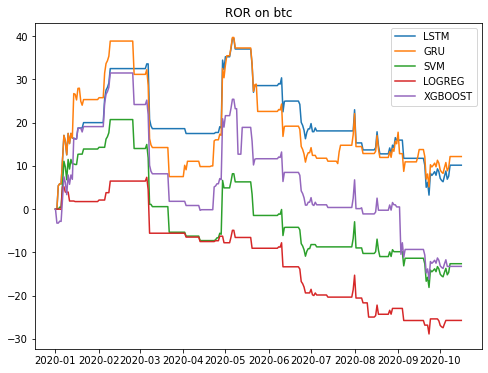

In [ ]:
visualize_ror(df_dict, 'btc')

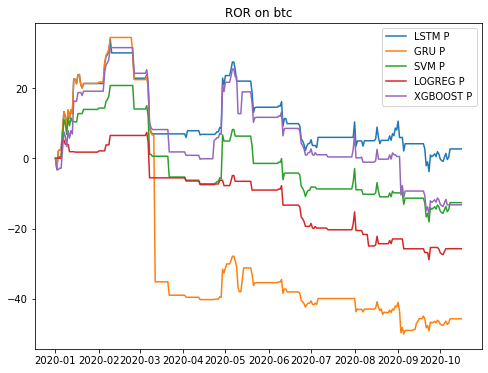

In [ ]:
visualize_ror(df_dict, 'btc',is_purged=True)

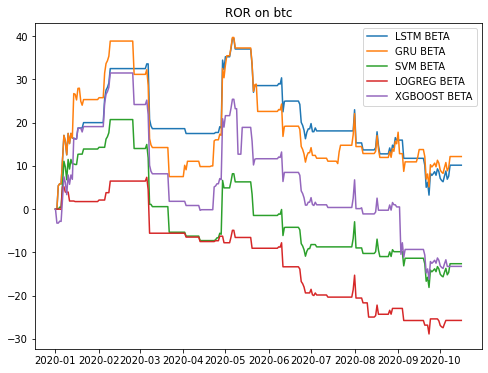

In [ ]:
visualize_ror(df_dict, 'btc', is_beta = True)

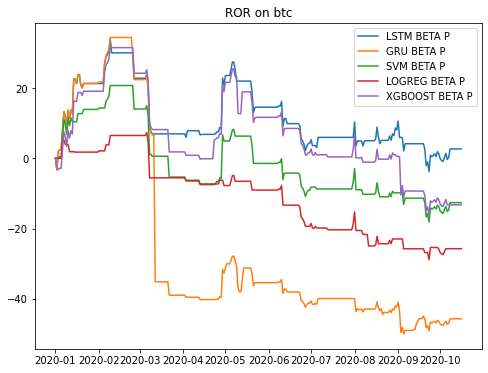

In [ ]:
visualize_ror(df_dict, 'btc', is_beta = True, is_purged = True)

## ETH

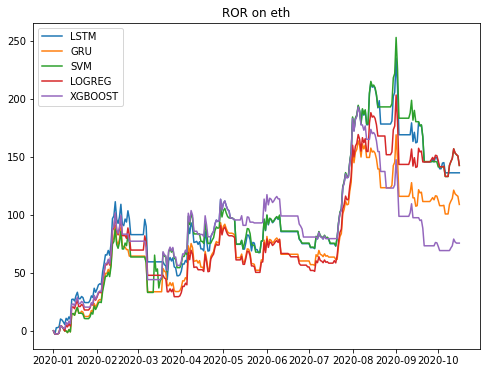

In [ ]:
visualize_ror(df_dict, 'eth')

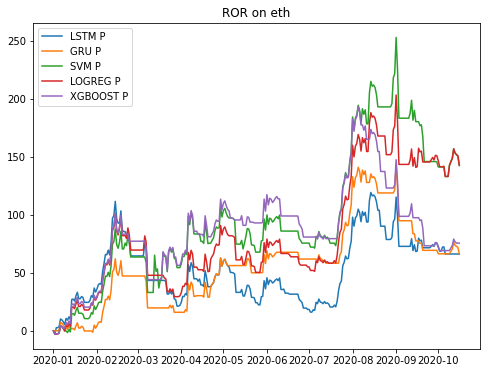

In [ ]:
visualize_ror(df_dict, 'eth',is_purged=True)

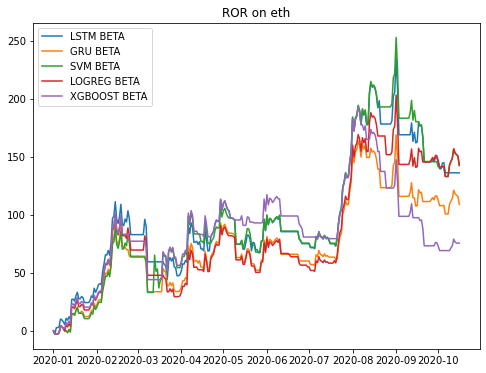

In [ ]:
visualize_ror(df_dict, 'eth', is_beta = True)

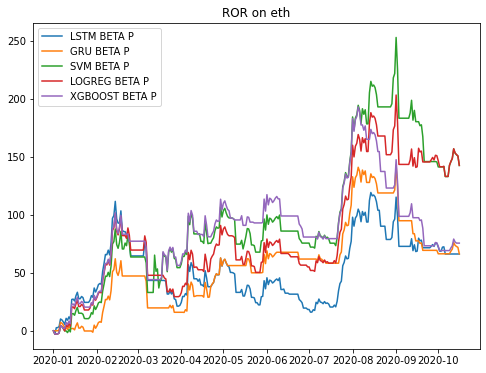

In [ ]:
visualize_ror(df_dict, 'eth', is_beta = True, is_purged = True)

## ADA

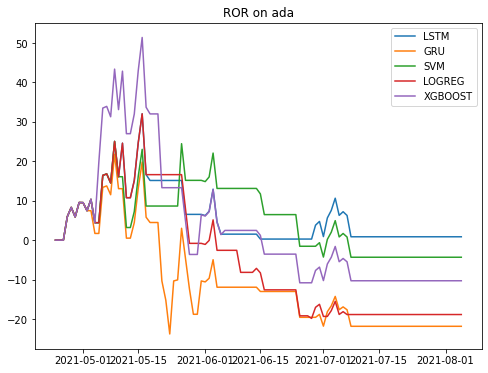

In [ ]:
visualize_ror(df_dict, 'ada')

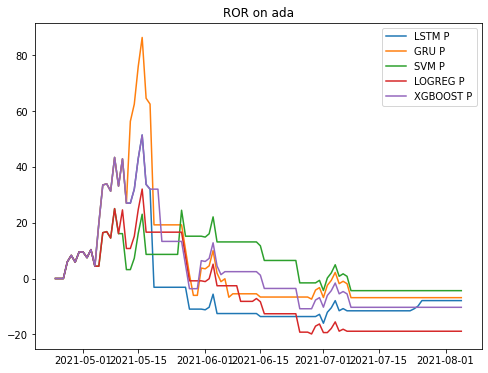

In [ ]:
visualize_ror(df_dict, 'ada',is_purged=True)

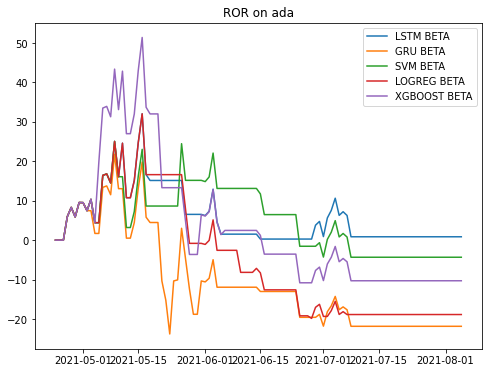

In [ ]:
visualize_ror(df_dict, 'ada', is_beta = True)

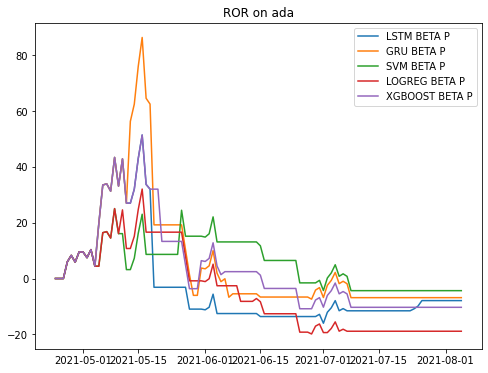

In [ ]:
visualize_ror(df_dict, 'ada', is_beta = True, is_purged = True)

## AAPL

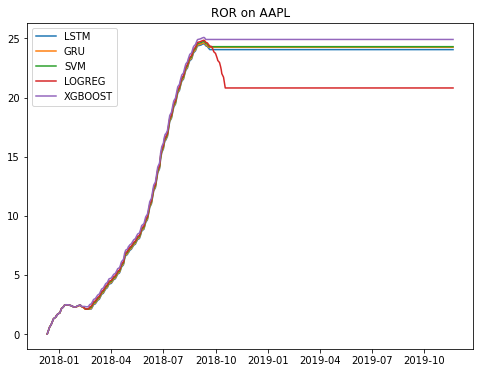

In [ ]:
visualize_ror(df_dict, 'AAPL', df_type='sp')

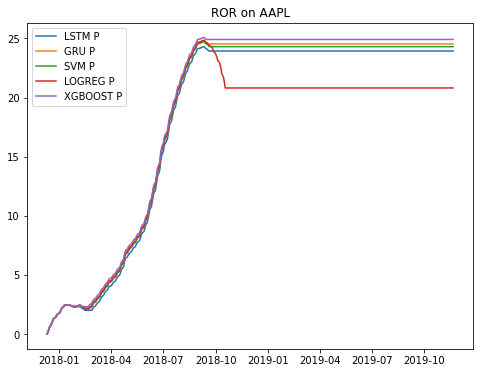

In [ ]:
visualize_ror(df_dict, 'AAPL', df_type='sp', is_purged=True)

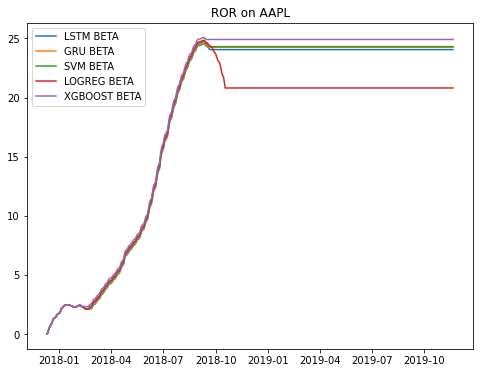

In [ ]:
visualize_ror(df_dict, 'AAPL', df_type='sp', is_beta = True)

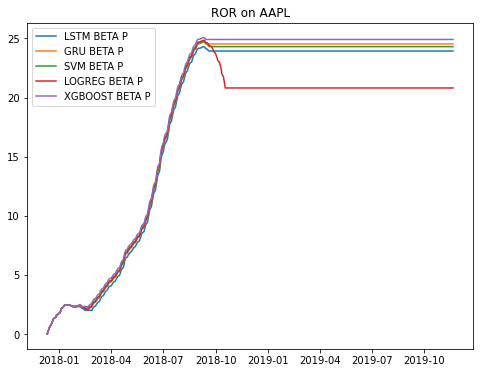

In [ ]:
visualize_ror(df_dict, 'AAPL', df_type='sp', is_beta = True, is_purged = True)

## AMD

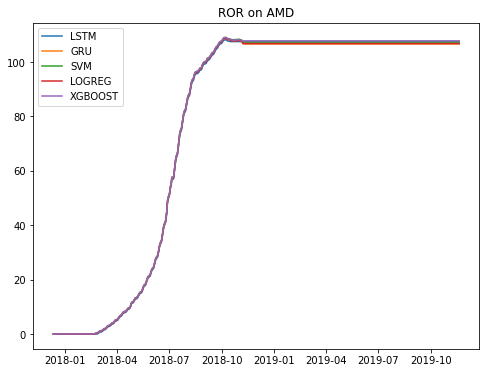

In [ ]:
visualize_ror(df_dict, 'AMD', df_type='sp')

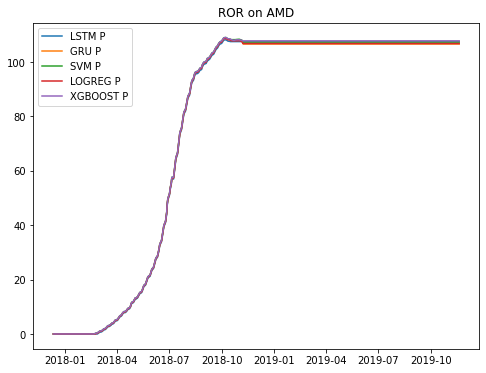

In [ ]:
visualize_ror(df_dict, 'AMD', df_type='sp', is_purged=True)

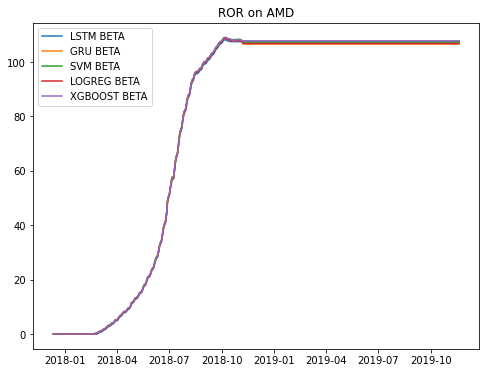

In [ ]:
visualize_ror(df_dict, 'AMD', df_type='sp', is_beta = True)

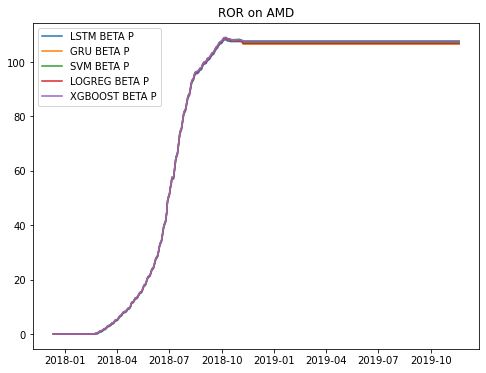

In [ ]:
visualize_ror(df_dict, 'AMD', df_type='sp', is_beta = True, is_purged = True)

## DVN

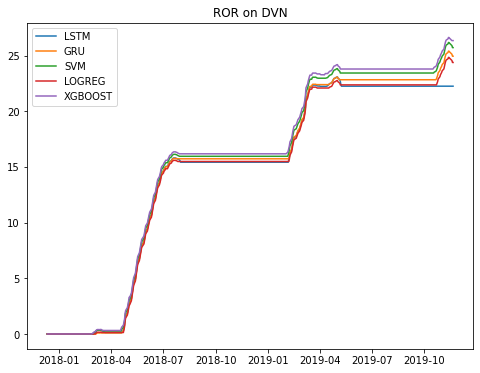

In [ ]:
visualize_ror(df_dict, 'DVN', df_type='sp')

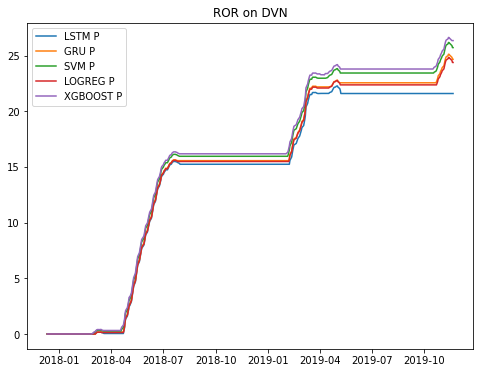

In [ ]:
visualize_ror(df_dict, 'DVN', df_type='sp', is_purged=True)

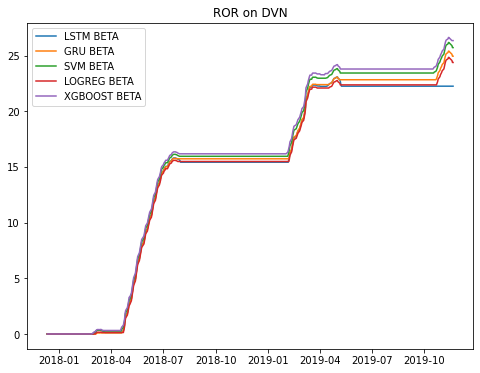

In [ ]:
visualize_ror(df_dict, 'DVN', df_type='sp', is_beta = True)

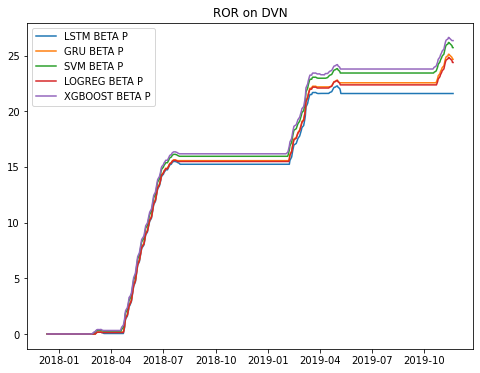

In [ ]:
visualize_ror(df_dict, 'DVN', df_type='sp', is_beta = True, is_purged = True)

## RMD

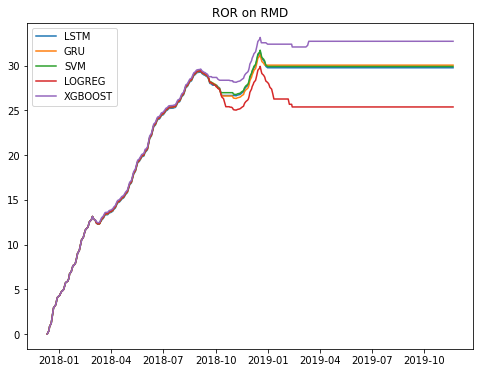

In [ ]:
visualize_ror(df_dict, 'RMD', df_type='sp')

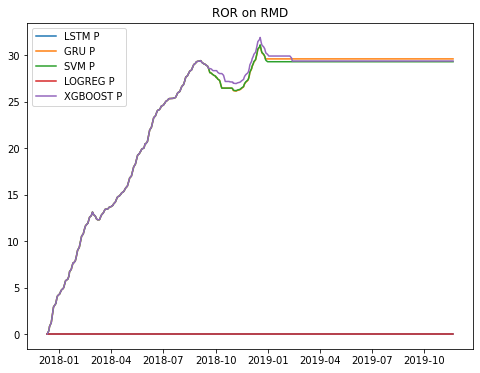

In [ ]:
visualize_ror(df_dict, 'RMD', df_type='sp', is_purged=True)

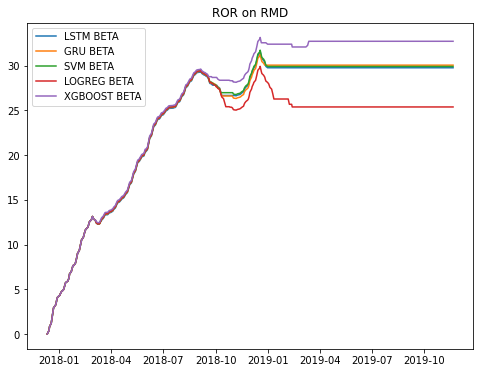

In [ ]:
visualize_ror(df_dict, 'RMD', df_type='sp', is_beta = True)

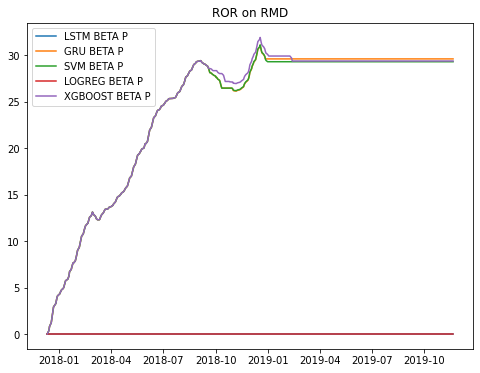

In [ ]:
visualize_ror(df_dict, 'RMD', df_type='sp', is_beta = True, is_purged = True)

## WU

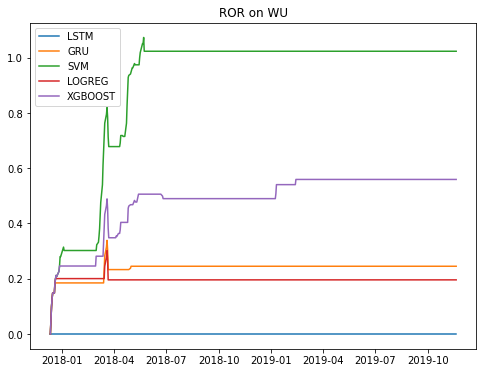

In [ ]:
visualize_ror(df_dict, 'WU', df_type='sp')

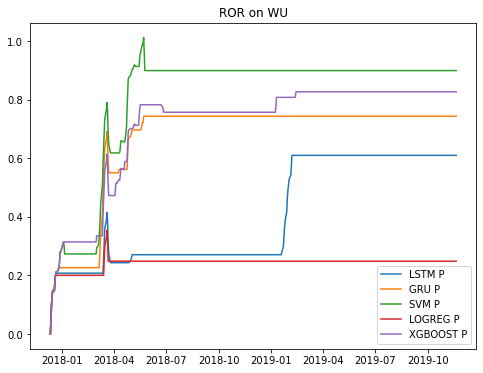

In [ ]:
visualize_ror(df_dict, 'WU', df_type='sp', is_purged=True)

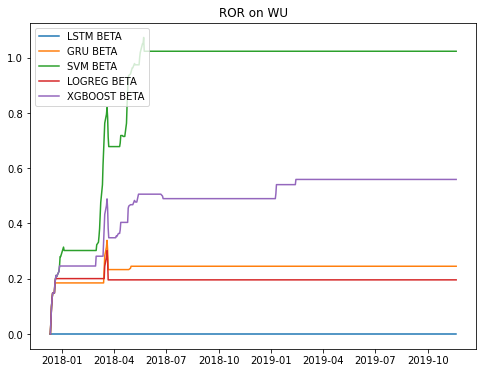

In [ ]:
visualize_ror(df_dict, 'WU', df_type='sp', is_beta = True)

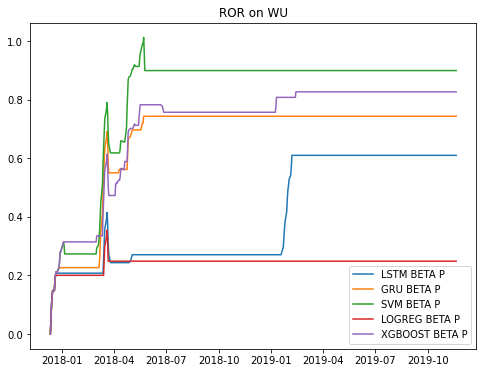

In [ ]:
visualize_ror(df_dict, 'WU', df_type='sp', is_beta = True, is_purged = True)